In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
os.chdir('drive')
os.chdir('mistaken')

In [0]:
!ls -l

total 93973704
drwxr-xr-x 2 root root        4096 Mar  5 06:24 afs
drwxr-xr-x 2 root root        4096 Apr  4 04:26 afs1
-rw-r--r-- 1 root root   353725242 Apr  4 04:22 afs1.zip
-rw-r--r-- 1 root root      449190 Jun 13 09:47 analysis_data.ipynb
drwxr-xr-x 2 root root        4096 Jun 14 05:47 batch_files
-rw-r--r-- 1 root root       34151 Mar  5 09:27 big_living_background.png
-rw-r--r-- 1 root root       47809 Mar  5 09:27 big_park_background.png
-rw-r--r-- 1 root root     7286409 Mar  5 06:26 caffe
-rw-r--r-- 1 root root        9321 May 12 05:55 concatenate_feature.py
drwxr-xr-x 2 root root        4096 Apr 11 11:00 concatenate_feature_resnet50
-rw-r--r-- 1 root root      581355 May  7 04:00 concat_indices_200000000000.json
-rw-r--r-- 1 root root      586640 Apr 16 12:36 concat_indices_2223320934302811922.json
-rw-r--r-- 1 root root      586640 Jun 12 08:10 concat_indices_2408.json
-rw-r--r-- 1 root root      586640 Apr  9 06:12 concat_indices_2912102996873951606.json
-rw-r--r-- 1 root

In [0]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 2.0MB/s 


In [0]:
!python mistaken.py -USE_CAFFENET_FEATURE --LOOKBEHIND=3 --LOOKAHEAD=3 --RANDOM_SEED=0

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Namespace(C=1.0, LOOKAHEAD=3, LOOKBEHIND=3, LR=1e-05, MODEL='keras', RANDOM_SEED=0, USE_ANSWER=False, USE_CAFFENET_FEATURE=True, USE_EXPRESSION=False, USE_NAME=False, USE_PRESENT=False, USE_T=False, USE_XYF=False)
Feature hash: 4023239360457093510
Experiment hash: 8841606304273805265
TRAINING MODEL
Loading data
Load Done...
Using TensorFlow backend.
Constructing model
mistaken.py:932: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_shape=(175616,), kernel_regularizer=<keras.reg..., units=7)`
  W_regularizer=l2(args.C), activation='relu'))
mistaken.py:935: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1, activation="sigmoi

In [0]:
import json
import os
import matplotlib
matplotlib.use('Agg')

import argparse
import copy
import glob
import h5py
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
from scipy.misc import imsave, imresize
from scipy.ndimage import imread


In [0]:
feature_hash = 5000

In [0]:
X = np.load('X_%d.npy' % feature_hash)

In [0]:
with open("data/scenes.json") as f:
    scenes = json.load(f)

IOError: ignored

- Create person centric image

In [0]:
def compute_character_frames(frame):
    ''' Recenters and image at the character's head
    
    sceneId_frameIndex_characterName.png
    sceneId_frameIndex_characterName_flipped.png
    sceneId_frameIndex_original.png
    sceneId_frameIndex_centered.png
    
    '''
    character_vec = util.get_characters_in_frame(frame)
    scene_type = frame['scene']['sceneType']
    scene_id = frame['assignmentId']
    frame_index = frame['hitIdx']
    
    # Render original scene
    img_filename = os.path.join(TMP_PATH, '%s_%d_all.png' % (scene_id, frame_index))
    img_filename = os.path.abspath(img_filename)
    json_filename = os.path.join(TMP_PATH, '%s_%d_all.json' % (scene_id, frame_index))
    json_filename = os.path.abspath(json_filename)
    renderer = util.get_renderer(frame, img_filename, json_filename)
    scene_config = renderer.scene_config_data[scene_type]
    z_decay =  scene_config['zSizeDecay']   
    img_pad_num = scene_config['imgPadNum']

    img = imread(img_filename, mode='RGB')
    global_img = util.get_global_image(img)
    for character in character_vec:
        character_name = character['name']
        img_filename = os.path.join(EGOCENTRIC_IMAGE_FOLDER, '%s_%d_%s.png' % (scene_id, frame_index, character_name))
        pose = util.get_part_pose(character, 'Head', z_decay, img_pad_num, renderer) 
        character_img = util.center_image_at_pose(global_img, pose)
        imsave(img_filename, character_img)

In [0]:
DATA_PATH = '\data'                              # Where to store temporary files
PUBLIC_PATH = 'public'                          # Where to show graphs and diagnostics
EGOCENTRIC_IMAGE_FOLDER = 'egocentric_images'   # Where egocentric images are stored
TMP_PATH = 'tmp'  

In [0]:
compute_character_frames(scenes[0])

- Extract Feature from person centric image
    - Author use layer pool5 of AlexNet model (Caffe)

In [0]:
import multiprocessing

In [0]:
multiprocessing.cpu_count()

2

In [0]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc eagerfpu pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms xsaveopt
bugs		:
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 4

In [0]:
import tensorflow as tf

In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!pip install tqdm
import matplotlib
matplotlib.use('Agg')

import argparse
import copy
import glob
import h5py
import json
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import os
from render_scenes_json import RenderScenes
from scipy.misc import imsave, imresize
from scipy.ndimage import imread
import shutil
from sklearn.metrics import confusion_matrix, average_precision_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import sys
from tqdm import tqdm
import util
import operator

DATA_PATH = 'data'  # Where to store temporary files
PUBLIC_PATH = 'public'  # Where to show graphs and diagnostics
EGOCENTRIC_IMAGE_FOLDER = 'egocentric_images'  # Where egocentric images are stored
TMP_PATH = 'tmp'  # Temporary directly. Deleted after running
FEATURE_RESNET50_PATH = 'resnet50_features_original_size'
CONCATENATE_FEATURE_PATH = 'concatenate_feature_resnet50'


feature_hash = 2408
print 'Concatenating features'
#feature_length = 3*6*2048 # ResNet50 feature
#feature_length = 2048
feature_length = 7*7*512
num_samples = 11955

image_features_filename = os.path.join(DATA_PATH, 'egocentric_image_resnet50_features1')
main_image_features_filename = os.path.join(DATA_PATH, 'egocentric_image_resnet50_features')
feature_folder = 'resnet50_features_original_size'


ANY_IMAGE_FEATURE = True
POOL = False
if ANY_IMAGE_FEATURE:
    frame_dict_filename = os.path.join(DATA_PATH, 'frame_dict_resnet50_original2.json')
    print("Load frame_dict_resnet50_original2.json file")
    #frame_dict_filename = os.path.join(DATA_PATH, 'frame_dict_cnn.json')
    #image_features_filename = os.path.join(DATA_PATH, 'egocentric_image_resnet50_features1.npy')
    #image_feature_matrix = np.load(image_features_filename)
    
    
    #image_features_filename = os.path.join(DATA_PATH, 'egocentric_image_resnet50_features_original_size.npy')

    #image_feature_matrix = np.load(image_features_filename)
    #image_feature_matrix = np.load(image_features_filename)
    
    

    print("Load frame_dict_resnet50_original.json file")
    with open(frame_dict_filename) as f:
        frame_dict = json.load(f)
        
    #temp_frame_dict = sorted(frame_dict.items(), key=operator.itemgetter(1))

    #pool5_size = (256, 12, 21)

else:
    print 'WARNING: no image features used.\n'
    frame_dict_filename = os.path.join(DATA_PATH, 'frame_dict_resnet50.json')
    with open(frame_dict_filename) as f:
        frame_dict = json.load(f)


print("Load other feature")
question_dict_filename = os.path.join(DATA_PATH, 'question_dict.json')
xytf_filename = os.path.join(DATA_PATH, 'xytf_dict.json')
name_expression_filename = os.path.join(DATA_PATH, 'name_expression_dict.json')
present_filename = os.path.join(DATA_PATH, 'present_dict.json')

with open(question_dict_filename) as f:
    question_dict = json.load(f)

with open(xytf_filename) as f:
    xytf_dict = json.load(f)

with open(name_expression_filename) as f:
    name_expression_dict = json.load(f)

with open(present_filename) as f:
    present_dict = json.load(f)


# --------------- NOTICE:  Just use for CNN Features  -------------------
# find size of features
num_samples = 0
for scene_frame_character in tqdm(frame_dict.keys()):
    if 'flipped' in scene_frame_character:
        continue
    (scene_id, frame_index, character_name) = scene_frame_character.split('_')
    frame_index = int(frame_index)
    frame_key = '%s_%d' % (scene_id, frame_index)
    question_vec = question_dict[frame_key]['questions']
    answer_dict_vec = question_dict[frame_key]['answers']
    if character_name not in ['all', 'none', 'centered']:
        assert 'Doll' in character_name, 'Character name: %s' % character_name

        answer_vec = []
        for answer_dict in answer_dict_vec:
            answer = int(answer_dict[character_name] == answer_dict['omniscient'])
            answer_vec.append(answer)
        if answer_vec[0] != answer_vec[1]:
            continue

        num_samples += 1

#feature_length = 2048
#f = h5py.File('X_%d.hdf5' % feature_hash, 'w')
#X = f.create_dataset('X_%d' % feature_hash, (num_samples, feature_length*7), dtype='f')
#X = []
y = []
t = []

scene_id_vec = []
image_filename_vec = []
concat_indices = dict()
index = 0
img_filename_vec = sorted(glob.glob(os.path.join(EGOCENTRIC_IMAGE_FOLDER,'*.png')))
file_done = []
for (indexk, img_filename) in tqdm(enumerate(img_filename_vec), total = len(img_filename_vec)):
    scene_frame_character = img_filename.split('/')[1].split('.')[0]
    if scene_frame_character in file_done:
      print("Exist: ", scene_frame_character)
      continue
    else:
      file_done.append(scene_frame_character)
    #indexk += 3084
#for scene_frame_character in tqdm(frame_dict.keys()):

    if 'flipped' in scene_frame_character:
        continue
    (scene_id, frame_index, character_name) = scene_frame_character.split('_')
    frame_index = int(frame_index)
    frame_key = '%s_%d' % (scene_id, frame_index)
    question_vec = question_dict[frame_key]['questions']
    answer_dict_vec = question_dict[frame_key]['answers']

    if character_name not in ['all', 'none', 'centered']:
        assert 'Doll' in character_name, 'Character name: %s' % character_name
        if ANY_IMAGE_FEATURE:
          
            answer_vec = []
            for answer_dict in answer_dict_vec:
                answer = int(answer_dict[character_name] == answer_dict['omniscient'])
                answer_vec.append(answer)
            if answer_vec[0] != answer_vec[1]:
                continue
                
            if index != 5477:
                index += 1
                continue
            elif index > 5477:
              break
                
            image_feature_vec = []
            # print("Loop for character..")
            ### Loop for each character ###
            #print(scene_frame_character)
            for other_frame_index in range(frame_index - 3, frame_index + 3 + 1):
                key = '%s_%d_%s' % (scene_id, other_frame_index, character_name)

                if key in frame_dict.keys():
                    #image_feature_index = frame_dict[key]
                    #img_feature = image_feature_matrix[image_feature_index]
                    img_feature = np.load(os.path.join(feature_folder, key + '.npy'))
                    print("Key: ", key)
                    print("Size: ", img_feature.shape)
                    pass
                else:  # Character is not present
                    # print("Result None..")
                    img_feature = np.zeros(feature_length)
                    print("Key: ", key)
                    print("Zero: ", img_feature.shape)
                    pass

                image_feature_vec.append(img_feature)
            # print("Out loop")
            image_feature = np.hstack(image_feature_vec)

        # Only used for visualization
        question = question_vec[0]
        image_filename_vec.append('%s_%02d.png' % (scene_id, frame_index))

        answer_dict = answer_dict_vec[0]
        assert answer_dict[character_name] in ['yes', 'no']
        answer = int(answer_dict[character_name] == answer_dict['omniscient'])
        assert answer == answer_vec[0]

        xytf = xytf_dict[scene_frame_character]

        # print("Append feature")
        feature = []
        if ANY_IMAGE_FEATURE:  # CNN feature
            feature.append(image_feature)
            pass

        # index = len(X)
        # assert len(X) == len(y)
        # assert scene_frame_character not in concat_indices
        # concat_indices[scene_frame_character] = index

        #assert index == len(y)
        assert scene_frame_character not in concat_indices
        concat_indices[scene_frame_character] = index
        #assert np.array(feature).shape == (1, feature_length*7)
        print("Index: ", index, " indexK: ", indexk)

        # print("Add feature to X..")
        #X[index] = np.hstack(feature)
        np.save(os.path.join('resnet50_concatenate_features', str(feature_hash) + '_' + str(index)), feature)
        # concatenate_filename = os.path.join(CONCATENATE_FEATURE_PATH, str(feature_hash) + '_' + str(index) + '.npy')
        # if not os.path.exists(concatenate_filename):
        #  np.save(concatenate_filename, feature)
        index += 1
        # X.append(np.hstack(feature))
        y.append(answer)
        t.append(xytf['t'])
        scene_id_vec.append(scene_id)


#X = np.array(X)
y = np.array(y)
t = np.array(t)
assert index == len(y) == len(t)



#print 'X.shape:', X.shape
print 'y.shape:', y.shape
#print 'Number of rows:', len(X)
#print 'Number of unique rows:', len(set([hash(row.tostring()) for row in X]))

#np.save('X_%d.npy' % feature_hash, X)
#f.close()
#np.save('y_%d.npy' % feature_hash, y)
#np.save('t_%d.npy' % feature_hash, t)

with open('concat_indices_%d.json' % feature_hash, 'wb') as f:
  json.dump(concat_indices, f)

with open('scene_id_vec_%d.json' % feature_hash, 'wb') as f:
  json.dump(scene_id_vec, f)

with open('image_filename_vec_%d.json' % feature_hash, 'wb') as f:
  json.dump(image_filename_vec, f)

Concatenating features
Load frame_dict_resnet50_original2.json file
Load frame_dict_resnet50_original.json file


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 87, in catch_

Load other feature




  0%|          | 0/16609 [00:00<?, ?it/s]

 74%|███████▍  | 12250/16609 [00:00<00:00, 121130.06it/s]

100%|██████████| 16609/16609 [00:00<00:00, 118530.86it/s]

  0%|          | 0/16609 [00:00<?, ?it/s]

 17%|█▋        | 2906/16609 [00:00<00:00, 28752.37it/s]

 25%|██▌       | 4206/16609 [00:00<00:00, 20868.79it/s]

 31%|███▏      | 5207/16609 [00:00<00:00, 16980.71it/s]

 37%|███▋      | 6191/16609 [00:00<00:00, 14326.14it/s]

 43%|████▎     | 7116/16609 [00:00<00:00, 12689.90it/s]

('Key: ', '3HQUKB7LNFD2U60PRDQ8ET4657YHHC_-1_Doll20')
('Zero: ', (25088,))
('Key: ', '3HQUKB7LNFD2U60PRDQ8ET4657YHHC_0_Doll20')
('Size: ', (25088,))
('Key: ', '3HQUKB7LNFD2U60PRDQ8ET4657YHHC_1_Doll20')
('Size: ', (25088,))
('Key: ', '3HQUKB7LNFD2U60PRDQ8ET4657YHHC_2_Doll20')
('Size: ', (25088,))
('Key: ', '3HQUKB7LNFD2U60PRDQ8ET4657YHHC_3_Doll20')
('Size: ', (25088,))
('Key: ', '3HQUKB7LNFD2U60PRDQ8ET4657YHHC_4_Doll20')
('Size: ', (25088,))
('Key: ', '3HQUKB7LNFD2U60PRDQ8ET4657YHHC_5_Doll20')
('Size: ', (25088,))
('Index: ', 5477, ' indexK: ', 7570)




 48%|████▊     | 7979/16609 [00:10<00:11, 726.53it/s]  

 52%|█████▏    | 8603/16609 [00:11<00:10, 776.31it/s]

 55%|█████▍    | 9086/16609 [00:11<00:09, 812.49it/s]

 58%|█████▊    | 9554/16609 [00:11<00:08, 846.76it/s]

 60%|██████    | 9986/16609 [00:11<00:07, 877.27it/s]

 63%|██████▎   | 10425/16609 [00:11<00:06, 907.41it/s]

 65%|██████▌   | 10864/16609 [00:11<00:06, 937.73it/s]

 68%|██████▊   | 11310/16609 [00:11<00:05, 967.88it/s]

 71%|███████   | 11750/16609 [00:11<00:04, 996.91it/s]

 73%|███████▎  | 12199/16609 [00:11<00:04, 1026.53it/s]

 76%|███████▌  | 12648/16609 [00:11<00:03, 1055.30it/s]

 79%|███████▉  | 13084/16609 [00:12<00:03, 1082.16it/s]

 81%|████████▏ | 13517/16609 [00:12<00:02, 1108.68it/s]

 84%|████████▍ | 13943/16609 [00:12<00:02, 1134.14it/s]

 87%|████████▋ | 14367/16609 [00:12<00:01, 1158.24it/s]

 89%|████████▉ | 14779/16609 [00:12<00:01, 1180.64it/s]

 91%|█████████▏| 15177/16609 [00:12<00:01, 1201.46it/s]

 94%|█████████▎| 15566/16609 [00:12<00:00

AssertionError: ignored

In [0]:
 os.path.exists(os.path.join('resnet50_concatenate_features', str(feature_hash) + '_' + str(4710) + '.npy'))

True

Try to save the concatenate feature


In [0]:
import numpy as np
import os
from tqdm import tqdm
feature_hash = 2408
X = np.zeros((11955, 512*7*7*7))
for index in tqdm(range(11955)):
  x = np.hstack(np.load(os.path.join('resnet50_concatenate_features', str(feature_hash) + '_' + str(index) + '.npy')))
  x = x.clip(0,1)
  X[index] = x

f.close()



  0%|          | 0/11955 [00:00<?, ?it/s]

  0%|          | 1/11955 [00:37<123:42:47, 37.26s/it]

  0%|          | 2/11955 [00:38<63:14:09, 19.05s/it] 

  0%|          | 3/11955 [00:39<43:20:23, 13.05s/it]

  0%|          | 4/11955 [00:40<33:20:16, 10.04s/it]

  0%|          | 5/11955 [00:40<27:11:06,  8.19s/it]

  0%|          | 6/11955 [00:43<23:48:52,  7.17s/it]

  0%|          | 7/11955 [00:44<20:53:32,  6.29s/it]

  0%|          | 8/11955 [00:44<18:39:15,  5.62s/it]

  0%|          | 9/11955 [00:46<17:01:14,  5.13s/it]

  0%|          | 10/11955 [00:47<15:38:58,  4.72s/it]

  0%|          | 11/11955 [00:48<14:32:20,  4.38s/it]

  0%|          | 12/11955 [00:49<13:35:42,  4.10s/it]

  0%|          | 13/11955 [00:50<12:47:42,  3.86s/it]

  0%|          | 14/11955 [00:50<12:04:21,  3.64s/it]

  0%|          | 15/11955 [00:51<11:27:19,  3.45s/it]

  0%|          | 16/11955 [00:52<10:56:34,  3.30s/it]

  0%|          | 17/11955 [00:53<10:30:13,  3.17s/it]

  0%|          | 18/11955 [



  0%|          | 33/11955 [01:11<7:08:28,  2.16s/it]

  0%|          | 34/11955 [01:11<7:00:02,  2.11s/it]

  0%|          | 35/11955 [01:13<6:54:22,  2.09s/it]

  0%|          | 36/11955 [01:14<6:49:39,  2.06s/it]

  0%|          | 37/11955 [01:15<6:44:36,  2.04s/it]

  0%|          | 38/11955 [01:16<6:39:04,  2.01s/it]

  0%|          | 39/11955 [01:17<6:34:57,  1.99s/it]

  0%|          | 40/11955 [01:18<6:30:14,  1.97s/it]

  0%|          | 41/11955 [01:19<6:24:58,  1.94s/it]

  0%|          | 42/11955 [01:20<6:20:49,  1.92s/it]

  0%|          | 43/11955 [01:21<6:16:10,  1.89s/it]

  0%|          | 44/11955 [01:22<6:11:44,  1.87s/it]

  0%|          | 45/11955 [01:23<6:08:09,  1.85s/it]

  0%|          | 46/11955 [01:24<6:04:37,  1.84s/it]

  0%|          | 47/11955 [01:25<6:01:26,  1.82s/it]

  0%|          | 48/11955 [01:26<5:58:07,  1.80s/it]

  0%|          | 49/11955 [01:27<5:55:04,  1.79s/it]

  0%|          | 50/11955 [01:28<5:52:01,  1.77s/it]

  0%|          | 51/11955 



  1%|          | 66/11955 [01:44<5:13:09,  1.58s/it]

  1%|          | 67/11955 [01:45<5:11:42,  1.57s/it]

  1%|          | 68/11955 [01:46<5:09:47,  1.56s/it]

  1%|          | 69/11955 [01:47<5:07:34,  1.55s/it]

  1%|          | 70/11955 [01:48<5:05:51,  1.54s/it]

  1%|          | 71/11955 [01:48<5:03:46,  1.53s/it]

  1%|          | 72/11955 [01:49<5:01:56,  1.52s/it]

  1%|          | 73/11955 [01:50<5:00:04,  1.52s/it]

  1%|          | 74/11955 [01:51<4:58:30,  1.51s/it]

  1%|          | 75/11955 [01:52<4:57:30,  1.50s/it]

  1%|          | 76/11955 [01:53<4:56:01,  1.50s/it]

  1%|          | 77/11955 [01:54<4:54:15,  1.49s/it]

  1%|          | 78/11955 [01:55<4:52:59,  1.48s/it]

  1%|          | 79/11955 [01:56<4:51:12,  1.47s/it]

  1%|          | 80/11955 [01:57<4:49:48,  1.46s/it]

  1%|          | 81/11955 [01:57<4:48:17,  1.46s/it]

  1%|          | 82/11955 [01:58<4:46:50,  1.45s/it]

  1%|          | 83/11955 [01:59<4:45:23,  1.44s/it]

  1%|          | 84/11955 



  1%|          | 99/11955 [02:16<4:32:30,  1.38s/it]

  1%|          | 100/11955 [02:17<4:31:51,  1.38s/it]

  1%|          | 101/11955 [02:18<4:30:57,  1.37s/it]

  1%|          | 102/11955 [02:19<4:29:45,  1.37s/it]

  1%|          | 103/11955 [02:20<4:28:40,  1.36s/it]

  1%|          | 104/11955 [02:21<4:28:05,  1.36s/it]

  1%|          | 105/11955 [02:22<4:27:21,  1.35s/it]

  1%|          | 106/11955 [02:22<4:26:13,  1.35s/it]

  1%|          | 107/11955 [02:23<4:25:39,  1.35s/it]

  1%|          | 108/11955 [02:24<4:24:55,  1.34s/it]

  1%|          | 109/11955 [02:25<4:23:53,  1.34s/it]

  1%|          | 110/11955 [02:26<4:23:24,  1.33s/it]

  1%|          | 111/11955 [02:27<4:23:07,  1.33s/it]

  1%|          | 112/11955 [02:28<4:22:24,  1.33s/it]

  1%|          | 113/11955 [02:29<4:21:34,  1.33s/it]

  1%|          | 114/11955 [02:30<4:21:08,  1.32s/it]

  1%|          | 115/11955 [02:31<4:20:34,  1.32s/it]

  1%|          | 116/11955 [02:32<4:19:57,  1.32s/it]

  1%|    



  1%|          | 132/11955 [02:47<4:10:19,  1.27s/it]

  1%|          | 133/11955 [02:48<4:10:17,  1.27s/it]

  1%|          | 134/11955 [02:49<4:09:44,  1.27s/it]

  1%|          | 135/11955 [02:50<4:09:03,  1.26s/it]

  1%|          | 136/11955 [02:51<4:08:34,  1.26s/it]

  1%|          | 137/11955 [02:52<4:07:59,  1.26s/it]

  1%|          | 138/11955 [02:53<4:07:33,  1.26s/it]

  1%|          | 139/11955 [02:54<4:07:07,  1.25s/it]

  1%|          | 140/11955 [02:55<4:06:37,  1.25s/it]

  1%|          | 141/11955 [02:56<4:06:09,  1.25s/it]

  1%|          | 142/11955 [02:57<4:05:48,  1.25s/it]

  1%|          | 143/11955 [02:58<4:05:17,  1.25s/it]

  1%|          | 144/11955 [02:59<4:04:49,  1.24s/it]

  1%|          | 145/11955 [03:00<4:04:31,  1.24s/it]

  1%|          | 146/11955 [03:01<4:04:00,  1.24s/it]

  1%|          | 147/11955 [03:01<4:03:37,  1.24s/it]

  1%|          | 148/11955 [03:04<4:05:36,  1.25s/it]

  1%|          | 149/11955 [03:05<4:05:03,  1.25s/it]

  1%|▏  



  1%|▏         | 165/11955 [03:31<4:12:22,  1.28s/it]

  1%|▏         | 166/11955 [03:32<4:11:53,  1.28s/it]

  1%|▏         | 167/11955 [03:33<4:11:33,  1.28s/it]

  1%|▏         | 168/11955 [03:34<4:11:12,  1.28s/it]

  1%|▏         | 169/11955 [03:35<4:10:57,  1.28s/it]

  1%|▏         | 170/11955 [03:36<4:10:39,  1.28s/it]

  1%|▏         | 171/11955 [03:38<4:10:27,  1.28s/it]

  1%|▏         | 172/11955 [03:38<4:09:50,  1.27s/it]

  1%|▏         | 173/11955 [03:39<4:09:24,  1.27s/it]

  1%|▏         | 174/11955 [03:40<4:08:54,  1.27s/it]

  1%|▏         | 175/11955 [03:41<4:08:35,  1.27s/it]

  1%|▏         | 176/11955 [03:42<4:07:59,  1.26s/it]

  1%|▏         | 177/11955 [03:43<4:07:59,  1.26s/it]

  1%|▏         | 178/11955 [03:44<4:07:43,  1.26s/it]

  1%|▏         | 179/11955 [03:45<4:07:22,  1.26s/it]

  2%|▏         | 180/11955 [03:46<4:06:50,  1.26s/it]

  2%|▏         | 181/11955 [03:47<4:06:31,  1.26s/it]

  2%|▏         | 182/11955 [03:48<4:06:18,  1.26s/it]

  2%|▏  



  2%|▏         | 198/11955 [04:02<4:00:23,  1.23s/it]

  2%|▏         | 199/11955 [04:05<4:01:22,  1.23s/it]

  2%|▏         | 200/11955 [04:06<4:01:12,  1.23s/it]

  2%|▏         | 201/11955 [04:07<4:01:33,  1.23s/it]

  2%|▏         | 202/11955 [04:08<4:01:16,  1.23s/it]

  2%|▏         | 203/11955 [04:09<4:00:56,  1.23s/it]

  2%|▏         | 204/11955 [04:10<4:00:29,  1.23s/it]

  2%|▏         | 205/11955 [04:11<4:00:07,  1.23s/it]

  2%|▏         | 206/11955 [04:12<4:00:04,  1.23s/it]

  2%|▏         | 207/11955 [04:13<3:59:48,  1.22s/it]

  2%|▏         | 208/11955 [04:14<3:59:24,  1.22s/it]

  2%|▏         | 209/11955 [04:15<3:59:05,  1.22s/it]

  2%|▏         | 210/11955 [04:16<3:58:47,  1.22s/it]

  2%|▏         | 211/11955 [04:17<3:58:25,  1.22s/it]

  2%|▏         | 212/11955 [04:17<3:58:05,  1.22s/it]

  2%|▏         | 213/11955 [04:18<3:57:47,  1.22s/it]

  2%|▏         | 214/11955 [04:19<3:57:20,  1.21s/it]

  2%|▏         | 215/11955 [04:20<3:56:55,  1.21s/it]

  2%|▏  



  2%|▏         | 231/11955 [04:35<3:53:21,  1.19s/it]

  2%|▏         | 232/11955 [04:36<3:53:08,  1.19s/it]

  2%|▏         | 233/11955 [04:37<3:52:53,  1.19s/it]

  2%|▏         | 234/11955 [04:38<3:52:41,  1.19s/it]

  2%|▏         | 235/11955 [04:39<3:52:27,  1.19s/it]

  2%|▏         | 236/11955 [04:40<3:52:05,  1.19s/it]

  2%|▏         | 237/11955 [04:41<3:51:42,  1.19s/it]

  2%|▏         | 238/11955 [04:41<3:51:22,  1.18s/it]

  2%|▏         | 239/11955 [04:42<3:50:58,  1.18s/it]

  2%|▏         | 240/11955 [04:43<3:50:44,  1.18s/it]

  2%|▏         | 241/11955 [04:44<3:50:27,  1.18s/it]

  2%|▏         | 242/11955 [04:45<3:50:17,  1.18s/it]

  2%|▏         | 243/11955 [04:46<3:50:01,  1.18s/it]

  2%|▏         | 244/11955 [04:47<3:50:02,  1.18s/it]

  2%|▏         | 245/11955 [04:48<3:49:54,  1.18s/it]

  2%|▏         | 246/11955 [04:49<3:49:40,  1.18s/it]

  2%|▏         | 247/11955 [04:50<3:49:31,  1.18s/it]

  2%|▏         | 248/11955 [04:51<3:49:19,  1.18s/it]

  2%|▏  



  2%|▏         | 264/11955 [05:08<3:47:28,  1.17s/it]

  2%|▏         | 265/11955 [05:09<3:47:14,  1.17s/it]

  2%|▏         | 266/11955 [05:09<3:46:56,  1.16s/it]

  2%|▏         | 267/11955 [05:10<3:46:36,  1.16s/it]

  2%|▏         | 268/11955 [05:11<3:46:20,  1.16s/it]

  2%|▏         | 269/11955 [05:12<3:46:05,  1.16s/it]

  2%|▏         | 270/11955 [05:13<3:45:56,  1.16s/it]

  2%|▏         | 271/11955 [05:14<3:45:47,  1.16s/it]

  2%|▏         | 272/11955 [05:15<3:45:39,  1.16s/it]

  2%|▏         | 273/11955 [05:16<3:45:30,  1.16s/it]

  2%|▏         | 274/11955 [05:17<3:45:18,  1.16s/it]

  2%|▏         | 275/11955 [05:18<3:45:08,  1.16s/it]

  2%|▏         | 276/11955 [05:18<3:44:58,  1.16s/it]

  2%|▏         | 277/11955 [05:19<3:44:47,  1.15s/it]

  2%|▏         | 278/11955 [05:20<3:44:35,  1.15s/it]

  2%|▏         | 279/11955 [05:21<3:44:26,  1.15s/it]

  2%|▏         | 280/11955 [05:22<3:44:23,  1.15s/it]

  2%|▏         | 281/11955 [05:23<3:44:10,  1.15s/it]

  2%|▏  



  2%|▏         | 297/11955 [05:37<3:40:59,  1.14s/it]

  2%|▏         | 298/11955 [05:38<3:40:48,  1.14s/it]

  3%|▎         | 299/11955 [05:39<3:40:33,  1.14s/it]

  3%|▎         | 300/11955 [05:40<3:40:19,  1.13s/it]

  3%|▎         | 301/11955 [05:41<3:40:11,  1.13s/it]

  3%|▎         | 302/11955 [05:42<3:40:03,  1.13s/it]

  3%|▎         | 303/11955 [05:43<3:39:55,  1.13s/it]

  3%|▎         | 304/11955 [05:44<3:39:47,  1.13s/it]

  3%|▎         | 305/11955 [05:44<3:39:37,  1.13s/it]

  3%|▎         | 306/11955 [05:45<3:39:29,  1.13s/it]

  3%|▎         | 307/11955 [05:46<3:39:13,  1.13s/it]

  3%|▎         | 308/11955 [05:47<3:39:00,  1.13s/it]

  3%|▎         | 309/11955 [05:48<3:38:53,  1.13s/it]

  3%|▎         | 310/11955 [05:49<3:38:41,  1.13s/it]

  3%|▎         | 311/11955 [05:50<3:38:29,  1.13s/it]

  3%|▎         | 312/11955 [05:51<3:38:18,  1.13s/it]

  3%|▎         | 313/11955 [05:51<3:38:09,  1.12s/it]

  3%|▎         | 314/11955 [05:52<3:38:02,  1.12s/it]

  3%|▎  



  3%|▎         | 330/11955 [06:10<3:37:17,  1.12s/it]

  3%|▎         | 331/11955 [06:11<3:37:19,  1.12s/it]

  3%|▎         | 332/11955 [06:12<3:37:13,  1.12s/it]

  3%|▎         | 333/11955 [06:13<3:37:00,  1.12s/it]

  3%|▎         | 334/11955 [06:14<3:36:56,  1.12s/it]

  3%|▎         | 335/11955 [06:14<3:36:43,  1.12s/it]

  3%|▎         | 336/11955 [06:15<3:36:29,  1.12s/it]

  3%|▎         | 337/11955 [06:16<3:36:19,  1.12s/it]

  3%|▎         | 338/11955 [06:18<3:36:52,  1.12s/it]

  3%|▎         | 339/11955 [06:19<3:36:44,  1.12s/it]

  3%|▎         | 340/11955 [06:20<3:36:31,  1.12s/it]

  3%|▎         | 341/11955 [06:21<3:36:20,  1.12s/it]

  3%|▎         | 342/11955 [06:21<3:36:10,  1.12s/it]

  3%|▎         | 343/11955 [06:22<3:36:02,  1.12s/it]

  3%|▎         | 344/11955 [06:23<3:35:53,  1.12s/it]

  3%|▎         | 345/11955 [06:24<3:35:48,  1.12s/it]

  3%|▎         | 346/11955 [06:25<3:35:37,  1.11s/it]

  3%|▎         | 347/11955 [06:26<3:35:30,  1.11s/it]

  3%|▎  



  3%|▎         | 363/11955 [06:41<3:33:56,  1.11s/it]

  3%|▎         | 364/11955 [06:42<3:33:43,  1.11s/it]

  3%|▎         | 365/11955 [06:43<3:33:36,  1.11s/it]

  3%|▎         | 366/11955 [06:44<3:33:31,  1.11s/it]

  3%|▎         | 367/11955 [06:45<3:33:27,  1.11s/it]

  3%|▎         | 368/11955 [06:46<3:33:25,  1.11s/it]

  3%|▎         | 369/11955 [06:47<3:33:11,  1.10s/it]

  3%|▎         | 370/11955 [06:48<3:33:04,  1.10s/it]

  3%|▎         | 371/11955 [06:49<3:33:01,  1.10s/it]

  3%|▎         | 372/11955 [06:50<3:32:59,  1.10s/it]

  3%|▎         | 373/11955 [06:51<3:32:51,  1.10s/it]

  3%|▎         | 374/11955 [06:52<3:32:43,  1.10s/it]

  3%|▎         | 375/11955 [06:53<3:32:34,  1.10s/it]

  3%|▎         | 376/11955 [06:53<3:32:27,  1.10s/it]

  3%|▎         | 377/11955 [06:55<3:32:26,  1.10s/it]

  3%|▎         | 378/11955 [06:55<3:32:18,  1.10s/it]

  3%|▎         | 379/11955 [06:56<3:32:11,  1.10s/it]

  3%|▎         | 380/11955 [06:57<3:32:04,  1.10s/it]

  3%|▎  



  3%|▎         | 396/11955 [07:14<3:31:15,  1.10s/it]

  3%|▎         | 397/11955 [07:15<3:31:06,  1.10s/it]

  3%|▎         | 398/11955 [07:15<3:30:55,  1.10s/it]

  3%|▎         | 399/11955 [07:16<3:30:46,  1.09s/it]

  3%|▎         | 400/11955 [07:17<3:30:38,  1.09s/it]

  3%|▎         | 401/11955 [07:18<3:30:34,  1.09s/it]

  3%|▎         | 402/11955 [07:19<3:30:28,  1.09s/it]

  3%|▎         | 403/11955 [07:20<3:30:24,  1.09s/it]

  3%|▎         | 404/11955 [07:22<3:30:58,  1.10s/it]

  3%|▎         | 405/11955 [07:23<3:30:54,  1.10s/it]

  3%|▎         | 406/11955 [07:24<3:30:51,  1.10s/it]

  3%|▎         | 407/11955 [07:25<3:30:48,  1.10s/it]

  3%|▎         | 408/11955 [07:26<3:30:40,  1.09s/it]

  3%|▎         | 409/11955 [07:27<3:30:36,  1.09s/it]

  3%|▎         | 410/11955 [07:28<3:30:28,  1.09s/it]

  3%|▎         | 411/11955 [07:29<3:30:22,  1.09s/it]

  3%|▎         | 412/11955 [07:30<3:30:16,  1.09s/it]

  3%|▎         | 413/11955 [07:31<3:30:10,  1.09s/it]

  3%|▎  



  4%|▎         | 429/11955 [07:45<3:28:23,  1.08s/it]

  4%|▎         | 430/11955 [07:46<3:28:15,  1.08s/it]

  4%|▎         | 431/11955 [07:46<3:28:04,  1.08s/it]

  4%|▎         | 432/11955 [07:47<3:28:00,  1.08s/it]

  4%|▎         | 433/11955 [07:48<3:27:52,  1.08s/it]

  4%|▎         | 434/11955 [07:49<3:27:50,  1.08s/it]

  4%|▎         | 435/11955 [07:50<3:27:48,  1.08s/it]

  4%|▎         | 436/11955 [07:51<3:27:45,  1.08s/it]

  4%|▎         | 437/11955 [07:52<3:27:39,  1.08s/it]

  4%|▎         | 438/11955 [07:53<3:27:37,  1.08s/it]

  4%|▎         | 439/11955 [07:54<3:27:32,  1.08s/it]

  4%|▎         | 440/11955 [07:55<3:27:27,  1.08s/it]

  4%|▎         | 441/11955 [07:56<3:27:16,  1.08s/it]

  4%|▎         | 442/11955 [07:57<3:27:07,  1.08s/it]

  4%|▎         | 443/11955 [07:57<3:27:00,  1.08s/it]

  4%|▎         | 444/11955 [07:58<3:26:53,  1.08s/it]

  4%|▎         | 445/11955 [07:59<3:26:49,  1.08s/it]

  4%|▎         | 446/11955 [08:00<3:26:40,  1.08s/it]

  4%|▎  



  4%|▍         | 462/11955 [08:16<3:26:01,  1.08s/it]

  4%|▍         | 463/11955 [08:18<3:26:07,  1.08s/it]

  4%|▍         | 464/11955 [08:19<3:26:08,  1.08s/it]

  4%|▍         | 465/11955 [08:20<3:26:04,  1.08s/it]

  4%|▍         | 466/11955 [08:21<3:25:59,  1.08s/it]

  4%|▍         | 467/11955 [08:22<3:26:03,  1.08s/it]

  4%|▍         | 468/11955 [08:23<3:26:00,  1.08s/it]

  4%|▍         | 469/11955 [08:24<3:25:58,  1.08s/it]

  4%|▍         | 470/11955 [08:25<3:25:53,  1.08s/it]

  4%|▍         | 471/11955 [08:26<3:25:46,  1.08s/it]

  4%|▍         | 472/11955 [08:27<3:25:39,  1.07s/it]

  4%|▍         | 473/11955 [08:27<3:25:31,  1.07s/it]

  4%|▍         | 474/11955 [08:28<3:25:27,  1.07s/it]

  4%|▍         | 475/11955 [08:29<3:25:22,  1.07s/it]

  4%|▍         | 476/11955 [08:30<3:25:21,  1.07s/it]

  4%|▍         | 477/11955 [08:31<3:25:14,  1.07s/it]

  4%|▍         | 478/11955 [08:32<3:25:07,  1.07s/it]

  4%|▍         | 479/11955 [08:33<3:25:02,  1.07s/it]

  4%|▍  



  4%|▍         | 495/11955 [08:48<3:24:02,  1.07s/it]

  4%|▍         | 496/11955 [08:49<3:23:56,  1.07s/it]

  4%|▍         | 497/11955 [08:50<3:23:55,  1.07s/it]

  4%|▍         | 498/11955 [08:51<3:23:54,  1.07s/it]

  4%|▍         | 499/11955 [08:53<3:24:02,  1.07s/it]

  4%|▍         | 500/11955 [08:54<3:23:59,  1.07s/it]

  4%|▍         | 501/11955 [08:55<3:23:54,  1.07s/it]

  4%|▍         | 502/11955 [08:56<3:23:49,  1.07s/it]

  4%|▍         | 503/11955 [08:56<3:23:44,  1.07s/it]

  4%|▍         | 504/11955 [08:57<3:23:37,  1.07s/it]

  4%|▍         | 505/11955 [08:58<3:23:31,  1.07s/it]

  4%|▍         | 506/11955 [08:59<3:23:29,  1.07s/it]

  4%|▍         | 507/11955 [09:00<3:23:19,  1.07s/it]

  4%|▍         | 508/11955 [09:01<3:23:11,  1.07s/it]

  4%|▍         | 509/11955 [09:02<3:23:08,  1.06s/it]

  4%|▍         | 510/11955 [09:02<3:23:01,  1.06s/it]

  4%|▍         | 511/11955 [09:03<3:22:50,  1.06s/it]

  4%|▍         | 512/11955 [09:04<3:22:46,  1.06s/it]

  4%|▍  



  4%|▍         | 528/11955 [09:24<3:23:31,  1.07s/it]

  4%|▍         | 529/11955 [09:25<3:23:29,  1.07s/it]

  4%|▍         | 530/11955 [09:26<3:23:25,  1.07s/it]

  4%|▍         | 531/11955 [09:27<3:23:21,  1.07s/it]

  4%|▍         | 532/11955 [09:28<3:23:23,  1.07s/it]

  4%|▍         | 533/11955 [09:29<3:23:22,  1.07s/it]

  4%|▍         | 534/11955 [09:30<3:23:20,  1.07s/it]

  4%|▍         | 535/11955 [09:32<3:23:45,  1.07s/it]

  4%|▍         | 536/11955 [09:33<3:23:42,  1.07s/it]

  4%|▍         | 537/11955 [09:34<3:23:37,  1.07s/it]

  5%|▍         | 538/11955 [09:35<3:23:31,  1.07s/it]

  5%|▍         | 539/11955 [09:36<3:23:25,  1.07s/it]

  5%|▍         | 540/11955 [09:37<3:23:18,  1.07s/it]

  5%|▍         | 541/11955 [09:38<3:23:15,  1.07s/it]

  5%|▍         | 542/11955 [09:38<3:23:09,  1.07s/it]

  5%|▍         | 543/11955 [09:39<3:23:06,  1.07s/it]

  5%|▍         | 544/11955 [09:40<3:23:01,  1.07s/it]

  5%|▍         | 545/11955 [09:41<3:22:54,  1.07s/it]

  5%|▍  



  5%|▍         | 561/11955 [09:56<3:21:53,  1.06s/it]

  5%|▍         | 562/11955 [09:57<3:21:49,  1.06s/it]

  5%|▍         | 563/11955 [09:58<3:21:44,  1.06s/it]

  5%|▍         | 564/11955 [09:59<3:21:38,  1.06s/it]

  5%|▍         | 565/11955 [09:59<3:21:31,  1.06s/it]

  5%|▍         | 566/11955 [10:00<3:21:28,  1.06s/it]

  5%|▍         | 567/11955 [10:01<3:21:22,  1.06s/it]

  5%|▍         | 568/11955 [10:02<3:21:14,  1.06s/it]

  5%|▍         | 569/11955 [10:03<3:21:11,  1.06s/it]

  5%|▍         | 570/11955 [10:04<3:21:12,  1.06s/it]

  5%|▍         | 571/11955 [10:05<3:21:10,  1.06s/it]

  5%|▍         | 572/11955 [10:06<3:21:03,  1.06s/it]

  5%|▍         | 573/11955 [10:07<3:20:58,  1.06s/it]

  5%|▍         | 574/11955 [10:07<3:20:53,  1.06s/it]

  5%|▍         | 575/11955 [10:08<3:20:47,  1.06s/it]

  5%|▍         | 576/11955 [10:09<3:20:39,  1.06s/it]

  5%|▍         | 577/11955 [10:10<3:20:39,  1.06s/it]

  5%|▍         | 578/11955 [10:12<3:21:04,  1.06s/it]

  5%|▍  



  5%|▍         | 594/11955 [10:28<3:20:13,  1.06s/it]

  5%|▍         | 595/11955 [10:29<3:20:14,  1.06s/it]

  5%|▍         | 596/11955 [10:30<3:20:09,  1.06s/it]

  5%|▍         | 597/11955 [10:31<3:20:06,  1.06s/it]

  5%|▌         | 598/11955 [10:31<3:20:02,  1.06s/it]

  5%|▌         | 599/11955 [10:32<3:19:57,  1.06s/it]

  5%|▌         | 600/11955 [10:33<3:19:53,  1.06s/it]

  5%|▌         | 601/11955 [10:34<3:19:49,  1.06s/it]

  5%|▌         | 602/11955 [10:35<3:19:42,  1.06s/it]

  5%|▌         | 603/11955 [10:36<3:19:38,  1.06s/it]

  5%|▌         | 604/11955 [10:37<3:19:36,  1.06s/it]

  5%|▌         | 605/11955 [10:38<3:19:38,  1.06s/it]

  5%|▌         | 606/11955 [10:39<3:19:37,  1.06s/it]

  5%|▌         | 607/11955 [10:40<3:19:36,  1.06s/it]

  5%|▌         | 608/11955 [10:41<3:19:32,  1.06s/it]

  5%|▌         | 609/11955 [10:42<3:19:25,  1.05s/it]

  5%|▌         | 610/11955 [10:43<3:19:19,  1.05s/it]

  5%|▌         | 611/11955 [10:43<3:19:16,  1.05s/it]

  5%|▌  



  5%|▌         | 627/11955 [10:58<3:18:23,  1.05s/it]

  5%|▌         | 628/11955 [10:59<3:18:20,  1.05s/it]

  5%|▌         | 629/11955 [11:00<3:18:16,  1.05s/it]

  5%|▌         | 630/11955 [11:01<3:18:15,  1.05s/it]

  5%|▌         | 631/11955 [11:02<3:18:12,  1.05s/it]

  5%|▌         | 632/11955 [11:03<3:18:08,  1.05s/it]

  5%|▌         | 633/11955 [11:04<3:18:06,  1.05s/it]

  5%|▌         | 634/11955 [11:05<3:18:05,  1.05s/it]

  5%|▌         | 635/11955 [11:06<3:18:02,  1.05s/it]

  5%|▌         | 636/11955 [11:08<3:18:20,  1.05s/it]

  5%|▌         | 637/11955 [11:09<3:18:17,  1.05s/it]

  5%|▌         | 638/11955 [11:10<3:18:14,  1.05s/it]

  5%|▌         | 639/11955 [11:11<3:18:11,  1.05s/it]

  5%|▌         | 640/11955 [11:13<3:18:34,  1.05s/it]

  5%|▌         | 641/11955 [11:14<3:18:29,  1.05s/it]

  5%|▌         | 642/11955 [11:15<3:18:25,  1.05s/it]

  5%|▌         | 643/11955 [11:16<3:18:21,  1.05s/it]

  5%|▌         | 644/11955 [11:17<3:18:15,  1.05s/it]

  5%|▌  



  6%|▌         | 660/11955 [11:33<3:17:49,  1.05s/it]

  6%|▌         | 661/11955 [11:34<3:17:48,  1.05s/it]

  6%|▌         | 662/11955 [11:35<3:17:46,  1.05s/it]

  6%|▌         | 663/11955 [11:36<3:17:42,  1.05s/it]

  6%|▌         | 664/11955 [11:37<3:17:38,  1.05s/it]

  6%|▌         | 665/11955 [11:38<3:17:34,  1.05s/it]

  6%|▌         | 666/11955 [11:39<3:17:30,  1.05s/it]

  6%|▌         | 667/11955 [11:40<3:17:26,  1.05s/it]

  6%|▌         | 668/11955 [11:40<3:17:21,  1.05s/it]

  6%|▌         | 669/11955 [11:41<3:17:21,  1.05s/it]

  6%|▌         | 670/11955 [11:42<3:17:15,  1.05s/it]

  6%|▌         | 671/11955 [11:43<3:17:12,  1.05s/it]

  6%|▌         | 672/11955 [11:44<3:17:12,  1.05s/it]

  6%|▌         | 673/11955 [11:45<3:17:10,  1.05s/it]

  6%|▌         | 674/11955 [11:46<3:17:08,  1.05s/it]

  6%|▌         | 675/11955 [11:47<3:17:02,  1.05s/it]

  6%|▌         | 676/11955 [11:48<3:17:03,  1.05s/it]

  6%|▌         | 677/11955 [11:49<3:16:59,  1.05s/it]

  6%|▌  



  6%|▌         | 693/11955 [12:04<3:16:14,  1.05s/it]

  6%|▌         | 694/11955 [12:05<3:16:14,  1.05s/it]

  6%|▌         | 695/11955 [12:06<3:16:10,  1.05s/it]

  6%|▌         | 696/11955 [12:07<3:16:07,  1.05s/it]

  6%|▌         | 697/11955 [12:08<3:16:05,  1.05s/it]

  6%|▌         | 698/11955 [12:09<3:16:03,  1.04s/it]

  6%|▌         | 699/11955 [12:10<3:15:57,  1.04s/it]

  6%|▌         | 700/11955 [12:11<3:15:53,  1.04s/it]

  6%|▌         | 701/11955 [12:11<3:15:51,  1.04s/it]

  6%|▌         | 702/11955 [12:14<3:16:12,  1.05s/it]

  6%|▌         | 703/11955 [12:15<3:16:08,  1.05s/it]

  6%|▌         | 704/11955 [12:16<3:16:04,  1.05s/it]

  6%|▌         | 705/11955 [12:16<3:15:58,  1.05s/it]

  6%|▌         | 706/11955 [12:20<3:16:30,  1.05s/it]

  6%|▌         | 707/11955 [12:20<3:16:28,  1.05s/it]

  6%|▌         | 708/11955 [12:21<3:16:24,  1.05s/it]

  6%|▌         | 709/11955 [12:22<3:16:18,  1.05s/it]

  6%|▌         | 710/11955 [12:23<3:16:19,  1.05s/it]

  6%|▌  



  6%|▌         | 726/11955 [12:38<3:15:37,  1.05s/it]

  6%|▌         | 727/11955 [12:39<3:15:35,  1.05s/it]

  6%|▌         | 728/11955 [12:40<3:15:30,  1.04s/it]

  6%|▌         | 729/11955 [12:41<3:15:28,  1.04s/it]

  6%|▌         | 730/11955 [12:42<3:15:25,  1.04s/it]

  6%|▌         | 731/11955 [12:43<3:15:21,  1.04s/it]

  6%|▌         | 732/11955 [12:44<3:15:18,  1.04s/it]

  6%|▌         | 733/11955 [12:45<3:15:15,  1.04s/it]

  6%|▌         | 734/11955 [12:46<3:15:13,  1.04s/it]

  6%|▌         | 735/11955 [12:47<3:15:12,  1.04s/it]

  6%|▌         | 736/11955 [12:48<3:15:11,  1.04s/it]

  6%|▌         | 737/11955 [12:49<3:15:09,  1.04s/it]

  6%|▌         | 738/11955 [12:50<3:15:08,  1.04s/it]

  6%|▌         | 739/11955 [12:51<3:15:06,  1.04s/it]

  6%|▌         | 740/11955 [12:52<3:15:06,  1.04s/it]

  6%|▌         | 741/11955 [12:53<3:15:05,  1.04s/it]

  6%|▌         | 742/11955 [12:54<3:15:00,  1.04s/it]

  6%|▌         | 743/11955 [12:55<3:14:58,  1.04s/it]

  6%|▌  



  6%|▋         | 759/11955 [13:10<3:14:16,  1.04s/it]

  6%|▋         | 760/11955 [13:10<3:14:09,  1.04s/it]

  6%|▋         | 761/11955 [13:11<3:14:06,  1.04s/it]

  6%|▋         | 762/11955 [13:12<3:14:02,  1.04s/it]

  6%|▋         | 763/11955 [13:15<3:14:21,  1.04s/it]

  6%|▋         | 764/11955 [13:15<3:14:19,  1.04s/it]

  6%|▋         | 765/11955 [13:16<3:14:17,  1.04s/it]

  6%|▋         | 766/11955 [13:17<3:14:11,  1.04s/it]

  6%|▋         | 767/11955 [13:18<3:14:09,  1.04s/it]

  6%|▋         | 768/11955 [13:19<3:14:06,  1.04s/it]

  6%|▋         | 769/11955 [13:20<3:14:08,  1.04s/it]

  6%|▋         | 770/11955 [13:21<3:14:08,  1.04s/it]

  6%|▋         | 771/11955 [13:23<3:14:08,  1.04s/it]

  6%|▋         | 772/11955 [13:24<3:14:09,  1.04s/it]

  6%|▋         | 773/11955 [13:24<3:14:04,  1.04s/it]

  6%|▋         | 774/11955 [13:25<3:14:00,  1.04s/it]

  6%|▋         | 775/11955 [13:26<3:13:56,  1.04s/it]

  6%|▋         | 776/11955 [13:27<3:13:53,  1.04s/it]

  6%|▋  



  7%|▋         | 792/11955 [13:42<3:13:11,  1.04s/it]

  7%|▋         | 793/11955 [13:43<3:13:10,  1.04s/it]

  7%|▋         | 794/11955 [13:44<3:13:08,  1.04s/it]

  7%|▋         | 795/11955 [13:45<3:13:06,  1.04s/it]

  7%|▋         | 796/11955 [13:46<3:13:01,  1.04s/it]

  7%|▋         | 797/11955 [13:48<3:13:14,  1.04s/it]

  7%|▋         | 798/11955 [13:48<3:13:09,  1.04s/it]

  7%|▋         | 799/11955 [13:49<3:13:07,  1.04s/it]

  7%|▋         | 800/11955 [13:50<3:13:06,  1.04s/it]

  7%|▋         | 801/11955 [13:51<3:13:02,  1.04s/it]

  7%|▋         | 802/11955 [13:52<3:13:00,  1.04s/it]

  7%|▋         | 803/11955 [13:53<3:12:57,  1.04s/it]

  7%|▋         | 804/11955 [13:54<3:12:54,  1.04s/it]

  7%|▋         | 805/11955 [13:55<3:12:52,  1.04s/it]

  7%|▋         | 806/11955 [13:56<3:12:48,  1.04s/it]

  7%|▋         | 807/11955 [13:57<3:12:45,  1.04s/it]

  7%|▋         | 808/11955 [13:58<3:12:44,  1.04s/it]

  7%|▋         | 809/11955 [13:59<3:12:41,  1.04s/it]

  7%|▋  



  7%|▋         | 825/11955 [14:13<3:11:55,  1.03s/it]

  7%|▋         | 826/11955 [14:18<3:12:47,  1.04s/it]

  7%|▋         | 827/11955 [14:19<3:12:44,  1.04s/it]

  7%|▋         | 828/11955 [14:20<3:12:41,  1.04s/it]

  7%|▋         | 829/11955 [14:21<3:12:36,  1.04s/it]

  7%|▋         | 830/11955 [14:21<3:12:32,  1.04s/it]

  7%|▋         | 831/11955 [14:22<3:12:28,  1.04s/it]

  7%|▋         | 832/11955 [14:23<3:12:26,  1.04s/it]

  7%|▋         | 833/11955 [14:24<3:12:24,  1.04s/it]

  7%|▋         | 834/11955 [14:25<3:12:24,  1.04s/it]

  7%|▋         | 835/11955 [14:26<3:12:23,  1.04s/it]

  7%|▋         | 836/11955 [14:27<3:12:20,  1.04s/it]

  7%|▋         | 837/11955 [14:28<3:12:19,  1.04s/it]

  7%|▋         | 838/11955 [14:29<3:12:19,  1.04s/it]

  7%|▋         | 839/11955 [14:30<3:12:17,  1.04s/it]

  7%|▋         | 840/11955 [14:31<3:12:15,  1.04s/it]

  7%|▋         | 841/11955 [14:32<3:12:09,  1.04s/it]

  7%|▋         | 842/11955 [14:33<3:12:10,  1.04s/it]

  7%|▋  



  7%|▋         | 858/11955 [14:49<3:11:42,  1.04s/it]

  7%|▋         | 859/11955 [14:50<3:11:39,  1.04s/it]

  7%|▋         | 860/11955 [14:51<3:11:38,  1.04s/it]

  7%|▋         | 861/11955 [14:52<3:11:34,  1.04s/it]

  7%|▋         | 862/11955 [14:53<3:11:33,  1.04s/it]

  7%|▋         | 863/11955 [14:54<3:11:31,  1.04s/it]

  7%|▋         | 864/11955 [14:55<3:11:31,  1.04s/it]

  7%|▋         | 865/11955 [14:56<3:11:32,  1.04s/it]

  7%|▋         | 866/11955 [14:57<3:11:30,  1.04s/it]

  7%|▋         | 867/11955 [14:58<3:11:27,  1.04s/it]

  7%|▋         | 868/11955 [14:59<3:11:25,  1.04s/it]

  7%|▋         | 869/11955 [15:00<3:11:23,  1.04s/it]

  7%|▋         | 870/11955 [15:01<3:11:20,  1.04s/it]

  7%|▋         | 871/11955 [15:02<3:11:21,  1.04s/it]

  7%|▋         | 872/11955 [15:03<3:11:18,  1.04s/it]

  7%|▋         | 873/11955 [15:04<3:11:15,  1.04s/it]

  7%|▋         | 874/11955 [15:05<3:11:14,  1.04s/it]

  7%|▋         | 875/11955 [15:07<3:11:28,  1.04s/it]

  7%|▋  



  7%|▋         | 891/11955 [15:25<3:11:30,  1.04s/it]

  7%|▋         | 892/11955 [15:26<3:11:28,  1.04s/it]

  7%|▋         | 893/11955 [15:27<3:11:25,  1.04s/it]

  7%|▋         | 894/11955 [15:28<3:11:23,  1.04s/it]

  7%|▋         | 895/11955 [15:28<3:11:19,  1.04s/it]

  7%|▋         | 896/11955 [15:29<3:11:16,  1.04s/it]

  8%|▊         | 897/11955 [15:30<3:11:14,  1.04s/it]

  8%|▊         | 898/11955 [15:31<3:11:12,  1.04s/it]

  8%|▊         | 899/11955 [15:32<3:11:10,  1.04s/it]

  8%|▊         | 900/11955 [15:33<3:11:08,  1.04s/it]

  8%|▊         | 901/11955 [15:34<3:11:06,  1.04s/it]

  8%|▊         | 902/11955 [15:35<3:11:03,  1.04s/it]

  8%|▊         | 903/11955 [15:36<3:11:01,  1.04s/it]

  8%|▊         | 904/11955 [15:37<3:11:00,  1.04s/it]

  8%|▊         | 905/11955 [15:38<3:10:58,  1.04s/it]

  8%|▊         | 906/11955 [15:39<3:10:57,  1.04s/it]

  8%|▊         | 907/11955 [15:40<3:10:59,  1.04s/it]

  8%|▊         | 908/11955 [15:41<3:10:57,  1.04s/it]

  8%|▊  



  8%|▊         | 924/11955 [15:59<3:10:49,  1.04s/it]

  8%|▊         | 925/11955 [16:00<3:10:47,  1.04s/it]

  8%|▊         | 926/11955 [16:00<3:10:45,  1.04s/it]

  8%|▊         | 927/11955 [16:01<3:10:42,  1.04s/it]

  8%|▊         | 928/11955 [16:02<3:10:40,  1.04s/it]

  8%|▊         | 929/11955 [16:03<3:10:38,  1.04s/it]

  8%|▊         | 930/11955 [16:04<3:10:35,  1.04s/it]

  8%|▊         | 931/11955 [16:05<3:10:32,  1.04s/it]

  8%|▊         | 932/11955 [16:06<3:10:27,  1.04s/it]

  8%|▊         | 933/11955 [16:07<3:10:24,  1.04s/it]

  8%|▊         | 934/11955 [16:08<3:10:22,  1.04s/it]

  8%|▊         | 935/11955 [16:08<3:10:20,  1.04s/it]

  8%|▊         | 936/11955 [16:09<3:10:17,  1.04s/it]

  8%|▊         | 937/11955 [16:10<3:10:15,  1.04s/it]

  8%|▊         | 938/11955 [16:12<3:10:17,  1.04s/it]

  8%|▊         | 939/11955 [16:13<3:10:17,  1.04s/it]

  8%|▊         | 940/11955 [16:14<3:10:19,  1.04s/it]

  8%|▊         | 941/11955 [16:15<3:10:15,  1.04s/it]

  8%|▊  



  8%|▊         | 957/11955 [16:34<3:10:24,  1.04s/it]

  8%|▊         | 958/11955 [16:35<3:10:21,  1.04s/it]

  8%|▊         | 959/11955 [16:36<3:10:20,  1.04s/it]

  8%|▊         | 960/11955 [16:36<3:10:17,  1.04s/it]

  8%|▊         | 961/11955 [16:37<3:10:15,  1.04s/it]

  8%|▊         | 962/11955 [16:38<3:10:13,  1.04s/it]

  8%|▊         | 963/11955 [16:39<3:10:12,  1.04s/it]

  8%|▊         | 964/11955 [16:40<3:10:11,  1.04s/it]

  8%|▊         | 965/11955 [16:41<3:10:08,  1.04s/it]

  8%|▊         | 966/11955 [16:42<3:10:05,  1.04s/it]

  8%|▊         | 967/11955 [16:43<3:10:01,  1.04s/it]

  8%|▊         | 968/11955 [16:44<3:09:57,  1.04s/it]

  8%|▊         | 969/11955 [16:45<3:09:55,  1.04s/it]

  8%|▊         | 970/11955 [16:45<3:09:51,  1.04s/it]

  8%|▊         | 971/11955 [16:47<3:09:51,  1.04s/it]

  8%|▊         | 972/11955 [16:47<3:09:47,  1.04s/it]

  8%|▊         | 973/11955 [16:48<3:09:47,  1.04s/it]

  8%|▊         | 974/11955 [16:49<3:09:45,  1.04s/it]

  8%|▊  



  8%|▊         | 990/11955 [17:05<3:09:22,  1.04s/it]

  8%|▊         | 991/11955 [17:06<3:09:19,  1.04s/it]

  8%|▊         | 992/11955 [17:07<3:09:15,  1.04s/it]

  8%|▊         | 993/11955 [17:08<3:09:17,  1.04s/it]

  8%|▊         | 994/11955 [17:09<3:09:15,  1.04s/it]

  8%|▊         | 995/11955 [17:10<3:09:14,  1.04s/it]

  8%|▊         | 996/11955 [17:12<3:09:15,  1.04s/it]

  8%|▊         | 997/11955 [17:13<3:09:14,  1.04s/it]

  8%|▊         | 998/11955 [17:14<3:09:15,  1.04s/it]

  8%|▊         | 999/11955 [17:15<3:09:16,  1.04s/it]

  8%|▊         | 1000/11955 [17:16<3:09:14,  1.04s/it]

  8%|▊         | 1001/11955 [17:17<3:09:10,  1.04s/it]

  8%|▊         | 1002/11955 [17:18<3:09:07,  1.04s/it]

  8%|▊         | 1003/11955 [17:20<3:09:22,  1.04s/it]

  8%|▊         | 1004/11955 [17:21<3:09:19,  1.04s/it]

  8%|▊         | 1005/11955 [17:22<3:09:18,  1.04s/it]

  8%|▊         | 1006/11955 [17:23<3:09:16,  1.04s/it]

  8%|▊         | 1007/11955 [17:24<3:09:14,  1.04s/it]





  9%|▊         | 1023/11955 [17:39<3:08:47,  1.04s/it]

  9%|▊         | 1024/11955 [17:41<3:08:46,  1.04s/it]

  9%|▊         | 1025/11955 [17:42<3:08:44,  1.04s/it]

  9%|▊         | 1026/11955 [17:43<3:08:45,  1.04s/it]

  9%|▊         | 1027/11955 [17:44<3:08:43,  1.04s/it]

  9%|▊         | 1028/11955 [17:45<3:08:41,  1.04s/it]

  9%|▊         | 1029/11955 [17:46<3:08:39,  1.04s/it]

  9%|▊         | 1030/11955 [17:47<3:08:37,  1.04s/it]

  9%|▊         | 1031/11955 [17:47<3:08:33,  1.04s/it]

  9%|▊         | 1032/11955 [17:48<3:08:32,  1.04s/it]

  9%|▊         | 1033/11955 [17:49<3:08:30,  1.04s/it]

  9%|▊         | 1034/11955 [17:50<3:08:28,  1.04s/it]

  9%|▊         | 1035/11955 [17:51<3:08:25,  1.04s/it]

  9%|▊         | 1036/11955 [17:52<3:08:24,  1.04s/it]

  9%|▊         | 1037/11955 [17:53<3:08:23,  1.04s/it]

  9%|▊         | 1038/11955 [17:54<3:08:25,  1.04s/it]

  9%|▊         | 1039/11955 [17:55<3:08:23,  1.04s/it]

  9%|▊         | 1040/11955 [17:56<3:08:21,  1

  9%|▉         | 1055/11955 [18:10<3:07:48,  1.03s/it]

  9%|▉         | 1056/11955 [18:11<3:07:44,  1.03s/it]

  9%|▉         | 1057/11955 [18:12<3:07:41,  1.03s/it]

  9%|▉         | 1058/11955 [18:12<3:07:37,  1.03s/it]

  9%|▉         | 1059/11955 [18:13<3:07:33,  1.03s/it]

  9%|▉         | 1060/11955 [18:14<3:07:31,  1.03s/it]

  9%|▉         | 1061/11955 [18:15<3:07:30,  1.03s/it]

  9%|▉         | 1062/11955 [18:16<3:07:27,  1.03s/it]

  9%|▉         | 1063/11955 [18:17<3:07:26,  1.03s/it]

  9%|▉         | 1064/11955 [18:18<3:07:25,  1.03s/it]

  9%|▉         | 1065/11955 [18:19<3:07:20,  1.03s/it]

  9%|▉         | 1066/11955 [18:21<3:07:33,  1.03s/it]

  9%|▉         | 1067/11955 [18:22<3:07:32,  1.03s/it]

  9%|▉         | 1068/11955 [18:23<3:07:30,  1.03s/it]

  9%|▉         | 1069/11955 [18:24<3:07:28,  1.03s/it]

  9%|▉         | 1070/11955 [18:25<3:07:24,  1.03s/it]

  9%|▉         | 1071/11955 [18:26<3:07:21,  1.03s/it]

  9%|▉         | 1072/11955 [18:26<3:07:17,  1.0

  9%|▉         | 1087/11955 [18:40<3:06:41,  1.03s/it]

  9%|▉         | 1088/11955 [18:41<3:06:39,  1.03s/it]

  9%|▉         | 1089/11955 [18:42<3:06:35,  1.03s/it]

  9%|▉         | 1090/11955 [18:43<3:06:34,  1.03s/it]

  9%|▉         | 1091/11955 [18:44<3:06:33,  1.03s/it]

  9%|▉         | 1092/11955 [18:45<3:06:32,  1.03s/it]

  9%|▉         | 1093/11955 [18:45<3:06:27,  1.03s/it]

  9%|▉         | 1094/11955 [18:46<3:06:24,  1.03s/it]

  9%|▉         | 1095/11955 [18:47<3:06:21,  1.03s/it]

  9%|▉         | 1096/11955 [18:48<3:06:19,  1.03s/it]

  9%|▉         | 1097/11955 [18:49<3:06:18,  1.03s/it]

  9%|▉         | 1098/11955 [18:50<3:06:16,  1.03s/it]

  9%|▉         | 1099/11955 [18:51<3:06:14,  1.03s/it]

  9%|▉         | 1100/11955 [18:52<3:06:10,  1.03s/it]

  9%|▉         | 1101/11955 [18:53<3:06:10,  1.03s/it]

  9%|▉         | 1102/11955 [18:53<3:06:07,  1.03s/it]

  9%|▉         | 1103/11955 [18:54<3:06:05,  1.03s/it]

  9%|▉         | 1104/11955 [18:55<3:06:04,  1.0

  9%|▉         | 1119/11955 [19:09<3:05:34,  1.03s/it]

  9%|▉         | 1120/11955 [19:10<3:05:32,  1.03s/it]

  9%|▉         | 1121/11955 [19:11<3:05:30,  1.03s/it]

  9%|▉         | 1122/11955 [19:12<3:05:27,  1.03s/it]

  9%|▉         | 1123/11955 [19:13<3:05:24,  1.03s/it]

  9%|▉         | 1124/11955 [19:14<3:05:22,  1.03s/it]

  9%|▉         | 1125/11955 [19:15<3:05:19,  1.03s/it]

  9%|▉         | 1126/11955 [19:15<3:05:17,  1.03s/it]

  9%|▉         | 1127/11955 [19:16<3:05:15,  1.03s/it]

  9%|▉         | 1128/11955 [19:17<3:05:12,  1.03s/it]

  9%|▉         | 1129/11955 [19:18<3:05:08,  1.03s/it]

  9%|▉         | 1130/11955 [19:19<3:05:06,  1.03s/it]

  9%|▉         | 1131/11955 [19:20<3:05:02,  1.03s/it]

  9%|▉         | 1132/11955 [19:22<3:05:12,  1.03s/it]

  9%|▉         | 1133/11955 [19:23<3:05:09,  1.03s/it]

  9%|▉         | 1134/11955 [19:23<3:05:05,  1.03s/it]

  9%|▉         | 1135/11955 [19:24<3:05:03,  1.03s/it]

 10%|▉         | 1136/11955 [19:25<3:04:59,  1.0

 10%|▉         | 1151/11955 [19:39<3:04:35,  1.03s/it]

 10%|▉         | 1152/11955 [19:40<3:04:32,  1.02s/it]

 10%|▉         | 1153/11955 [19:41<3:04:31,  1.02s/it]

 10%|▉         | 1154/11955 [19:42<3:04:29,  1.02s/it]

 10%|▉         | 1155/11955 [19:43<3:04:27,  1.02s/it]

 10%|▉         | 1156/11955 [19:44<3:04:25,  1.02s/it]

 10%|▉         | 1157/11955 [19:45<3:04:22,  1.02s/it]

 10%|▉         | 1158/11955 [19:46<3:04:20,  1.02s/it]

 10%|▉         | 1159/11955 [19:47<3:04:17,  1.02s/it]

 10%|▉         | 1160/11955 [19:47<3:04:15,  1.02s/it]

 10%|▉         | 1161/11955 [19:48<3:04:13,  1.02s/it]

 10%|▉         | 1162/11955 [19:49<3:04:11,  1.02s/it]

 10%|▉         | 1163/11955 [19:50<3:04:09,  1.02s/it]

 10%|▉         | 1164/11955 [19:51<3:04:06,  1.02s/it]

 10%|▉         | 1165/11955 [19:52<3:04:03,  1.02s/it]

 10%|▉         | 1166/11955 [19:53<3:04:02,  1.02s/it]

 10%|▉         | 1167/11955 [19:54<3:04:01,  1.02s/it]

 10%|▉         | 1168/11955 [19:55<3:03:58,  1.0

 10%|▉         | 1183/11955 [20:09<3:03:33,  1.02s/it]

 10%|▉         | 1184/11955 [20:10<3:03:33,  1.02s/it]

 10%|▉         | 1185/11955 [20:11<3:03:31,  1.02s/it]

 10%|▉         | 1186/11955 [20:12<3:03:30,  1.02s/it]

 10%|▉         | 1187/11955 [20:13<3:03:27,  1.02s/it]

 10%|▉         | 1188/11955 [20:14<3:03:25,  1.02s/it]

 10%|▉         | 1189/11955 [20:15<3:03:23,  1.02s/it]

 10%|▉         | 1190/11955 [20:16<3:03:21,  1.02s/it]

 10%|▉         | 1191/11955 [20:16<3:03:18,  1.02s/it]

 10%|▉         | 1192/11955 [20:17<3:03:15,  1.02s/it]

 10%|▉         | 1193/11955 [20:18<3:03:12,  1.02s/it]

 10%|▉         | 1194/11955 [20:19<3:03:10,  1.02s/it]

 10%|▉         | 1195/11955 [20:20<3:03:09,  1.02s/it]

 10%|█         | 1196/11955 [20:23<3:03:22,  1.02s/it]

 10%|█         | 1197/11955 [20:23<3:03:20,  1.02s/it]

 10%|█         | 1198/11955 [20:24<3:03:18,  1.02s/it]

 10%|█         | 1199/11955 [20:25<3:03:17,  1.02s/it]

 10%|█         | 1200/11955 [20:26<3:03:16,  1.0

 10%|█         | 1215/11955 [20:40<3:02:45,  1.02s/it]

 10%|█         | 1216/11955 [20:41<3:02:44,  1.02s/it]

 10%|█         | 1217/11955 [20:42<3:02:42,  1.02s/it]

 10%|█         | 1218/11955 [20:43<3:02:41,  1.02s/it]

 10%|█         | 1219/11955 [20:44<3:02:39,  1.02s/it]

 10%|█         | 1220/11955 [20:45<3:02:37,  1.02s/it]

 10%|█         | 1221/11955 [20:46<3:02:35,  1.02s/it]

 10%|█         | 1222/11955 [20:47<3:02:33,  1.02s/it]

 10%|█         | 1223/11955 [20:48<3:02:33,  1.02s/it]

 10%|█         | 1224/11955 [20:49<3:02:30,  1.02s/it]

 10%|█         | 1225/11955 [20:50<3:02:30,  1.02s/it]

 10%|█         | 1226/11955 [20:53<3:02:47,  1.02s/it]

 10%|█         | 1227/11955 [20:54<3:02:45,  1.02s/it]

 10%|█         | 1228/11955 [20:55<3:02:44,  1.02s/it]

 10%|█         | 1229/11955 [20:55<3:02:40,  1.02s/it]

 10%|█         | 1230/11955 [20:56<3:02:38,  1.02s/it]

 10%|█         | 1231/11955 [20:57<3:02:37,  1.02s/it]

 10%|█         | 1232/11955 [20:58<3:02:33,  1.0

 10%|█         | 1247/11955 [21:13<3:02:18,  1.02s/it]

 10%|█         | 1248/11955 [21:14<3:02:16,  1.02s/it]

 10%|█         | 1249/11955 [21:15<3:02:13,  1.02s/it]

 10%|█         | 1250/11955 [21:16<3:02:10,  1.02s/it]

 10%|█         | 1251/11955 [21:17<3:02:08,  1.02s/it]

 10%|█         | 1252/11955 [21:18<3:02:06,  1.02s/it]

 10%|█         | 1253/11955 [21:19<3:02:04,  1.02s/it]

 10%|█         | 1254/11955 [21:20<3:02:02,  1.02s/it]

 10%|█         | 1255/11955 [21:20<3:02:01,  1.02s/it]

 11%|█         | 1256/11955 [21:21<3:01:58,  1.02s/it]

 11%|█         | 1257/11955 [21:24<3:02:07,  1.02s/it]

 11%|█         | 1258/11955 [21:25<3:02:08,  1.02s/it]

 11%|█         | 1259/11955 [21:26<3:02:06,  1.02s/it]

 11%|█         | 1260/11955 [21:26<3:02:03,  1.02s/it]

 11%|█         | 1261/11955 [21:27<3:02:00,  1.02s/it]

 11%|█         | 1262/11955 [21:28<3:01:57,  1.02s/it]

 11%|█         | 1263/11955 [21:29<3:01:54,  1.02s/it]

 11%|█         | 1264/11955 [21:30<3:01:52,  1.0

 11%|█         | 1279/11955 [21:43<3:01:22,  1.02s/it]

 11%|█         | 1280/11955 [21:44<3:01:21,  1.02s/it]

 11%|█         | 1281/11955 [21:45<3:01:18,  1.02s/it]

 11%|█         | 1282/11955 [21:46<3:01:17,  1.02s/it]

 11%|█         | 1283/11955 [21:47<3:01:14,  1.02s/it]

 11%|█         | 1284/11955 [21:48<3:01:13,  1.02s/it]

 11%|█         | 1285/11955 [21:49<3:01:10,  1.02s/it]

 11%|█         | 1286/11955 [21:49<3:01:07,  1.02s/it]

 11%|█         | 1287/11955 [21:50<3:01:05,  1.02s/it]

 11%|█         | 1288/11955 [21:51<3:01:03,  1.02s/it]

 11%|█         | 1289/11955 [21:53<3:01:07,  1.02s/it]

 11%|█         | 1290/11955 [21:54<3:01:07,  1.02s/it]

 11%|█         | 1291/11955 [21:55<3:01:03,  1.02s/it]

 11%|█         | 1292/11955 [21:57<3:01:10,  1.02s/it]

 11%|█         | 1293/11955 [21:58<3:01:09,  1.02s/it]

 11%|█         | 1294/11955 [21:59<3:01:08,  1.02s/it]

 11%|█         | 1295/11955 [22:00<3:01:09,  1.02s/it]

 11%|█         | 1296/11955 [22:01<3:01:07,  1.0

 11%|█         | 1311/11955 [22:15<3:00:38,  1.02s/it]

 11%|█         | 1312/11955 [22:15<3:00:37,  1.02s/it]

 11%|█         | 1313/11955 [22:16<3:00:35,  1.02s/it]

 11%|█         | 1314/11955 [22:17<3:00:34,  1.02s/it]

 11%|█         | 1315/11955 [22:18<3:00:32,  1.02s/it]

 11%|█         | 1316/11955 [22:19<3:00:30,  1.02s/it]

 11%|█         | 1317/11955 [22:20<3:00:29,  1.02s/it]

 11%|█         | 1318/11955 [22:21<3:00:28,  1.02s/it]

 11%|█         | 1319/11955 [22:22<3:00:27,  1.02s/it]

 11%|█         | 1320/11955 [22:25<3:00:38,  1.02s/it]

 11%|█         | 1321/11955 [22:26<3:00:36,  1.02s/it]

 11%|█         | 1322/11955 [22:27<3:00:35,  1.02s/it]

 11%|█         | 1323/11955 [22:27<3:00:32,  1.02s/it]

 11%|█         | 1324/11955 [22:28<3:00:28,  1.02s/it]

 11%|█         | 1325/11955 [22:29<3:00:29,  1.02s/it]

 11%|█         | 1326/11955 [22:30<3:00:27,  1.02s/it]

 11%|█         | 1327/11955 [22:31<3:00:26,  1.02s/it]

 11%|█         | 1328/11955 [22:32<3:00:24,  1.0

 11%|█         | 1343/11955 [22:46<3:00:01,  1.02s/it]

 11%|█         | 1344/11955 [22:47<2:59:57,  1.02s/it]

 11%|█▏        | 1345/11955 [22:48<2:59:55,  1.02s/it]

 11%|█▏        | 1346/11955 [22:49<2:59:53,  1.02s/it]

 11%|█▏        | 1347/11955 [22:50<2:59:51,  1.02s/it]

 11%|█▏        | 1348/11955 [22:51<2:59:49,  1.02s/it]

 11%|█▏        | 1349/11955 [22:51<2:59:46,  1.02s/it]

 11%|█▏        | 1350/11955 [22:52<2:59:43,  1.02s/it]

 11%|█▏        | 1351/11955 [22:53<2:59:40,  1.02s/it]

 11%|█▏        | 1352/11955 [22:54<2:59:39,  1.02s/it]

 11%|█▏        | 1353/11955 [22:55<2:59:39,  1.02s/it]

 11%|█▏        | 1354/11955 [22:56<2:59:37,  1.02s/it]

 11%|█▏        | 1355/11955 [22:57<2:59:36,  1.02s/it]

 11%|█▏        | 1356/11955 [22:58<2:59:32,  1.02s/it]

 11%|█▏        | 1357/11955 [22:59<2:59:31,  1.02s/it]

 11%|█▏        | 1358/11955 [23:00<2:59:30,  1.02s/it]

 11%|█▏        | 1359/11955 [23:01<2:59:29,  1.02s/it]

 11%|█▏        | 1360/11955 [23:02<2:59:28,  1.0

 12%|█▏        | 1375/11955 [23:16<2:59:06,  1.02s/it]

 12%|█▏        | 1376/11955 [23:17<2:59:04,  1.02s/it]

 12%|█▏        | 1377/11955 [23:18<2:59:03,  1.02s/it]

 12%|█▏        | 1378/11955 [23:19<2:59:02,  1.02s/it]

 12%|█▏        | 1379/11955 [23:20<2:59:00,  1.02s/it]

 12%|█▏        | 1380/11955 [23:21<2:59:01,  1.02s/it]

 12%|█▏        | 1381/11955 [23:22<2:59:00,  1.02s/it]

 12%|█▏        | 1382/11955 [23:23<2:58:58,  1.02s/it]

 12%|█▏        | 1383/11955 [23:26<2:59:08,  1.02s/it]

 12%|█▏        | 1384/11955 [23:26<2:59:06,  1.02s/it]

 12%|█▏        | 1385/11955 [23:27<2:59:03,  1.02s/it]

 12%|█▏        | 1386/11955 [23:28<2:59:03,  1.02s/it]

 12%|█▏        | 1387/11955 [23:29<2:59:01,  1.02s/it]

 12%|█▏        | 1388/11955 [23:30<2:59:00,  1.02s/it]

 12%|█▏        | 1389/11955 [23:31<2:58:58,  1.02s/it]

 12%|█▏        | 1390/11955 [23:32<2:58:56,  1.02s/it]

 12%|█▏        | 1391/11955 [23:33<2:58:54,  1.02s/it]

 12%|█▏        | 1392/11955 [23:34<2:58:50,  1.0

 12%|█▏        | 1407/11955 [23:47<2:58:24,  1.01s/it]

 12%|█▏        | 1408/11955 [23:50<2:58:32,  1.02s/it]

 12%|█▏        | 1409/11955 [23:51<2:58:31,  1.02s/it]

 12%|█▏        | 1410/11955 [23:52<2:58:30,  1.02s/it]

 12%|█▏        | 1411/11955 [23:52<2:58:27,  1.02s/it]

 12%|█▏        | 1412/11955 [23:53<2:58:25,  1.02s/it]

 12%|█▏        | 1413/11955 [23:54<2:58:24,  1.02s/it]

 12%|█▏        | 1414/11955 [23:55<2:58:22,  1.02s/it]

 12%|█▏        | 1415/11955 [23:56<2:58:19,  1.02s/it]

 12%|█▏        | 1416/11955 [23:57<2:58:17,  1.02s/it]

 12%|█▏        | 1417/11955 [23:58<2:58:16,  1.01s/it]

 12%|█▏        | 1418/11955 [23:59<2:58:14,  1.01s/it]

 12%|█▏        | 1419/11955 [24:00<2:58:14,  1.02s/it]

 12%|█▏        | 1420/11955 [24:01<2:58:13,  1.02s/it]

 12%|█▏        | 1421/11955 [24:02<2:58:12,  1.02s/it]

 12%|█▏        | 1422/11955 [24:03<2:58:10,  1.01s/it]

 12%|█▏        | 1423/11955 [24:04<2:58:07,  1.01s/it]

 12%|█▏        | 1424/11955 [24:05<2:58:06,  1.0

 12%|█▏        | 1439/11955 [24:19<2:57:44,  1.01s/it]

 12%|█▏        | 1440/11955 [24:20<2:57:43,  1.01s/it]

 12%|█▏        | 1441/11955 [24:21<2:57:41,  1.01s/it]

 12%|█▏        | 1442/11955 [24:22<2:57:40,  1.01s/it]

 12%|█▏        | 1443/11955 [24:23<2:57:38,  1.01s/it]

 12%|█▏        | 1444/11955 [24:24<2:57:37,  1.01s/it]

 12%|█▏        | 1445/11955 [24:26<2:57:45,  1.01s/it]

 12%|█▏        | 1446/11955 [24:27<2:57:44,  1.01s/it]

 12%|█▏        | 1447/11955 [24:28<2:57:42,  1.01s/it]

 12%|█▏        | 1448/11955 [24:29<2:57:41,  1.01s/it]

 12%|█▏        | 1449/11955 [24:30<2:57:38,  1.01s/it]

 12%|█▏        | 1450/11955 [24:30<2:57:36,  1.01s/it]

 12%|█▏        | 1451/11955 [24:31<2:57:34,  1.01s/it]

 12%|█▏        | 1452/11955 [24:32<2:57:31,  1.01s/it]

 12%|█▏        | 1453/11955 [24:33<2:57:29,  1.01s/it]

 12%|█▏        | 1454/11955 [24:34<2:57:29,  1.01s/it]

 12%|█▏        | 1455/11955 [24:35<2:57:27,  1.01s/it]

 12%|█▏        | 1456/11955 [24:36<2:57:25,  1.0

 12%|█▏        | 1471/11955 [24:51<2:57:08,  1.01s/it]

 12%|█▏        | 1472/11955 [24:52<2:57:05,  1.01s/it]

 12%|█▏        | 1473/11955 [24:52<2:57:03,  1.01s/it]

 12%|█▏        | 1474/11955 [24:53<2:57:02,  1.01s/it]

 12%|█▏        | 1475/11955 [24:54<2:57:00,  1.01s/it]

 12%|█▏        | 1476/11955 [24:55<2:56:58,  1.01s/it]

 12%|█▏        | 1477/11955 [24:56<2:56:55,  1.01s/it]

 12%|█▏        | 1478/11955 [24:57<2:56:54,  1.01s/it]

 12%|█▏        | 1479/11955 [24:58<2:56:53,  1.01s/it]

 12%|█▏        | 1480/11955 [24:59<2:56:50,  1.01s/it]

 12%|█▏        | 1481/11955 [25:00<2:56:48,  1.01s/it]

 12%|█▏        | 1482/11955 [25:00<2:56:46,  1.01s/it]

 12%|█▏        | 1483/11955 [25:01<2:56:43,  1.01s/it]

 12%|█▏        | 1484/11955 [25:02<2:56:42,  1.01s/it]

 12%|█▏        | 1485/11955 [25:03<2:56:40,  1.01s/it]

 12%|█▏        | 1486/11955 [25:04<2:56:38,  1.01s/it]

 12%|█▏        | 1487/11955 [25:05<2:56:36,  1.01s/it]

 12%|█▏        | 1488/11955 [25:06<2:56:34,  1.0

 13%|█▎        | 1503/11955 [25:19<2:56:06,  1.01s/it]

 13%|█▎        | 1504/11955 [25:20<2:56:04,  1.01s/it]

 13%|█▎        | 1505/11955 [25:21<2:56:01,  1.01s/it]

 13%|█▎        | 1506/11955 [25:22<2:56:00,  1.01s/it]

 13%|█▎        | 1507/11955 [25:22<2:55:57,  1.01s/it]

 13%|█▎        | 1508/11955 [25:23<2:55:54,  1.01s/it]

 13%|█▎        | 1509/11955 [25:24<2:55:52,  1.01s/it]

 13%|█▎        | 1510/11955 [25:27<2:56:07,  1.01s/it]

 13%|█▎        | 1511/11955 [25:28<2:56:06,  1.01s/it]

 13%|█▎        | 1512/11955 [25:29<2:56:03,  1.01s/it]

 13%|█▎        | 1513/11955 [25:30<2:56:00,  1.01s/it]

 13%|█▎        | 1514/11955 [25:31<2:55:58,  1.01s/it]

 13%|█▎        | 1515/11955 [25:31<2:55:56,  1.01s/it]

 13%|█▎        | 1516/11955 [25:32<2:55:54,  1.01s/it]

 13%|█▎        | 1517/11955 [25:34<2:55:55,  1.01s/it]

 13%|█▎        | 1518/11955 [25:34<2:55:53,  1.01s/it]

 13%|█▎        | 1519/11955 [25:35<2:55:51,  1.01s/it]

 13%|█▎        | 1520/11955 [25:36<2:55:49,  1.0

 13%|█▎        | 1535/11955 [25:50<2:55:21,  1.01s/it]

 13%|█▎        | 1536/11955 [25:50<2:55:20,  1.01s/it]

 13%|█▎        | 1537/11955 [25:51<2:55:19,  1.01s/it]

 13%|█▎        | 1538/11955 [25:52<2:55:18,  1.01s/it]

 13%|█▎        | 1539/11955 [25:53<2:55:16,  1.01s/it]

 13%|█▎        | 1540/11955 [25:54<2:55:14,  1.01s/it]

 13%|█▎        | 1541/11955 [25:55<2:55:12,  1.01s/it]

 13%|█▎        | 1542/11955 [25:56<2:55:10,  1.01s/it]

 13%|█▎        | 1543/11955 [25:57<2:55:08,  1.01s/it]

 13%|█▎        | 1544/11955 [25:58<2:55:06,  1.01s/it]

 13%|█▎        | 1545/11955 [25:59<2:55:05,  1.01s/it]

 13%|█▎        | 1546/11955 [26:00<2:55:04,  1.01s/it]

 13%|█▎        | 1547/11955 [26:01<2:55:02,  1.01s/it]

 13%|█▎        | 1548/11955 [26:02<2:55:01,  1.01s/it]

 13%|█▎        | 1549/11955 [26:03<2:55:01,  1.01s/it]

 13%|█▎        | 1550/11955 [26:04<2:54:59,  1.01s/it]

 13%|█▎        | 1551/11955 [26:04<2:54:57,  1.01s/it]

 13%|█▎        | 1552/11955 [26:05<2:54:55,  1.0

 13%|█▎        | 1567/11955 [26:18<2:54:25,  1.01s/it]

 13%|█▎        | 1568/11955 [26:19<2:54:23,  1.01s/it]

 13%|█▎        | 1569/11955 [26:20<2:54:23,  1.01s/it]

 13%|█▎        | 1570/11955 [26:23<2:54:36,  1.01s/it]

 13%|█▎        | 1571/11955 [26:24<2:54:35,  1.01s/it]

 13%|█▎        | 1572/11955 [26:25<2:54:33,  1.01s/it]

 13%|█▎        | 1573/11955 [26:28<2:54:42,  1.01s/it]

 13%|█▎        | 1574/11955 [26:29<2:54:41,  1.01s/it]

 13%|█▎        | 1575/11955 [26:29<2:54:38,  1.01s/it]

 13%|█▎        | 1576/11955 [26:30<2:54:36,  1.01s/it]

 13%|█▎        | 1577/11955 [26:31<2:54:34,  1.01s/it]

 13%|█▎        | 1578/11955 [26:32<2:54:32,  1.01s/it]

 13%|█▎        | 1579/11955 [26:33<2:54:30,  1.01s/it]

 13%|█▎        | 1580/11955 [26:34<2:54:28,  1.01s/it]

 13%|█▎        | 1581/11955 [26:35<2:54:28,  1.01s/it]

 13%|█▎        | 1582/11955 [26:36<2:54:26,  1.01s/it]

 13%|█▎        | 1583/11955 [26:37<2:54:25,  1.01s/it]

 13%|█▎        | 1584/11955 [26:38<2:54:23,  1.0

 13%|█▎        | 1599/11955 [26:53<2:54:08,  1.01s/it]

 13%|█▎        | 1600/11955 [26:54<2:54:07,  1.01s/it]

 13%|█▎        | 1601/11955 [26:55<2:54:05,  1.01s/it]

 13%|█▎        | 1602/11955 [26:56<2:54:04,  1.01s/it]

 13%|█▎        | 1603/11955 [26:57<2:54:03,  1.01s/it]

 13%|█▎        | 1604/11955 [26:58<2:54:01,  1.01s/it]

 13%|█▎        | 1605/11955 [26:59<2:54:02,  1.01s/it]

 13%|█▎        | 1606/11955 [27:00<2:54:02,  1.01s/it]

 13%|█▎        | 1607/11955 [27:01<2:54:01,  1.01s/it]

 13%|█▎        | 1608/11955 [27:02<2:53:59,  1.01s/it]

 13%|█▎        | 1609/11955 [27:03<2:53:57,  1.01s/it]

 13%|█▎        | 1610/11955 [27:03<2:53:54,  1.01s/it]

 13%|█▎        | 1611/11955 [27:04<2:53:53,  1.01s/it]

 13%|█▎        | 1612/11955 [27:05<2:53:50,  1.01s/it]

 13%|█▎        | 1613/11955 [27:06<2:53:49,  1.01s/it]

 14%|█▎        | 1614/11955 [27:07<2:53:48,  1.01s/it]

 14%|█▎        | 1615/11955 [27:08<2:53:47,  1.01s/it]

 14%|█▎        | 1616/11955 [27:09<2:53:46,  1.0

 14%|█▎        | 1631/11955 [27:23<2:53:25,  1.01s/it]

 14%|█▎        | 1632/11955 [27:24<2:53:24,  1.01s/it]

 14%|█▎        | 1633/11955 [27:25<2:53:22,  1.01s/it]

 14%|█▎        | 1634/11955 [27:26<2:53:20,  1.01s/it]

 14%|█▎        | 1635/11955 [27:29<2:53:29,  1.01s/it]

 14%|█▎        | 1636/11955 [27:30<2:53:27,  1.01s/it]

 14%|█▎        | 1637/11955 [27:30<2:53:25,  1.01s/it]

 14%|█▎        | 1638/11955 [27:31<2:53:24,  1.01s/it]

 14%|█▎        | 1639/11955 [27:33<2:53:24,  1.01s/it]

 14%|█▎        | 1640/11955 [27:34<2:53:23,  1.01s/it]

 14%|█▎        | 1641/11955 [27:34<2:53:21,  1.01s/it]

 14%|█▎        | 1642/11955 [27:36<2:53:21,  1.01s/it]

 14%|█▎        | 1643/11955 [27:36<2:53:19,  1.01s/it]

 14%|█▍        | 1644/11955 [27:37<2:53:18,  1.01s/it]

 14%|█▍        | 1645/11955 [27:38<2:53:17,  1.01s/it]

 14%|█▍        | 1646/11955 [27:39<2:53:14,  1.01s/it]

 14%|█▍        | 1647/11955 [27:41<2:53:15,  1.01s/it]

 14%|█▍        | 1648/11955 [27:41<2:53:13,  1.0

 14%|█▍        | 1663/11955 [27:57<2:53:04,  1.01s/it]

 14%|█▍        | 1664/11955 [27:59<2:53:04,  1.01s/it]

 14%|█▍        | 1665/11955 [28:00<2:53:03,  1.01s/it]

 14%|█▍        | 1666/11955 [28:01<2:53:02,  1.01s/it]

 14%|█▍        | 1667/11955 [28:02<2:53:01,  1.01s/it]

 14%|█▍        | 1668/11955 [28:02<2:52:58,  1.01s/it]

 14%|█▍        | 1669/11955 [28:03<2:52:57,  1.01s/it]

 14%|█▍        | 1670/11955 [28:04<2:52:55,  1.01s/it]

 14%|█▍        | 1671/11955 [28:05<2:52:54,  1.01s/it]

 14%|█▍        | 1672/11955 [28:06<2:52:53,  1.01s/it]

 14%|█▍        | 1673/11955 [28:07<2:52:52,  1.01s/it]

 14%|█▍        | 1674/11955 [28:08<2:52:50,  1.01s/it]

 14%|█▍        | 1675/11955 [28:09<2:52:46,  1.01s/it]

 14%|█▍        | 1676/11955 [28:10<2:52:46,  1.01s/it]

 14%|█▍        | 1677/11955 [28:11<2:52:45,  1.01s/it]

 14%|█▍        | 1678/11955 [28:12<2:52:44,  1.01s/it]

 14%|█▍        | 1679/11955 [28:13<2:52:42,  1.01s/it]

 14%|█▍        | 1680/11955 [28:14<2:52:41,  1.0

 14%|█▍        | 1695/11955 [28:29<2:52:30,  1.01s/it]

 14%|█▍        | 1696/11955 [28:30<2:52:29,  1.01s/it]

 14%|█▍        | 1697/11955 [28:31<2:52:26,  1.01s/it]

 14%|█▍        | 1698/11955 [28:32<2:52:24,  1.01s/it]

 14%|█▍        | 1699/11955 [28:33<2:52:23,  1.01s/it]

 14%|█▍        | 1700/11955 [28:34<2:52:20,  1.01s/it]

 14%|█▍        | 1701/11955 [28:35<2:52:18,  1.01s/it]

 14%|█▍        | 1702/11955 [28:36<2:52:17,  1.01s/it]

 14%|█▍        | 1703/11955 [28:37<2:52:16,  1.01s/it]

 14%|█▍        | 1704/11955 [28:38<2:52:15,  1.01s/it]

 14%|█▍        | 1705/11955 [28:38<2:52:13,  1.01s/it]

 14%|█▍        | 1706/11955 [28:39<2:52:12,  1.01s/it]

 14%|█▍        | 1707/11955 [28:40<2:52:09,  1.01s/it]

 14%|█▍        | 1708/11955 [28:41<2:52:09,  1.01s/it]

 14%|█▍        | 1709/11955 [28:44<2:52:21,  1.01s/it]

 14%|█▍        | 1710/11955 [28:46<2:52:20,  1.01s/it]

 14%|█▍        | 1711/11955 [28:47<2:52:20,  1.01s/it]

 14%|█▍        | 1712/11955 [28:48<2:52:20,  1.0

 14%|█▍        | 1727/11955 [29:02<2:52:01,  1.01s/it]

 14%|█▍        | 1728/11955 [29:03<2:52:00,  1.01s/it]

 14%|█▍        | 1729/11955 [29:04<2:51:58,  1.01s/it]

 14%|█▍        | 1730/11955 [29:05<2:51:57,  1.01s/it]

 14%|█▍        | 1731/11955 [29:06<2:51:56,  1.01s/it]

 14%|█▍        | 1732/11955 [29:07<2:51:55,  1.01s/it]

 14%|█▍        | 1733/11955 [29:08<2:51:55,  1.01s/it]

 15%|█▍        | 1734/11955 [29:09<2:51:52,  1.01s/it]

 15%|█▍        | 1735/11955 [29:10<2:51:51,  1.01s/it]

 15%|█▍        | 1736/11955 [29:11<2:51:49,  1.01s/it]

 15%|█▍        | 1737/11955 [29:12<2:51:47,  1.01s/it]

 15%|█▍        | 1738/11955 [29:13<2:51:46,  1.01s/it]

 15%|█▍        | 1739/11955 [29:14<2:51:44,  1.01s/it]

 15%|█▍        | 1740/11955 [29:15<2:51:43,  1.01s/it]

 15%|█▍        | 1741/11955 [29:15<2:51:41,  1.01s/it]

 15%|█▍        | 1742/11955 [29:16<2:51:40,  1.01s/it]

 15%|█▍        | 1743/11955 [29:17<2:51:39,  1.01s/it]

 15%|█▍        | 1744/11955 [29:18<2:51:38,  1.0

 15%|█▍        | 1759/11955 [29:33<2:51:21,  1.01s/it]

 15%|█▍        | 1760/11955 [29:34<2:51:20,  1.01s/it]

 15%|█▍        | 1761/11955 [29:36<2:51:21,  1.01s/it]

 15%|█▍        | 1762/11955 [29:37<2:51:19,  1.01s/it]

 15%|█▍        | 1763/11955 [29:38<2:51:19,  1.01s/it]

 15%|█▍        | 1764/11955 [29:39<2:51:18,  1.01s/it]

 15%|█▍        | 1765/11955 [29:40<2:51:17,  1.01s/it]

 15%|█▍        | 1766/11955 [29:41<2:51:15,  1.01s/it]

 15%|█▍        | 1767/11955 [29:42<2:51:14,  1.01s/it]

 15%|█▍        | 1768/11955 [29:43<2:51:13,  1.01s/it]

 15%|█▍        | 1769/11955 [29:44<2:51:12,  1.01s/it]

 15%|█▍        | 1770/11955 [29:44<2:51:10,  1.01s/it]

 15%|█▍        | 1771/11955 [29:45<2:51:08,  1.01s/it]

 15%|█▍        | 1772/11955 [29:46<2:51:07,  1.01s/it]

 15%|█▍        | 1773/11955 [29:47<2:51:06,  1.01s/it]

 15%|█▍        | 1774/11955 [29:48<2:51:06,  1.01s/it]

 15%|█▍        | 1775/11955 [29:49<2:51:05,  1.01s/it]

 15%|█▍        | 1776/11955 [29:50<2:51:02,  1.0

 15%|█▍        | 1791/11955 [30:04<2:50:38,  1.01s/it]

 15%|█▍        | 1792/11955 [30:04<2:50:36,  1.01s/it]

 15%|█▍        | 1793/11955 [30:06<2:50:36,  1.01s/it]

 15%|█▌        | 1794/11955 [30:07<2:50:34,  1.01s/it]

 15%|█▌        | 1795/11955 [30:07<2:50:32,  1.01s/it]

 15%|█▌        | 1796/11955 [30:08<2:50:31,  1.01s/it]

 15%|█▌        | 1797/11955 [30:09<2:50:29,  1.01s/it]

 15%|█▌        | 1798/11955 [30:10<2:50:27,  1.01s/it]

 15%|█▌        | 1799/11955 [30:11<2:50:26,  1.01s/it]

 15%|█▌        | 1800/11955 [30:12<2:50:25,  1.01s/it]

 15%|█▌        | 1801/11955 [30:13<2:50:24,  1.01s/it]

 15%|█▌        | 1802/11955 [30:14<2:50:22,  1.01s/it]

 15%|█▌        | 1803/11955 [30:15<2:50:20,  1.01s/it]

 15%|█▌        | 1804/11955 [30:16<2:50:19,  1.01s/it]

 15%|█▌        | 1805/11955 [30:17<2:50:18,  1.01s/it]

 15%|█▌        | 1806/11955 [30:18<2:50:17,  1.01s/it]

 15%|█▌        | 1807/11955 [30:19<2:50:16,  1.01s/it]

 15%|█▌        | 1808/11955 [30:19<2:50:14,  1.0

 15%|█▌        | 1823/11955 [30:35<2:50:01,  1.01s/it]

 15%|█▌        | 1824/11955 [30:36<2:49:59,  1.01s/it]

 15%|█▌        | 1825/11955 [30:37<2:49:58,  1.01s/it]

 15%|█▌        | 1826/11955 [30:38<2:49:57,  1.01s/it]

 15%|█▌        | 1827/11955 [30:39<2:49:56,  1.01s/it]

 15%|█▌        | 1828/11955 [30:40<2:49:55,  1.01s/it]

 15%|█▌        | 1829/11955 [30:41<2:49:55,  1.01s/it]

 15%|█▌        | 1830/11955 [30:42<2:49:53,  1.01s/it]

 15%|█▌        | 1831/11955 [30:43<2:49:51,  1.01s/it]

 15%|█▌        | 1832/11955 [30:44<2:49:50,  1.01s/it]

 15%|█▌        | 1833/11955 [30:45<2:49:49,  1.01s/it]

 15%|█▌        | 1834/11955 [30:46<2:49:48,  1.01s/it]

 15%|█▌        | 1835/11955 [30:47<2:49:46,  1.01s/it]

 15%|█▌        | 1836/11955 [30:47<2:49:44,  1.01s/it]

 15%|█▌        | 1837/11955 [30:48<2:49:43,  1.01s/it]

 15%|█▌        | 1838/11955 [30:49<2:49:41,  1.01s/it]

 15%|█▌        | 1839/11955 [30:50<2:49:40,  1.01s/it]

 15%|█▌        | 1840/11955 [30:51<2:49:39,  1.0

 16%|█▌        | 1855/11955 [31:05<2:49:17,  1.01s/it]

 16%|█▌        | 1856/11955 [31:06<2:49:16,  1.01s/it]

 16%|█▌        | 1857/11955 [31:07<2:49:14,  1.01s/it]

 16%|█▌        | 1858/11955 [31:08<2:49:14,  1.01s/it]

 16%|█▌        | 1859/11955 [31:09<2:49:11,  1.01s/it]

 16%|█▌        | 1860/11955 [31:10<2:49:10,  1.01s/it]

 16%|█▌        | 1861/11955 [31:11<2:49:08,  1.01s/it]

 16%|█▌        | 1862/11955 [31:11<2:49:07,  1.01s/it]

 16%|█▌        | 1863/11955 [31:13<2:49:06,  1.01s/it]

 16%|█▌        | 1864/11955 [31:13<2:49:04,  1.01s/it]

 16%|█▌        | 1865/11955 [31:14<2:49:03,  1.01s/it]

 16%|█▌        | 1866/11955 [31:15<2:49:03,  1.01s/it]

 16%|█▌        | 1867/11955 [31:17<2:49:02,  1.01s/it]

 16%|█▌        | 1868/11955 [31:17<2:49:00,  1.01s/it]

 16%|█▌        | 1869/11955 [31:18<2:48:58,  1.01s/it]

 16%|█▌        | 1870/11955 [31:19<2:48:55,  1.01s/it]

 16%|█▌        | 1871/11955 [31:20<2:48:54,  1.01s/it]

 16%|█▌        | 1872/11955 [31:21<2:48:53,  1.0

 16%|█▌        | 1887/11955 [31:37<2:48:45,  1.01s/it]

 16%|█▌        | 1888/11955 [31:38<2:48:43,  1.01s/it]

 16%|█▌        | 1889/11955 [31:39<2:48:40,  1.01s/it]

 16%|█▌        | 1890/11955 [31:40<2:48:38,  1.01s/it]

 16%|█▌        | 1891/11955 [31:41<2:48:37,  1.01s/it]

 16%|█▌        | 1892/11955 [31:42<2:48:37,  1.01s/it]

 16%|█▌        | 1893/11955 [31:43<2:48:36,  1.01s/it]

 16%|█▌        | 1894/11955 [31:44<2:48:35,  1.01s/it]

 16%|█▌        | 1895/11955 [31:45<2:48:33,  1.01s/it]

 16%|█▌        | 1896/11955 [31:46<2:48:32,  1.01s/it]

 16%|█▌        | 1897/11955 [31:47<2:48:31,  1.01s/it]

 16%|█▌        | 1898/11955 [31:47<2:48:29,  1.01s/it]

 16%|█▌        | 1899/11955 [31:48<2:48:27,  1.01s/it]

 16%|█▌        | 1900/11955 [31:49<2:48:25,  1.01s/it]

 16%|█▌        | 1901/11955 [31:50<2:48:24,  1.00s/it]

 16%|█▌        | 1902/11955 [31:51<2:48:24,  1.01s/it]

 16%|█▌        | 1903/11955 [31:52<2:48:22,  1.01s/it]

 16%|█▌        | 1904/11955 [31:53<2:48:21,  1.0

 16%|█▌        | 1919/11955 [32:08<2:48:05,  1.00s/it]

 16%|█▌        | 1920/11955 [32:09<2:48:04,  1.00s/it]

 16%|█▌        | 1921/11955 [32:10<2:48:04,  1.00s/it]

 16%|█▌        | 1922/11955 [32:11<2:48:03,  1.00s/it]

 16%|█▌        | 1923/11955 [32:12<2:48:02,  1.01s/it]

 16%|█▌        | 1924/11955 [32:13<2:48:00,  1.00s/it]

 16%|█▌        | 1925/11955 [32:14<2:47:58,  1.00s/it]

 16%|█▌        | 1926/11955 [32:15<2:47:56,  1.00s/it]

 16%|█▌        | 1927/11955 [32:16<2:47:56,  1.00s/it]

 16%|█▌        | 1928/11955 [32:17<2:47:54,  1.00s/it]

 16%|█▌        | 1929/11955 [32:17<2:47:52,  1.00s/it]

 16%|█▌        | 1930/11955 [32:18<2:47:51,  1.00s/it]

 16%|█▌        | 1931/11955 [32:19<2:47:49,  1.00s/it]

 16%|█▌        | 1932/11955 [32:20<2:47:47,  1.00s/it]

 16%|█▌        | 1933/11955 [32:21<2:47:46,  1.00s/it]

 16%|█▌        | 1934/11955 [32:22<2:47:46,  1.00s/it]

 16%|█▌        | 1935/11955 [32:23<2:47:45,  1.00s/it]

 16%|█▌        | 1936/11955 [32:24<2:47:43,  1.0

 16%|█▋        | 1951/11955 [32:40<2:47:30,  1.00s/it]

 16%|█▋        | 1952/11955 [32:41<2:47:29,  1.00s/it]

 16%|█▋        | 1953/11955 [32:42<2:47:28,  1.00s/it]

 16%|█▋        | 1954/11955 [32:43<2:47:27,  1.00s/it]

 16%|█▋        | 1955/11955 [32:44<2:47:26,  1.00s/it]

 16%|█▋        | 1956/11955 [32:45<2:47:25,  1.00s/it]

 16%|█▋        | 1957/11955 [32:45<2:47:23,  1.00s/it]

 16%|█▋        | 1958/11955 [32:46<2:47:21,  1.00s/it]

 16%|█▋        | 1959/11955 [32:47<2:47:19,  1.00s/it]

 16%|█▋        | 1960/11955 [32:48<2:47:18,  1.00s/it]

 16%|█▋        | 1961/11955 [32:49<2:47:16,  1.00s/it]

 16%|█▋        | 1962/11955 [32:50<2:47:15,  1.00s/it]

 16%|█▋        | 1963/11955 [32:51<2:47:14,  1.00s/it]

 16%|█▋        | 1964/11955 [32:52<2:47:12,  1.00s/it]

 16%|█▋        | 1965/11955 [32:53<2:47:11,  1.00s/it]

 16%|█▋        | 1966/11955 [32:54<2:47:10,  1.00s/it]

 16%|█▋        | 1967/11955 [32:55<2:47:09,  1.00s/it]

 16%|█▋        | 1968/11955 [32:56<2:47:08,  1.0

 17%|█▋        | 1983/11955 [33:09<2:46:42,  1.00s/it]

 17%|█▋        | 1984/11955 [33:09<2:46:40,  1.00s/it]

 17%|█▋        | 1985/11955 [33:10<2:46:38,  1.00s/it]

 17%|█▋        | 1986/11955 [33:11<2:46:37,  1.00s/it]

 17%|█▋        | 1987/11955 [33:12<2:46:36,  1.00s/it]

 17%|█▋        | 1988/11955 [33:13<2:46:34,  1.00s/it]

 17%|█▋        | 1989/11955 [33:14<2:46:33,  1.00s/it]

 17%|█▋        | 1990/11955 [33:15<2:46:33,  1.00s/it]

 17%|█▋        | 1991/11955 [33:16<2:46:31,  1.00s/it]

 17%|█▋        | 1992/11955 [33:17<2:46:30,  1.00s/it]

 17%|█▋        | 1993/11955 [33:18<2:46:29,  1.00s/it]

 17%|█▋        | 1994/11955 [33:19<2:46:29,  1.00s/it]

 17%|█▋        | 1995/11955 [33:20<2:46:28,  1.00s/it]

 17%|█▋        | 1996/11955 [33:21<2:46:26,  1.00s/it]

 17%|█▋        | 1997/11955 [33:22<2:46:26,  1.00s/it]

 17%|█▋        | 1998/11955 [33:23<2:46:25,  1.00s/it]

 17%|█▋        | 1999/11955 [33:24<2:46:24,  1.00s/it]

 17%|█▋        | 2000/11955 [33:25<2:46:22,  1.0

 17%|█▋        | 2015/11955 [33:42<2:46:15,  1.00s/it]

 17%|█▋        | 2016/11955 [33:43<2:46:14,  1.00s/it]

 17%|█▋        | 2017/11955 [33:44<2:46:12,  1.00s/it]

 17%|█▋        | 2018/11955 [33:44<2:46:11,  1.00s/it]

 17%|█▋        | 2019/11955 [33:46<2:46:10,  1.00s/it]

 17%|█▋        | 2020/11955 [33:46<2:46:08,  1.00s/it]

 17%|█▋        | 2021/11955 [33:47<2:46:07,  1.00s/it]

 17%|█▋        | 2022/11955 [33:48<2:46:05,  1.00s/it]

 17%|█▋        | 2023/11955 [33:49<2:46:03,  1.00s/it]

 17%|█▋        | 2024/11955 [33:50<2:46:02,  1.00s/it]

 17%|█▋        | 2025/11955 [33:51<2:46:00,  1.00s/it]

 17%|█▋        | 2026/11955 [33:52<2:45:58,  1.00s/it]

 17%|█▋        | 2027/11955 [33:53<2:45:57,  1.00s/it]

 17%|█▋        | 2028/11955 [33:53<2:45:56,  1.00s/it]

 17%|█▋        | 2029/11955 [33:54<2:45:55,  1.00s/it]

 17%|█▋        | 2030/11955 [33:55<2:45:53,  1.00s/it]

 17%|█▋        | 2031/11955 [33:56<2:45:53,  1.00s/it]

 17%|█▋        | 2032/11955 [33:58<2:45:52,  1.0

 17%|█▋        | 2047/11955 [34:12<2:45:35,  1.00s/it]

 17%|█▋        | 2048/11955 [34:13<2:45:33,  1.00s/it]

 17%|█▋        | 2049/11955 [34:14<2:45:31,  1.00s/it]

 17%|█▋        | 2050/11955 [34:15<2:45:29,  1.00s/it]

 17%|█▋        | 2051/11955 [34:16<2:45:28,  1.00s/it]

 17%|█▋        | 2052/11955 [34:16<2:45:26,  1.00s/it]

 17%|█▋        | 2053/11955 [34:17<2:45:24,  1.00s/it]

 17%|█▋        | 2054/11955 [34:18<2:45:22,  1.00s/it]

 17%|█▋        | 2055/11955 [34:19<2:45:21,  1.00s/it]

 17%|█▋        | 2056/11955 [34:20<2:45:19,  1.00s/it]

 17%|█▋        | 2057/11955 [34:21<2:45:17,  1.00s/it]

 17%|█▋        | 2058/11955 [34:21<2:45:15,  1.00s/it]

 17%|█▋        | 2059/11955 [34:22<2:45:14,  1.00s/it]

 17%|█▋        | 2060/11955 [34:23<2:45:12,  1.00s/it]

 17%|█▋        | 2061/11955 [34:24<2:45:11,  1.00s/it]

 17%|█▋        | 2062/11955 [34:25<2:45:10,  1.00s/it]

 17%|█▋        | 2063/11955 [34:26<2:45:09,  1.00s/it]

 17%|█▋        | 2064/11955 [34:27<2:45:08,  1.0

 17%|█▋        | 2079/11955 [34:42<2:44:53,  1.00s/it]

 17%|█▋        | 2080/11955 [34:43<2:44:52,  1.00s/it]

 17%|█▋        | 2081/11955 [34:44<2:44:50,  1.00s/it]

 17%|█▋        | 2082/11955 [34:45<2:44:49,  1.00s/it]

 17%|█▋        | 2083/11955 [34:46<2:44:49,  1.00s/it]

 17%|█▋        | 2084/11955 [34:47<2:44:48,  1.00s/it]

 17%|█▋        | 2085/11955 [34:48<2:44:47,  1.00s/it]

 17%|█▋        | 2086/11955 [34:49<2:44:46,  1.00s/it]

 17%|█▋        | 2087/11955 [34:50<2:44:44,  1.00s/it]

 17%|█▋        | 2088/11955 [34:51<2:44:42,  1.00s/it]

 17%|█▋        | 2089/11955 [34:52<2:44:42,  1.00s/it]

 17%|█▋        | 2090/11955 [34:53<2:44:40,  1.00s/it]

 17%|█▋        | 2091/11955 [34:54<2:44:40,  1.00s/it]

 17%|█▋        | 2092/11955 [34:55<2:44:40,  1.00s/it]

 18%|█▊        | 2093/11955 [34:56<2:44:39,  1.00s/it]

 18%|█▊        | 2094/11955 [34:57<2:44:38,  1.00s/it]

 18%|█▊        | 2095/11955 [34:58<2:44:37,  1.00s/it]

 18%|█▊        | 2096/11955 [34:59<2:44:36,  1.0

 18%|█▊        | 2111/11955 [35:13<2:44:15,  1.00s/it]

 18%|█▊        | 2112/11955 [35:14<2:44:14,  1.00s/it]

 18%|█▊        | 2113/11955 [35:15<2:44:13,  1.00s/it]

 18%|█▊        | 2114/11955 [35:16<2:44:11,  1.00s/it]

 18%|█▊        | 2115/11955 [35:17<2:44:10,  1.00s/it]

 18%|█▊        | 2116/11955 [35:17<2:44:08,  1.00s/it]

 18%|█▊        | 2117/11955 [35:18<2:44:07,  1.00s/it]

 18%|█▊        | 2118/11955 [35:19<2:44:06,  1.00s/it]

 18%|█▊        | 2119/11955 [35:20<2:44:04,  1.00s/it]

 18%|█▊        | 2120/11955 [35:22<2:44:04,  1.00s/it]

 18%|█▊        | 2121/11955 [35:23<2:44:03,  1.00s/it]

 18%|█▊        | 2122/11955 [35:23<2:44:02,  1.00s/it]

 18%|█▊        | 2123/11955 [35:24<2:44:00,  1.00s/it]

 18%|█▊        | 2124/11955 [35:25<2:43:58,  1.00s/it]

 18%|█▊        | 2125/11955 [35:26<2:43:56,  1.00s/it]

 18%|█▊        | 2126/11955 [35:27<2:43:54,  1.00s/it]

 18%|█▊        | 2127/11955 [35:28<2:43:53,  1.00s/it]

 18%|█▊        | 2128/11955 [35:29<2:43:51,  1.0

 18%|█▊        | 2143/11955 [35:44<2:43:38,  1.00s/it]

 18%|█▊        | 2144/11955 [35:45<2:43:37,  1.00s/it]

 18%|█▊        | 2145/11955 [35:46<2:43:37,  1.00s/it]

 18%|█▊        | 2146/11955 [35:47<2:43:34,  1.00s/it]

 18%|█▊        | 2147/11955 [35:48<2:43:32,  1.00s/it]

 18%|█▊        | 2148/11955 [35:48<2:43:31,  1.00s/it]

 18%|█▊        | 2149/11955 [35:49<2:43:29,  1.00s/it]

 18%|█▊        | 2150/11955 [35:51<2:43:29,  1.00s/it]

 18%|█▊        | 2151/11955 [35:51<2:43:28,  1.00s/it]

 18%|█▊        | 2152/11955 [35:52<2:43:26,  1.00s/it]

 18%|█▊        | 2153/11955 [35:53<2:43:25,  1.00s/it]

 18%|█▊        | 2154/11955 [35:54<2:43:24,  1.00s/it]

 18%|█▊        | 2155/11955 [35:55<2:43:23,  1.00s/it]

 18%|█▊        | 2156/11955 [35:56<2:43:22,  1.00s/it]

 18%|█▊        | 2157/11955 [35:57<2:43:22,  1.00s/it]

 18%|█▊        | 2158/11955 [35:58<2:43:20,  1.00s/it]

 18%|█▊        | 2159/11955 [36:00<2:43:20,  1.00s/it]

 18%|█▊        | 2160/11955 [36:01<2:43:19,  1.0

 18%|█▊        | 2175/11955 [36:15<2:43:02,  1.00s/it]

 18%|█▊        | 2176/11955 [36:16<2:43:01,  1.00s/it]

 18%|█▊        | 2177/11955 [36:17<2:42:59,  1.00s/it]

 18%|█▊        | 2178/11955 [36:18<2:42:57,  1.00s/it]

 18%|█▊        | 2179/11955 [36:19<2:42:58,  1.00s/it]

 18%|█▊        | 2180/11955 [36:20<2:42:56,  1.00s/it]

 18%|█▊        | 2181/11955 [36:21<2:42:55,  1.00s/it]

 18%|█▊        | 2182/11955 [36:22<2:42:53,  1.00s/it]

 18%|█▊        | 2183/11955 [36:22<2:42:51,  1.00it/s]

 18%|█▊        | 2184/11955 [36:23<2:42:50,  1.00it/s]

 18%|█▊        | 2185/11955 [36:24<2:42:49,  1.00it/s]

 18%|█▊        | 2186/11955 [36:25<2:42:48,  1.00it/s]

 18%|█▊        | 2187/11955 [36:26<2:42:46,  1.00it/s]

 18%|█▊        | 2188/11955 [36:27<2:42:45,  1.00it/s]

 18%|█▊        | 2189/11955 [36:28<2:42:44,  1.00it/s]

 18%|█▊        | 2190/11955 [36:29<2:42:43,  1.00it/s]

 18%|█▊        | 2191/11955 [36:30<2:42:41,  1.00it/s]

 18%|█▊        | 2192/11955 [36:31<2:42:41,  1.0

 18%|█▊        | 2207/11955 [36:45<2:42:23,  1.00it/s]

 18%|█▊        | 2208/11955 [36:46<2:42:21,  1.00it/s]

 18%|█▊        | 2209/11955 [36:47<2:42:20,  1.00it/s]

 18%|█▊        | 2210/11955 [36:48<2:42:18,  1.00it/s]

 18%|█▊        | 2211/11955 [36:49<2:42:17,  1.00it/s]

 19%|█▊        | 2212/11955 [36:50<2:42:15,  1.00it/s]

 19%|█▊        | 2213/11955 [36:51<2:42:14,  1.00it/s]

 19%|█▊        | 2214/11955 [36:52<2:42:13,  1.00it/s]

 19%|█▊        | 2215/11955 [36:53<2:42:13,  1.00it/s]

 19%|█▊        | 2216/11955 [36:54<2:42:12,  1.00it/s]

 19%|█▊        | 2217/11955 [36:55<2:42:10,  1.00it/s]

 19%|█▊        | 2218/11955 [36:56<2:42:08,  1.00it/s]

 19%|█▊        | 2219/11955 [36:56<2:42:06,  1.00it/s]

 19%|█▊        | 2220/11955 [36:57<2:42:04,  1.00it/s]

 19%|█▊        | 2221/11955 [36:58<2:42:02,  1.00it/s]

 19%|█▊        | 2222/11955 [36:59<2:42:02,  1.00it/s]

 19%|█▊        | 2223/11955 [37:00<2:42:00,  1.00it/s]

 19%|█▊        | 2224/11955 [37:01<2:41:59,  1.0

 19%|█▊        | 2239/11955 [37:15<2:41:40,  1.00it/s]

 19%|█▊        | 2240/11955 [37:16<2:41:39,  1.00it/s]

 19%|█▊        | 2241/11955 [37:17<2:41:38,  1.00it/s]

 19%|█▉        | 2242/11955 [37:18<2:41:36,  1.00it/s]

 19%|█▉        | 2243/11955 [37:19<2:41:35,  1.00it/s]

 19%|█▉        | 2244/11955 [37:21<2:41:38,  1.00it/s]

 19%|█▉        | 2245/11955 [37:22<2:41:37,  1.00it/s]

 19%|█▉        | 2246/11955 [37:22<2:41:35,  1.00it/s]

 19%|█▉        | 2247/11955 [37:23<2:41:33,  1.00it/s]

 19%|█▉        | 2248/11955 [37:24<2:41:32,  1.00it/s]

 19%|█▉        | 2249/11955 [37:25<2:41:29,  1.00it/s]

 19%|█▉        | 2250/11955 [37:26<2:41:28,  1.00it/s]

 19%|█▉        | 2251/11955 [37:26<2:41:26,  1.00it/s]

 19%|█▉        | 2252/11955 [37:27<2:41:24,  1.00it/s]

 19%|█▉        | 2253/11955 [37:28<2:41:23,  1.00it/s]

 19%|█▉        | 2254/11955 [37:29<2:41:21,  1.00it/s]

 19%|█▉        | 2255/11955 [37:30<2:41:19,  1.00it/s]

 19%|█▉        | 2256/11955 [37:31<2:41:19,  1.0

 19%|█▉        | 2271/11955 [37:47<2:41:09,  1.00it/s]

 19%|█▉        | 2272/11955 [37:48<2:41:08,  1.00it/s]

 19%|█▉        | 2273/11955 [37:49<2:41:06,  1.00it/s]

 19%|█▉        | 2274/11955 [37:50<2:41:05,  1.00it/s]

 19%|█▉        | 2275/11955 [37:50<2:41:02,  1.00it/s]

 19%|█▉        | 2276/11955 [37:51<2:41:01,  1.00it/s]

 19%|█▉        | 2277/11955 [37:52<2:41:00,  1.00it/s]

 19%|█▉        | 2278/11955 [37:53<2:40:58,  1.00it/s]

 19%|█▉        | 2279/11955 [37:54<2:40:57,  1.00it/s]

 19%|█▉        | 2280/11955 [37:55<2:40:56,  1.00it/s]

 19%|█▉        | 2281/11955 [37:56<2:40:54,  1.00it/s]

 19%|█▉        | 2282/11955 [37:57<2:40:53,  1.00it/s]

 19%|█▉        | 2283/11955 [37:58<2:40:53,  1.00it/s]

 19%|█▉        | 2284/11955 [37:59<2:40:52,  1.00it/s]

 19%|█▉        | 2285/11955 [38:00<2:40:51,  1.00it/s]

 19%|█▉        | 2286/11955 [38:01<2:40:50,  1.00it/s]

 19%|█▉        | 2287/11955 [38:02<2:40:49,  1.00it/s]

 19%|█▉        | 2288/11955 [38:03<2:40:48,  1.0

 19%|█▉        | 2303/11955 [38:17<2:40:29,  1.00it/s]

 19%|█▉        | 2304/11955 [38:18<2:40:28,  1.00it/s]

 19%|█▉        | 2305/11955 [38:20<2:40:31,  1.00it/s]

 19%|█▉        | 2306/11955 [38:21<2:40:30,  1.00it/s]

 19%|█▉        | 2307/11955 [38:22<2:40:29,  1.00it/s]

 19%|█▉        | 2308/11955 [38:23<2:40:27,  1.00it/s]

 19%|█▉        | 2309/11955 [38:24<2:40:28,  1.00it/s]

 19%|█▉        | 2310/11955 [38:25<2:40:27,  1.00it/s]

 19%|█▉        | 2311/11955 [38:26<2:40:24,  1.00it/s]

 19%|█▉        | 2312/11955 [38:27<2:40:23,  1.00it/s]

 19%|█▉        | 2313/11955 [38:28<2:40:21,  1.00it/s]

 19%|█▉        | 2314/11955 [38:29<2:40:21,  1.00it/s]

 19%|█▉        | 2315/11955 [38:30<2:40:21,  1.00it/s]

 19%|█▉        | 2316/11955 [38:31<2:40:20,  1.00it/s]

 19%|█▉        | 2317/11955 [38:33<2:40:24,  1.00it/s]

 19%|█▉        | 2318/11955 [38:34<2:40:22,  1.00it/s]

 19%|█▉        | 2319/11955 [38:35<2:40:21,  1.00it/s]

 19%|█▉        | 2320/11955 [38:36<2:40:20,  1.0

 20%|█▉        | 2335/11955 [38:54<2:40:17,  1.00it/s]

 20%|█▉        | 2336/11955 [38:55<2:40:16,  1.00it/s]

 20%|█▉        | 2337/11955 [38:56<2:40:14,  1.00it/s]

 20%|█▉        | 2338/11955 [38:56<2:40:12,  1.00it/s]

 20%|█▉        | 2339/11955 [38:57<2:40:10,  1.00it/s]

 20%|█▉        | 2340/11955 [38:58<2:40:09,  1.00it/s]

 20%|█▉        | 2341/11955 [38:59<2:40:08,  1.00it/s]

 20%|█▉        | 2342/11955 [39:00<2:40:06,  1.00it/s]

 20%|█▉        | 2343/11955 [39:01<2:40:05,  1.00it/s]

 20%|█▉        | 2344/11955 [39:02<2:40:04,  1.00it/s]

 20%|█▉        | 2345/11955 [39:03<2:40:02,  1.00it/s]

 20%|█▉        | 2346/11955 [39:04<2:40:01,  1.00it/s]

 20%|█▉        | 2347/11955 [39:05<2:39:59,  1.00it/s]

 20%|█▉        | 2348/11955 [39:06<2:39:58,  1.00it/s]

 20%|█▉        | 2349/11955 [39:06<2:39:57,  1.00it/s]

 20%|█▉        | 2350/11955 [39:07<2:39:56,  1.00it/s]

 20%|█▉        | 2351/11955 [39:09<2:39:56,  1.00it/s]

 20%|█▉        | 2352/11955 [39:09<2:39:54,  1.0

 20%|█▉        | 2367/11955 [39:27<2:39:48,  1.00s/it]

 20%|█▉        | 2368/11955 [39:28<2:39:47,  1.00s/it]

 20%|█▉        | 2369/11955 [39:28<2:39:45,  1.00it/s]

 20%|█▉        | 2370/11955 [39:29<2:39:44,  1.00it/s]

 20%|█▉        | 2371/11955 [39:30<2:39:43,  1.00it/s]

 20%|█▉        | 2372/11955 [39:31<2:39:42,  1.00it/s]

 20%|█▉        | 2373/11955 [39:32<2:39:40,  1.00it/s]

 20%|█▉        | 2374/11955 [39:33<2:39:39,  1.00it/s]

 20%|█▉        | 2375/11955 [39:34<2:39:39,  1.00it/s]

 20%|█▉        | 2376/11955 [39:37<2:39:45,  1.00s/it]

 20%|█▉        | 2377/11955 [39:38<2:39:43,  1.00s/it]

 20%|█▉        | 2378/11955 [39:40<2:39:48,  1.00s/it]

 20%|█▉        | 2379/11955 [39:41<2:39:47,  1.00s/it]

 20%|█▉        | 2380/11955 [39:42<2:39:46,  1.00s/it]

 20%|█▉        | 2381/11955 [39:43<2:39:44,  1.00s/it]

 20%|█▉        | 2382/11955 [39:44<2:39:42,  1.00s/it]

 20%|█▉        | 2383/11955 [39:45<2:39:41,  1.00s/it]

 20%|█▉        | 2384/11955 [39:46<2:39:40,  1.0

 20%|██        | 2399/11955 [40:01<2:39:27,  1.00s/it]

 20%|██        | 2400/11955 [40:02<2:39:25,  1.00s/it]

 20%|██        | 2401/11955 [40:03<2:39:24,  1.00s/it]

 20%|██        | 2402/11955 [40:04<2:39:24,  1.00s/it]

 20%|██        | 2403/11955 [40:05<2:39:22,  1.00s/it]

 20%|██        | 2404/11955 [40:06<2:39:22,  1.00s/it]

 20%|██        | 2405/11955 [40:07<2:39:21,  1.00s/it]

 20%|██        | 2406/11955 [40:08<2:39:20,  1.00s/it]

 20%|██        | 2407/11955 [40:10<2:39:20,  1.00s/it]

 20%|██        | 2408/11955 [40:11<2:39:19,  1.00s/it]

 20%|██        | 2409/11955 [40:12<2:39:19,  1.00s/it]

 20%|██        | 2410/11955 [40:13<2:39:19,  1.00s/it]

 20%|██        | 2411/11955 [40:14<2:39:18,  1.00s/it]

 20%|██        | 2412/11955 [40:15<2:39:17,  1.00s/it]

 20%|██        | 2413/11955 [40:16<2:39:16,  1.00s/it]

 20%|██        | 2414/11955 [40:17<2:39:15,  1.00s/it]

 20%|██        | 2415/11955 [40:18<2:39:14,  1.00s/it]

 20%|██        | 2416/11955 [40:19<2:39:13,  1.0

 20%|██        | 2431/11955 [40:34<2:38:59,  1.00s/it]

 20%|██        | 2432/11955 [40:35<2:38:57,  1.00s/it]

 20%|██        | 2433/11955 [40:36<2:38:57,  1.00s/it]

 20%|██        | 2434/11955 [40:37<2:38:55,  1.00s/it]

 20%|██        | 2435/11955 [40:38<2:38:54,  1.00s/it]

 20%|██        | 2436/11955 [40:39<2:38:53,  1.00s/it]

 20%|██        | 2437/11955 [40:41<2:38:57,  1.00s/it]

 20%|██        | 2438/11955 [40:42<2:38:55,  1.00s/it]

 20%|██        | 2439/11955 [40:43<2:38:54,  1.00s/it]

 20%|██        | 2440/11955 [40:44<2:38:53,  1.00s/it]

 20%|██        | 2441/11955 [40:45<2:38:52,  1.00s/it]

 20%|██        | 2442/11955 [40:47<2:38:55,  1.00s/it]

 20%|██        | 2443/11955 [40:48<2:38:53,  1.00s/it]

 20%|██        | 2444/11955 [40:49<2:38:52,  1.00s/it]

 20%|██        | 2445/11955 [40:50<2:38:52,  1.00s/it]

 20%|██        | 2446/11955 [40:51<2:38:51,  1.00s/it]

 20%|██        | 2447/11955 [40:52<2:38:50,  1.00s/it]

 20%|██        | 2448/11955 [40:53<2:38:49,  1.0

 21%|██        | 2463/11955 [41:08<2:38:34,  1.00s/it]

 21%|██        | 2464/11955 [41:09<2:38:33,  1.00s/it]

 21%|██        | 2465/11955 [41:11<2:38:33,  1.00s/it]

 21%|██        | 2466/11955 [41:11<2:38:32,  1.00s/it]

 21%|██        | 2467/11955 [41:12<2:38:30,  1.00s/it]

 21%|██        | 2468/11955 [41:14<2:38:30,  1.00s/it]

 21%|██        | 2469/11955 [41:14<2:38:28,  1.00s/it]

 21%|██        | 2470/11955 [41:15<2:38:28,  1.00s/it]

 21%|██        | 2471/11955 [41:17<2:38:27,  1.00s/it]

 21%|██        | 2472/11955 [41:18<2:38:26,  1.00s/it]

 21%|██        | 2473/11955 [41:19<2:38:25,  1.00s/it]

 21%|██        | 2474/11955 [41:19<2:38:23,  1.00s/it]

 21%|██        | 2475/11955 [41:20<2:38:21,  1.00s/it]

 21%|██        | 2476/11955 [41:21<2:38:19,  1.00s/it]

 21%|██        | 2477/11955 [41:22<2:38:18,  1.00s/it]

 21%|██        | 2478/11955 [41:23<2:38:17,  1.00s/it]

 21%|██        | 2479/11955 [41:24<2:38:16,  1.00s/it]

 21%|██        | 2480/11955 [41:25<2:38:16,  1.0

 21%|██        | 2495/11955 [41:39<2:37:57,  1.00s/it]

 21%|██        | 2496/11955 [41:40<2:37:55,  1.00s/it]

 21%|██        | 2497/11955 [41:43<2:38:01,  1.00s/it]

 21%|██        | 2498/11955 [41:44<2:38:01,  1.00s/it]

 21%|██        | 2499/11955 [41:45<2:38:00,  1.00s/it]

 21%|██        | 2500/11955 [41:46<2:37:59,  1.00s/it]

 21%|██        | 2501/11955 [41:47<2:37:59,  1.00s/it]

 21%|██        | 2502/11955 [41:48<2:37:58,  1.00s/it]

 21%|██        | 2503/11955 [41:49<2:37:57,  1.00s/it]

 21%|██        | 2504/11955 [41:50<2:37:56,  1.00s/it]

 21%|██        | 2505/11955 [41:51<2:37:54,  1.00s/it]

 21%|██        | 2506/11955 [41:52<2:37:53,  1.00s/it]

 21%|██        | 2507/11955 [41:53<2:37:52,  1.00s/it]

 21%|██        | 2508/11955 [41:54<2:37:50,  1.00s/it]

 21%|██        | 2509/11955 [41:55<2:37:49,  1.00s/it]

 21%|██        | 2510/11955 [41:56<2:37:48,  1.00s/it]

 21%|██        | 2511/11955 [41:57<2:37:46,  1.00s/it]

 21%|██        | 2512/11955 [41:57<2:37:45,  1.0

 21%|██        | 2527/11955 [42:12<2:37:27,  1.00s/it]

 21%|██        | 2528/11955 [42:13<2:37:26,  1.00s/it]

 21%|██        | 2529/11955 [42:14<2:37:25,  1.00s/it]

 21%|██        | 2530/11955 [42:15<2:37:24,  1.00s/it]

 21%|██        | 2531/11955 [42:16<2:37:22,  1.00s/it]

 21%|██        | 2532/11955 [42:16<2:37:21,  1.00s/it]

 21%|██        | 2533/11955 [42:18<2:37:21,  1.00s/it]

 21%|██        | 2534/11955 [42:19<2:37:20,  1.00s/it]

 21%|██        | 2535/11955 [42:20<2:37:19,  1.00s/it]

 21%|██        | 2536/11955 [42:21<2:37:18,  1.00s/it]

 21%|██        | 2537/11955 [42:22<2:37:17,  1.00s/it]

 21%|██        | 2538/11955 [42:23<2:37:16,  1.00s/it]

 21%|██        | 2539/11955 [42:24<2:37:15,  1.00s/it]

 21%|██        | 2540/11955 [42:25<2:37:14,  1.00s/it]

 21%|██▏       | 2541/11955 [42:26<2:37:13,  1.00s/it]

 21%|██▏       | 2542/11955 [42:26<2:37:11,  1.00s/it]

 21%|██▏       | 2543/11955 [42:27<2:37:09,  1.00s/it]

 21%|██▏       | 2544/11955 [42:28<2:37:08,  1.0

 21%|██▏       | 2559/11955 [42:47<2:37:05,  1.00s/it]

 21%|██▏       | 2560/11955 [42:47<2:37:04,  1.00s/it]

 21%|██▏       | 2561/11955 [42:49<2:37:04,  1.00s/it]

 21%|██▏       | 2562/11955 [42:50<2:37:02,  1.00s/it]

 21%|██▏       | 2563/11955 [42:51<2:37:01,  1.00s/it]

 21%|██▏       | 2564/11955 [42:52<2:37:00,  1.00s/it]

 21%|██▏       | 2565/11955 [42:53<2:37:00,  1.00s/it]

 21%|██▏       | 2566/11955 [42:54<2:36:58,  1.00s/it]

 21%|██▏       | 2567/11955 [42:55<2:36:58,  1.00s/it]

 21%|██▏       | 2568/11955 [42:56<2:36:57,  1.00s/it]

 21%|██▏       | 2569/11955 [42:57<2:36:56,  1.00s/it]

 21%|██▏       | 2570/11955 [42:58<2:36:56,  1.00s/it]

 22%|██▏       | 2571/11955 [42:59<2:36:54,  1.00s/it]

 22%|██▏       | 2572/11955 [43:00<2:36:53,  1.00s/it]

 22%|██▏       | 2573/11955 [43:01<2:36:52,  1.00s/it]

 22%|██▏       | 2574/11955 [43:02<2:36:51,  1.00s/it]

 22%|██▏       | 2575/11955 [43:03<2:36:50,  1.00s/it]

 22%|██▏       | 2576/11955 [43:04<2:36:48,  1.0

 22%|██▏       | 2591/11955 [43:18<2:36:31,  1.00s/it]

 22%|██▏       | 2592/11955 [43:19<2:36:29,  1.00s/it]

 22%|██▏       | 2593/11955 [43:20<2:36:28,  1.00s/it]

 22%|██▏       | 2594/11955 [43:21<2:36:27,  1.00s/it]

 22%|██▏       | 2595/11955 [43:22<2:36:26,  1.00s/it]

 22%|██▏       | 2596/11955 [43:23<2:36:25,  1.00s/it]

 22%|██▏       | 2597/11955 [43:24<2:36:25,  1.00s/it]

 22%|██▏       | 2598/11955 [43:25<2:36:23,  1.00s/it]

 22%|██▏       | 2599/11955 [43:26<2:36:22,  1.00s/it]

 22%|██▏       | 2600/11955 [43:27<2:36:23,  1.00s/it]

 22%|██▏       | 2601/11955 [43:29<2:36:22,  1.00s/it]

 22%|██▏       | 2602/11955 [43:30<2:36:22,  1.00s/it]

 22%|██▏       | 2603/11955 [43:31<2:36:21,  1.00s/it]

 22%|██▏       | 2604/11955 [43:32<2:36:20,  1.00s/it]

 22%|██▏       | 2605/11955 [43:33<2:36:19,  1.00s/it]

 22%|██▏       | 2606/11955 [43:33<2:36:17,  1.00s/it]

 22%|██▏       | 2607/11955 [43:34<2:36:15,  1.00s/it]

 22%|██▏       | 2608/11955 [43:35<2:36:14,  1.0

 22%|██▏       | 2623/11955 [43:55<2:36:15,  1.00s/it]

 22%|██▏       | 2624/11955 [43:56<2:36:15,  1.00s/it]

 22%|██▏       | 2625/11955 [43:57<2:36:13,  1.00s/it]

 22%|██▏       | 2626/11955 [43:58<2:36:13,  1.00s/it]

 22%|██▏       | 2627/11955 [43:59<2:36:12,  1.00s/it]

 22%|██▏       | 2628/11955 [44:00<2:36:11,  1.00s/it]

 22%|██▏       | 2629/11955 [44:02<2:36:12,  1.00s/it]

 22%|██▏       | 2630/11955 [44:03<2:36:12,  1.01s/it]

 22%|██▏       | 2631/11955 [44:04<2:36:11,  1.01s/it]

 22%|██▏       | 2632/11955 [44:05<2:36:11,  1.01s/it]

 22%|██▏       | 2633/11955 [44:06<2:36:10,  1.01s/it]

 22%|██▏       | 2634/11955 [44:07<2:36:09,  1.01s/it]

 22%|██▏       | 2635/11955 [44:08<2:36:08,  1.01s/it]

 22%|██▏       | 2636/11955 [44:09<2:36:07,  1.01s/it]

 22%|██▏       | 2637/11955 [44:10<2:36:06,  1.01s/it]

 22%|██▏       | 2638/11955 [44:11<2:36:05,  1.01s/it]

 22%|██▏       | 2639/11955 [44:12<2:36:04,  1.01s/it]

 22%|██▏       | 2640/11955 [44:13<2:36:03,  1.0

 22%|██▏       | 2655/11955 [44:29<2:35:50,  1.01s/it]

 22%|██▏       | 2656/11955 [44:30<2:35:49,  1.01s/it]

 22%|██▏       | 2657/11955 [44:31<2:35:48,  1.01s/it]

 22%|██▏       | 2658/11955 [44:32<2:35:46,  1.01s/it]

 22%|██▏       | 2659/11955 [44:33<2:35:45,  1.01s/it]

 22%|██▏       | 2660/11955 [44:33<2:35:43,  1.01s/it]

 22%|██▏       | 2661/11955 [44:35<2:35:43,  1.01s/it]

 22%|██▏       | 2662/11955 [44:36<2:35:42,  1.01s/it]

 22%|██▏       | 2663/11955 [44:37<2:35:42,  1.01s/it]

 22%|██▏       | 2664/11955 [44:38<2:35:41,  1.01s/it]

 22%|██▏       | 2665/11955 [44:39<2:35:42,  1.01s/it]

 22%|██▏       | 2666/11955 [44:40<2:35:41,  1.01s/it]

 22%|██▏       | 2667/11955 [44:42<2:35:40,  1.01s/it]

 22%|██▏       | 2668/11955 [44:43<2:35:40,  1.01s/it]

 22%|██▏       | 2669/11955 [44:44<2:35:39,  1.01s/it]

 22%|██▏       | 2670/11955 [44:47<2:35:45,  1.01s/it]

 22%|██▏       | 2671/11955 [44:48<2:35:43,  1.01s/it]

 22%|██▏       | 2672/11955 [44:49<2:35:42,  1.0

 22%|██▏       | 2687/11955 [45:03<2:35:25,  1.01s/it]

 22%|██▏       | 2688/11955 [45:04<2:35:25,  1.01s/it]

 22%|██▏       | 2689/11955 [45:06<2:35:24,  1.01s/it]

 23%|██▎       | 2690/11955 [45:07<2:35:23,  1.01s/it]

 23%|██▎       | 2691/11955 [45:08<2:35:23,  1.01s/it]

 23%|██▎       | 2692/11955 [45:09<2:35:22,  1.01s/it]

 23%|██▎       | 2693/11955 [45:10<2:35:20,  1.01s/it]

 23%|██▎       | 2694/11955 [45:11<2:35:20,  1.01s/it]

 23%|██▎       | 2695/11955 [45:12<2:35:19,  1.01s/it]

 23%|██▎       | 2696/11955 [45:13<2:35:18,  1.01s/it]

 23%|██▎       | 2697/11955 [45:14<2:35:17,  1.01s/it]

 23%|██▎       | 2698/11955 [45:15<2:35:16,  1.01s/it]

 23%|██▎       | 2699/11955 [45:16<2:35:15,  1.01s/it]

 23%|██▎       | 2700/11955 [45:17<2:35:13,  1.01s/it]

 23%|██▎       | 2701/11955 [45:18<2:35:13,  1.01s/it]

 23%|██▎       | 2702/11955 [45:19<2:35:11,  1.01s/it]

 23%|██▎       | 2703/11955 [45:20<2:35:11,  1.01s/it]

 23%|██▎       | 2704/11955 [45:21<2:35:10,  1.0

 23%|██▎       | 2719/11955 [45:36<2:34:56,  1.01s/it]

 23%|██▎       | 2720/11955 [45:37<2:34:54,  1.01s/it]

 23%|██▎       | 2721/11955 [45:38<2:34:52,  1.01s/it]

 23%|██▎       | 2722/11955 [45:39<2:34:51,  1.01s/it]

 23%|██▎       | 2723/11955 [45:40<2:34:50,  1.01s/it]

 23%|██▎       | 2724/11955 [45:41<2:34:49,  1.01s/it]

 23%|██▎       | 2725/11955 [45:42<2:34:47,  1.01s/it]

 23%|██▎       | 2726/11955 [45:43<2:34:46,  1.01s/it]

 23%|██▎       | 2727/11955 [45:44<2:34:48,  1.01s/it]

 23%|██▎       | 2728/11955 [45:48<2:34:55,  1.01s/it]

 23%|██▎       | 2729/11955 [45:50<2:34:57,  1.01s/it]

 23%|██▎       | 2730/11955 [45:51<2:34:56,  1.01s/it]

 23%|██▎       | 2731/11955 [45:52<2:34:56,  1.01s/it]

 23%|██▎       | 2732/11955 [45:53<2:34:54,  1.01s/it]

 23%|██▎       | 2733/11955 [45:54<2:34:53,  1.01s/it]

 23%|██▎       | 2734/11955 [45:55<2:34:53,  1.01s/it]

 23%|██▎       | 2735/11955 [45:56<2:34:52,  1.01s/it]

 23%|██▎       | 2736/11955 [45:57<2:34:52,  1.0

 23%|██▎       | 2751/11955 [46:13<2:34:37,  1.01s/it]

 23%|██▎       | 2752/11955 [46:14<2:34:36,  1.01s/it]

 23%|██▎       | 2753/11955 [46:15<2:34:36,  1.01s/it]

 23%|██▎       | 2754/11955 [46:16<2:34:35,  1.01s/it]

 23%|██▎       | 2755/11955 [46:17<2:34:35,  1.01s/it]

 23%|██▎       | 2756/11955 [46:18<2:34:35,  1.01s/it]

 23%|██▎       | 2757/11955 [46:19<2:34:33,  1.01s/it]

 23%|██▎       | 2758/11955 [46:20<2:34:32,  1.01s/it]

 23%|██▎       | 2759/11955 [46:21<2:34:31,  1.01s/it]

 23%|██▎       | 2760/11955 [46:22<2:34:31,  1.01s/it]

 23%|██▎       | 2761/11955 [46:24<2:34:31,  1.01s/it]

 23%|██▎       | 2762/11955 [46:25<2:34:30,  1.01s/it]

 23%|██▎       | 2763/11955 [46:25<2:34:27,  1.01s/it]

 23%|██▎       | 2764/11955 [46:26<2:34:27,  1.01s/it]

 23%|██▎       | 2765/11955 [46:27<2:34:26,  1.01s/it]

 23%|██▎       | 2766/11955 [46:29<2:34:25,  1.01s/it]

 23%|██▎       | 2767/11955 [46:29<2:34:23,  1.01s/it]

 23%|██▎       | 2768/11955 [46:30<2:34:22,  1.0

 23%|██▎       | 2783/11955 [46:49<2:34:18,  1.01s/it]

 23%|██▎       | 2784/11955 [46:50<2:34:17,  1.01s/it]

 23%|██▎       | 2785/11955 [46:51<2:34:17,  1.01s/it]

 23%|██▎       | 2786/11955 [46:52<2:34:16,  1.01s/it]

 23%|██▎       | 2787/11955 [46:53<2:34:14,  1.01s/it]

 23%|██▎       | 2788/11955 [46:54<2:34:13,  1.01s/it]

 23%|██▎       | 2789/11955 [46:55<2:34:12,  1.01s/it]

 23%|██▎       | 2790/11955 [46:56<2:34:11,  1.01s/it]

 23%|██▎       | 2791/11955 [46:57<2:34:10,  1.01s/it]

 23%|██▎       | 2792/11955 [46:58<2:34:10,  1.01s/it]

 23%|██▎       | 2793/11955 [46:59<2:34:09,  1.01s/it]

 23%|██▎       | 2794/11955 [47:00<2:34:07,  1.01s/it]

 23%|██▎       | 2795/11955 [47:01<2:34:05,  1.01s/it]

 23%|██▎       | 2796/11955 [47:02<2:34:05,  1.01s/it]

 23%|██▎       | 2797/11955 [47:03<2:34:04,  1.01s/it]

 23%|██▎       | 2798/11955 [47:04<2:34:03,  1.01s/it]

 23%|██▎       | 2799/11955 [47:05<2:34:03,  1.01s/it]

 23%|██▎       | 2800/11955 [47:06<2:34:02,  1.0

 24%|██▎       | 2815/11955 [47:21<2:33:47,  1.01s/it]

 24%|██▎       | 2816/11955 [47:23<2:33:46,  1.01s/it]

 24%|██▎       | 2817/11955 [47:24<2:33:46,  1.01s/it]

 24%|██▎       | 2818/11955 [47:25<2:33:45,  1.01s/it]

 24%|██▎       | 2819/11955 [47:26<2:33:45,  1.01s/it]

 24%|██▎       | 2820/11955 [47:27<2:33:43,  1.01s/it]

 24%|██▎       | 2821/11955 [47:28<2:33:43,  1.01s/it]

 24%|██▎       | 2822/11955 [47:29<2:33:42,  1.01s/it]

 24%|██▎       | 2823/11955 [47:30<2:33:41,  1.01s/it]

 24%|██▎       | 2824/11955 [47:31<2:33:39,  1.01s/it]

 24%|██▎       | 2825/11955 [47:32<2:33:38,  1.01s/it]

 24%|██▎       | 2826/11955 [47:33<2:33:38,  1.01s/it]

 24%|██▎       | 2827/11955 [47:34<2:33:37,  1.01s/it]

 24%|██▎       | 2828/11955 [47:35<2:33:35,  1.01s/it]

 24%|██▎       | 2829/11955 [47:36<2:33:35,  1.01s/it]

 24%|██▎       | 2830/11955 [47:37<2:33:33,  1.01s/it]

 24%|██▎       | 2831/11955 [47:38<2:33:32,  1.01s/it]

 24%|██▎       | 2832/11955 [47:39<2:33:31,  1.0

 24%|██▍       | 2847/11955 [48:01<2:33:37,  1.01s/it]

 24%|██▍       | 2848/11955 [48:02<2:33:36,  1.01s/it]

 24%|██▍       | 2849/11955 [48:03<2:33:35,  1.01s/it]

 24%|██▍       | 2850/11955 [48:04<2:33:34,  1.01s/it]

 24%|██▍       | 2851/11955 [48:05<2:33:33,  1.01s/it]

 24%|██▍       | 2852/11955 [48:06<2:33:33,  1.01s/it]

 24%|██▍       | 2853/11955 [48:07<2:33:31,  1.01s/it]

 24%|██▍       | 2854/11955 [48:08<2:33:31,  1.01s/it]

 24%|██▍       | 2855/11955 [48:09<2:33:31,  1.01s/it]

 24%|██▍       | 2856/11955 [48:10<2:33:30,  1.01s/it]

 24%|██▍       | 2857/11955 [48:11<2:33:29,  1.01s/it]

 24%|██▍       | 2858/11955 [48:12<2:33:28,  1.01s/it]

 24%|██▍       | 2859/11955 [48:13<2:33:27,  1.01s/it]

 24%|██▍       | 2860/11955 [48:14<2:33:26,  1.01s/it]

 24%|██▍       | 2861/11955 [48:15<2:33:25,  1.01s/it]

 24%|██▍       | 2862/11955 [48:16<2:33:23,  1.01s/it]

 24%|██▍       | 2863/11955 [48:17<2:33:22,  1.01s/it]

 24%|██▍       | 2864/11955 [48:19<2:33:22,  1.0

 24%|██▍       | 2879/11955 [48:33<2:33:05,  1.01s/it]

 24%|██▍       | 2880/11955 [48:34<2:33:03,  1.01s/it]

 24%|██▍       | 2881/11955 [48:35<2:33:02,  1.01s/it]

 24%|██▍       | 2882/11955 [48:36<2:33:02,  1.01s/it]

 24%|██▍       | 2883/11955 [48:37<2:33:00,  1.01s/it]

 24%|██▍       | 2884/11955 [48:38<2:32:59,  1.01s/it]

 24%|██▍       | 2885/11955 [48:39<2:32:58,  1.01s/it]

 24%|██▍       | 2886/11955 [48:40<2:32:57,  1.01s/it]

 24%|██▍       | 2887/11955 [48:41<2:32:56,  1.01s/it]

 24%|██▍       | 2888/11955 [48:42<2:32:56,  1.01s/it]

 24%|██▍       | 2889/11955 [48:43<2:32:55,  1.01s/it]

 24%|██▍       | 2890/11955 [48:44<2:32:53,  1.01s/it]

 24%|██▍       | 2891/11955 [48:45<2:32:52,  1.01s/it]

 24%|██▍       | 2892/11955 [48:46<2:32:50,  1.01s/it]

 24%|██▍       | 2893/11955 [48:47<2:32:50,  1.01s/it]

 24%|██▍       | 2894/11955 [48:50<2:32:53,  1.01s/it]

 24%|██▍       | 2895/11955 [48:51<2:32:53,  1.01s/it]

 24%|██▍       | 2896/11955 [48:52<2:32:51,  1.0

 24%|██▍       | 2911/11955 [49:08<2:32:39,  1.01s/it]

 24%|██▍       | 2912/11955 [49:09<2:32:39,  1.01s/it]

 24%|██▍       | 2913/11955 [49:10<2:32:38,  1.01s/it]

 24%|██▍       | 2914/11955 [49:11<2:32:37,  1.01s/it]

 24%|██▍       | 2915/11955 [49:12<2:32:35,  1.01s/it]

 24%|██▍       | 2916/11955 [49:13<2:32:34,  1.01s/it]

 24%|██▍       | 2917/11955 [49:14<2:32:33,  1.01s/it]

 24%|██▍       | 2918/11955 [49:15<2:32:32,  1.01s/it]

 24%|██▍       | 2919/11955 [49:16<2:32:31,  1.01s/it]

 24%|██▍       | 2920/11955 [49:17<2:32:30,  1.01s/it]

 24%|██▍       | 2921/11955 [49:18<2:32:31,  1.01s/it]

 24%|██▍       | 2922/11955 [49:19<2:32:30,  1.01s/it]

 24%|██▍       | 2923/11955 [49:20<2:32:29,  1.01s/it]

 24%|██▍       | 2924/11955 [49:21<2:32:27,  1.01s/it]

 24%|██▍       | 2925/11955 [49:22<2:32:25,  1.01s/it]

 24%|██▍       | 2926/11955 [49:23<2:32:25,  1.01s/it]

 24%|██▍       | 2927/11955 [49:24<2:32:24,  1.01s/it]

 24%|██▍       | 2928/11955 [49:25<2:32:23,  1.0

 25%|██▍       | 2943/11955 [49:40<2:32:07,  1.01s/it]

 25%|██▍       | 2944/11955 [49:41<2:32:06,  1.01s/it]

 25%|██▍       | 2945/11955 [49:42<2:32:05,  1.01s/it]

 25%|██▍       | 2946/11955 [49:43<2:32:04,  1.01s/it]

 25%|██▍       | 2947/11955 [49:44<2:32:02,  1.01s/it]

 25%|██▍       | 2948/11955 [49:45<2:32:01,  1.01s/it]

 25%|██▍       | 2949/11955 [49:46<2:32:01,  1.01s/it]

 25%|██▍       | 2950/11955 [49:47<2:32:00,  1.01s/it]

 25%|██▍       | 2951/11955 [49:50<2:32:04,  1.01s/it]

 25%|██▍       | 2952/11955 [49:51<2:32:03,  1.01s/it]

 25%|██▍       | 2953/11955 [49:53<2:32:05,  1.01s/it]

 25%|██▍       | 2954/11955 [49:54<2:32:03,  1.01s/it]

 25%|██▍       | 2955/11955 [49:55<2:32:03,  1.01s/it]

 25%|██▍       | 2956/11955 [49:56<2:32:01,  1.01s/it]

 25%|██▍       | 2957/11955 [49:57<2:32:00,  1.01s/it]

 25%|██▍       | 2958/11955 [49:58<2:31:58,  1.01s/it]

 25%|██▍       | 2959/11955 [49:58<2:31:57,  1.01s/it]

 25%|██▍       | 2960/11955 [49:59<2:31:56,  1.0

 25%|██▍       | 2975/11955 [50:13<2:31:37,  1.01s/it]

 25%|██▍       | 2976/11955 [50:14<2:31:36,  1.01s/it]

 25%|██▍       | 2977/11955 [50:15<2:31:35,  1.01s/it]

 25%|██▍       | 2978/11955 [50:16<2:31:33,  1.01s/it]

 25%|██▍       | 2979/11955 [50:17<2:31:32,  1.01s/it]

 25%|██▍       | 2980/11955 [50:18<2:31:30,  1.01s/it]

 25%|██▍       | 2981/11955 [50:19<2:31:30,  1.01s/it]

 25%|██▍       | 2982/11955 [50:20<2:31:29,  1.01s/it]

 25%|██▍       | 2983/11955 [50:21<2:31:28,  1.01s/it]

 25%|██▍       | 2984/11955 [50:22<2:31:27,  1.01s/it]

 25%|██▍       | 2985/11955 [50:24<2:31:27,  1.01s/it]

 25%|██▍       | 2986/11955 [50:25<2:31:26,  1.01s/it]

 25%|██▍       | 2987/11955 [50:25<2:31:24,  1.01s/it]

 25%|██▍       | 2988/11955 [50:26<2:31:23,  1.01s/it]

 25%|██▌       | 2989/11955 [50:27<2:31:21,  1.01s/it]

 25%|██▌       | 2990/11955 [50:29<2:31:22,  1.01s/it]

 25%|██▌       | 2991/11955 [50:29<2:31:20,  1.01s/it]

 25%|██▌       | 2992/11955 [50:30<2:31:19,  1.0

 25%|██▌       | 3007/11955 [50:45<2:31:01,  1.01s/it]

 25%|██▌       | 3008/11955 [50:45<2:30:59,  1.01s/it]

 25%|██▌       | 3009/11955 [50:46<2:30:58,  1.01s/it]

 25%|██▌       | 3010/11955 [50:47<2:30:57,  1.01s/it]

 25%|██▌       | 3011/11955 [50:48<2:30:56,  1.01s/it]

 25%|██▌       | 3012/11955 [50:51<2:31:00,  1.01s/it]

 25%|██▌       | 3013/11955 [50:52<2:30:58,  1.01s/it]

 25%|██▌       | 3014/11955 [50:53<2:30:57,  1.01s/it]

 25%|██▌       | 3015/11955 [50:54<2:30:56,  1.01s/it]

 25%|██▌       | 3016/11955 [50:55<2:30:55,  1.01s/it]

 25%|██▌       | 3017/11955 [50:56<2:30:54,  1.01s/it]

 25%|██▌       | 3018/11955 [50:57<2:30:53,  1.01s/it]

 25%|██▌       | 3019/11955 [50:58<2:30:52,  1.01s/it]

 25%|██▌       | 3020/11955 [50:59<2:30:50,  1.01s/it]

 25%|██▌       | 3021/11955 [50:59<2:30:48,  1.01s/it]

 25%|██▌       | 3022/11955 [51:01<2:30:48,  1.01s/it]

 25%|██▌       | 3023/11955 [51:02<2:30:47,  1.01s/it]

 25%|██▌       | 3024/11955 [51:03<2:30:46,  1.0

 25%|██▌       | 3039/11955 [51:19<2:30:34,  1.01s/it]

 25%|██▌       | 3040/11955 [51:20<2:30:32,  1.01s/it]

 25%|██▌       | 3041/11955 [51:21<2:30:31,  1.01s/it]

 25%|██▌       | 3042/11955 [51:22<2:30:30,  1.01s/it]

 25%|██▌       | 3043/11955 [51:22<2:30:29,  1.01s/it]

 25%|██▌       | 3044/11955 [51:23<2:30:27,  1.01s/it]

 25%|██▌       | 3045/11955 [51:24<2:30:26,  1.01s/it]

 25%|██▌       | 3046/11955 [51:26<2:30:26,  1.01s/it]

 25%|██▌       | 3047/11955 [51:27<2:30:24,  1.01s/it]

 25%|██▌       | 3048/11955 [51:28<2:30:24,  1.01s/it]

 26%|██▌       | 3049/11955 [51:28<2:30:22,  1.01s/it]

 26%|██▌       | 3050/11955 [51:29<2:30:21,  1.01s/it]

 26%|██▌       | 3051/11955 [51:30<2:30:19,  1.01s/it]

 26%|██▌       | 3052/11955 [51:31<2:30:18,  1.01s/it]

 26%|██▌       | 3053/11955 [51:32<2:30:16,  1.01s/it]

 26%|██▌       | 3054/11955 [51:33<2:30:15,  1.01s/it]

 26%|██▌       | 3055/11955 [51:34<2:30:15,  1.01s/it]

 26%|██▌       | 3056/11955 [51:35<2:30:14,  1.0

 26%|██▌       | 3071/11955 [51:54<2:30:09,  1.01s/it]

 26%|██▌       | 3072/11955 [51:55<2:30:08,  1.01s/it]

 26%|██▌       | 3073/11955 [51:56<2:30:07,  1.01s/it]

 26%|██▌       | 3074/11955 [51:57<2:30:07,  1.01s/it]

 26%|██▌       | 3075/11955 [51:58<2:30:06,  1.01s/it]

 26%|██▌       | 3076/11955 [51:59<2:30:04,  1.01s/it]

 26%|██▌       | 3077/11955 [52:00<2:30:03,  1.01s/it]

 26%|██▌       | 3078/11955 [52:01<2:30:02,  1.01s/it]

 26%|██▌       | 3079/11955 [52:02<2:30:01,  1.01s/it]

 26%|██▌       | 3080/11955 [52:03<2:30:00,  1.01s/it]

 26%|██▌       | 3081/11955 [52:04<2:29:59,  1.01s/it]

 26%|██▌       | 3082/11955 [52:05<2:29:57,  1.01s/it]

 26%|██▌       | 3083/11955 [52:06<2:29:56,  1.01s/it]

 26%|██▌       | 3084/11955 [52:07<2:29:55,  1.01s/it]

 26%|██▌       | 3085/11955 [52:08<2:29:53,  1.01s/it]

 26%|██▌       | 3086/11955 [52:08<2:29:52,  1.01s/it]

 26%|██▌       | 3087/11955 [52:10<2:29:51,  1.01s/it]

 26%|██▌       | 3088/11955 [52:11<2:29:50,  1.0

 26%|██▌       | 3103/11955 [52:26<2:29:35,  1.01s/it]

 26%|██▌       | 3104/11955 [52:27<2:29:34,  1.01s/it]

 26%|██▌       | 3105/11955 [52:28<2:29:32,  1.01s/it]

 26%|██▌       | 3106/11955 [52:29<2:29:31,  1.01s/it]

 26%|██▌       | 3107/11955 [52:29<2:29:30,  1.01s/it]

 26%|██▌       | 3108/11955 [52:30<2:29:29,  1.01s/it]

 26%|██▌       | 3109/11955 [52:31<2:29:27,  1.01s/it]

 26%|██▌       | 3110/11955 [52:32<2:29:26,  1.01s/it]

 26%|██▌       | 3111/11955 [52:33<2:29:25,  1.01s/it]

 26%|██▌       | 3112/11955 [52:34<2:29:24,  1.01s/it]

 26%|██▌       | 3113/11955 [52:35<2:29:23,  1.01s/it]

 26%|██▌       | 3114/11955 [52:36<2:29:22,  1.01s/it]

 26%|██▌       | 3115/11955 [52:37<2:29:21,  1.01s/it]

 26%|██▌       | 3116/11955 [52:38<2:29:19,  1.01s/it]

 26%|██▌       | 3117/11955 [52:39<2:29:18,  1.01s/it]

 26%|██▌       | 3118/11955 [52:40<2:29:17,  1.01s/it]

 26%|██▌       | 3119/11955 [52:41<2:29:15,  1.01s/it]

 26%|██▌       | 3120/11955 [52:42<2:29:14,  1.0

 26%|██▌       | 3135/11955 [52:59<2:29:04,  1.01s/it]

 26%|██▌       | 3136/11955 [53:00<2:29:03,  1.01s/it]

 26%|██▌       | 3137/11955 [53:01<2:29:01,  1.01s/it]

 26%|██▌       | 3138/11955 [53:01<2:29:00,  1.01s/it]

 26%|██▋       | 3139/11955 [53:03<2:28:59,  1.01s/it]

 26%|██▋       | 3140/11955 [53:04<2:28:58,  1.01s/it]

 26%|██▋       | 3141/11955 [53:04<2:28:57,  1.01s/it]

 26%|██▋       | 3142/11955 [53:05<2:28:56,  1.01s/it]

 26%|██▋       | 3143/11955 [53:06<2:28:55,  1.01s/it]

 26%|██▋       | 3144/11955 [53:07<2:28:53,  1.01s/it]

 26%|██▋       | 3145/11955 [53:08<2:28:51,  1.01s/it]

 26%|██▋       | 3146/11955 [53:09<2:28:50,  1.01s/it]

 26%|██▋       | 3147/11955 [53:10<2:28:49,  1.01s/it]

 26%|██▋       | 3148/11955 [53:11<2:28:48,  1.01s/it]

 26%|██▋       | 3149/11955 [53:12<2:28:47,  1.01s/it]

 26%|██▋       | 3150/11955 [53:13<2:28:46,  1.01s/it]

 26%|██▋       | 3151/11955 [53:14<2:28:44,  1.01s/it]

 26%|██▋       | 3152/11955 [53:15<2:28:43,  1.0

 26%|██▋       | 3167/11955 [53:29<2:28:26,  1.01s/it]

 26%|██▋       | 3168/11955 [53:30<2:28:24,  1.01s/it]

 27%|██▋       | 3169/11955 [53:31<2:28:23,  1.01s/it]

 27%|██▋       | 3170/11955 [53:32<2:28:22,  1.01s/it]

 27%|██▋       | 3171/11955 [53:33<2:28:21,  1.01s/it]

 27%|██▋       | 3172/11955 [53:34<2:28:20,  1.01s/it]

 27%|██▋       | 3173/11955 [53:35<2:28:18,  1.01s/it]

 27%|██▋       | 3174/11955 [53:36<2:28:18,  1.01s/it]

 27%|██▋       | 3175/11955 [53:37<2:28:16,  1.01s/it]

 27%|██▋       | 3176/11955 [53:38<2:28:15,  1.01s/it]

 27%|██▋       | 3177/11955 [53:39<2:28:14,  1.01s/it]

 27%|██▋       | 3178/11955 [53:40<2:28:13,  1.01s/it]

 27%|██▋       | 3179/11955 [53:43<2:28:19,  1.01s/it]

 27%|██▋       | 3180/11955 [53:44<2:28:18,  1.01s/it]

 27%|██▋       | 3181/11955 [53:45<2:28:17,  1.01s/it]

 27%|██▋       | 3182/11955 [53:46<2:28:16,  1.01s/it]

 27%|██▋       | 3183/11955 [53:47<2:28:15,  1.01s/it]

 27%|██▋       | 3184/11955 [53:48<2:28:13,  1.0

 27%|██▋       | 3199/11955 [54:04<2:28:00,  1.01s/it]

 27%|██▋       | 3200/11955 [54:05<2:27:59,  1.01s/it]

 27%|██▋       | 3201/11955 [54:06<2:27:58,  1.01s/it]

 27%|██▋       | 3202/11955 [54:07<2:27:56,  1.01s/it]

 27%|██▋       | 3203/11955 [54:08<2:27:55,  1.01s/it]

 27%|██▋       | 3204/11955 [54:09<2:27:53,  1.01s/it]

 27%|██▋       | 3205/11955 [54:09<2:27:52,  1.01s/it]

 27%|██▋       | 3206/11955 [54:10<2:27:51,  1.01s/it]

 27%|██▋       | 3207/11955 [54:11<2:27:50,  1.01s/it]

 27%|██▋       | 3208/11955 [54:12<2:27:48,  1.01s/it]

 27%|██▋       | 3209/11955 [54:13<2:27:47,  1.01s/it]

 27%|██▋       | 3210/11955 [54:16<2:27:52,  1.01s/it]

 27%|██▋       | 3211/11955 [54:17<2:27:51,  1.01s/it]

 27%|██▋       | 3212/11955 [54:18<2:27:50,  1.01s/it]

 27%|██▋       | 3213/11955 [54:19<2:27:49,  1.01s/it]

 27%|██▋       | 3214/11955 [54:20<2:27:48,  1.01s/it]

 27%|██▋       | 3215/11955 [54:21<2:27:47,  1.01s/it]

 27%|██▋       | 3216/11955 [54:22<2:27:46,  1.0

 27%|██▋       | 3231/11955 [54:39<2:27:34,  1.01s/it]

 27%|██▋       | 3232/11955 [54:41<2:27:36,  1.02s/it]

 27%|██▋       | 3233/11955 [54:42<2:27:35,  1.02s/it]

 27%|██▋       | 3234/11955 [54:43<2:27:33,  1.02s/it]

 27%|██▋       | 3235/11955 [54:44<2:27:33,  1.02s/it]

 27%|██▋       | 3236/11955 [54:45<2:27:31,  1.02s/it]

 27%|██▋       | 3237/11955 [54:46<2:27:30,  1.02s/it]

 27%|██▋       | 3238/11955 [54:47<2:27:29,  1.02s/it]

 27%|██▋       | 3239/11955 [54:48<2:27:28,  1.02s/it]

 27%|██▋       | 3240/11955 [54:49<2:27:27,  1.02s/it]

 27%|██▋       | 3241/11955 [54:50<2:27:26,  1.02s/it]

 27%|██▋       | 3242/11955 [54:51<2:27:25,  1.02s/it]

 27%|██▋       | 3243/11955 [54:52<2:27:24,  1.02s/it]

 27%|██▋       | 3244/11955 [54:54<2:27:27,  1.02s/it]

 27%|██▋       | 3245/11955 [54:55<2:27:26,  1.02s/it]

 27%|██▋       | 3246/11955 [54:57<2:27:25,  1.02s/it]

 27%|██▋       | 3247/11955 [54:58<2:27:25,  1.02s/it]

 27%|██▋       | 3248/11955 [54:59<2:27:24,  1.0

 27%|██▋       | 3263/11955 [55:15<2:27:11,  1.02s/it]

 27%|██▋       | 3264/11955 [55:16<2:27:09,  1.02s/it]

 27%|██▋       | 3265/11955 [55:16<2:27:07,  1.02s/it]

 27%|██▋       | 3266/11955 [55:17<2:27:05,  1.02s/it]

 27%|██▋       | 3267/11955 [55:18<2:27:04,  1.02s/it]

 27%|██▋       | 3268/11955 [55:19<2:27:03,  1.02s/it]

 27%|██▋       | 3269/11955 [55:20<2:27:01,  1.02s/it]

 27%|██▋       | 3270/11955 [55:21<2:27:01,  1.02s/it]

 27%|██▋       | 3271/11955 [55:22<2:27:00,  1.02s/it]

 27%|██▋       | 3272/11955 [55:23<2:27:00,  1.02s/it]

 27%|██▋       | 3273/11955 [55:24<2:26:58,  1.02s/it]

 27%|██▋       | 3274/11955 [55:25<2:26:57,  1.02s/it]

 27%|██▋       | 3275/11955 [55:26<2:26:56,  1.02s/it]

 27%|██▋       | 3276/11955 [55:27<2:26:54,  1.02s/it]

 27%|██▋       | 3277/11955 [55:28<2:26:54,  1.02s/it]

 27%|██▋       | 3278/11955 [55:30<2:26:55,  1.02s/it]

 27%|██▋       | 3279/11955 [55:31<2:26:54,  1.02s/it]

 27%|██▋       | 3280/11955 [55:32<2:26:53,  1.0

 28%|██▊       | 3295/11955 [55:46<2:26:35,  1.02s/it]

 28%|██▊       | 3296/11955 [55:47<2:26:34,  1.02s/it]

 28%|██▊       | 3297/11955 [55:48<2:26:33,  1.02s/it]

 28%|██▊       | 3298/11955 [55:49<2:26:32,  1.02s/it]

 28%|██▊       | 3299/11955 [55:50<2:26:30,  1.02s/it]

 28%|██▊       | 3300/11955 [55:51<2:26:30,  1.02s/it]

 28%|██▊       | 3301/11955 [55:52<2:26:29,  1.02s/it]

 28%|██▊       | 3302/11955 [55:53<2:26:27,  1.02s/it]

 28%|██▊       | 3303/11955 [55:55<2:26:30,  1.02s/it]

 28%|██▊       | 3304/11955 [55:56<2:26:29,  1.02s/it]

 28%|██▊       | 3305/11955 [55:57<2:26:28,  1.02s/it]

 28%|██▊       | 3306/11955 [55:59<2:26:27,  1.02s/it]

 28%|██▊       | 3307/11955 [55:59<2:26:26,  1.02s/it]

 28%|██▊       | 3308/11955 [56:01<2:26:26,  1.02s/it]

 28%|██▊       | 3309/11955 [56:02<2:26:26,  1.02s/it]

 28%|██▊       | 3310/11955 [56:03<2:26:25,  1.02s/it]

 28%|██▊       | 3311/11955 [56:04<2:26:23,  1.02s/it]

 28%|██▊       | 3312/11955 [56:05<2:26:22,  1.0

 28%|██▊       | 3327/11955 [56:19<2:26:05,  1.02s/it]

 28%|██▊       | 3328/11955 [56:21<2:26:04,  1.02s/it]

 28%|██▊       | 3329/11955 [56:22<2:26:03,  1.02s/it]

 28%|██▊       | 3330/11955 [56:23<2:26:02,  1.02s/it]

 28%|██▊       | 3331/11955 [56:24<2:26:01,  1.02s/it]

 28%|██▊       | 3332/11955 [56:25<2:26:00,  1.02s/it]

 28%|██▊       | 3333/11955 [56:27<2:26:03,  1.02s/it]

 28%|██▊       | 3334/11955 [56:28<2:26:02,  1.02s/it]

 28%|██▊       | 3335/11955 [56:29<2:26:01,  1.02s/it]

 28%|██▊       | 3336/11955 [56:30<2:25:59,  1.02s/it]

 28%|██▊       | 3337/11955 [56:31<2:25:58,  1.02s/it]

 28%|██▊       | 3338/11955 [56:32<2:25:56,  1.02s/it]

 28%|██▊       | 3339/11955 [56:32<2:25:55,  1.02s/it]

 28%|██▊       | 3340/11955 [56:33<2:25:54,  1.02s/it]

 28%|██▊       | 3341/11955 [56:34<2:25:53,  1.02s/it]

 28%|██▊       | 3342/11955 [56:35<2:25:51,  1.02s/it]

 28%|██▊       | 3343/11955 [56:36<2:25:49,  1.02s/it]

 28%|██▊       | 3344/11955 [56:37<2:25:49,  1.0

 28%|██▊       | 3359/11955 [56:53<2:25:35,  1.02s/it]

 28%|██▊       | 3360/11955 [56:54<2:25:34,  1.02s/it]

 28%|██▊       | 3361/11955 [56:57<2:25:37,  1.02s/it]

 28%|██▊       | 3362/11955 [56:58<2:25:36,  1.02s/it]

 28%|██▊       | 3363/11955 [56:59<2:25:35,  1.02s/it]

 28%|██▊       | 3364/11955 [57:00<2:25:34,  1.02s/it]

 28%|██▊       | 3365/11955 [57:01<2:25:32,  1.02s/it]

 28%|██▊       | 3366/11955 [57:02<2:25:31,  1.02s/it]

 28%|██▊       | 3367/11955 [57:02<2:25:30,  1.02s/it]

 28%|██▊       | 3368/11955 [57:04<2:25:30,  1.02s/it]

 28%|██▊       | 3369/11955 [57:05<2:25:29,  1.02s/it]

 28%|██▊       | 3370/11955 [57:06<2:25:28,  1.02s/it]

 28%|██▊       | 3371/11955 [57:06<2:25:26,  1.02s/it]

 28%|██▊       | 3372/11955 [57:07<2:25:25,  1.02s/it]

 28%|██▊       | 3373/11955 [57:08<2:25:23,  1.02s/it]

 28%|██▊       | 3374/11955 [57:09<2:25:22,  1.02s/it]

 28%|██▊       | 3375/11955 [57:10<2:25:21,  1.02s/it]

 28%|██▊       | 3376/11955 [57:11<2:25:20,  1.0

 28%|██▊       | 3391/11955 [57:25<2:25:02,  1.02s/it]

 28%|██▊       | 3392/11955 [57:26<2:25:01,  1.02s/it]

 28%|██▊       | 3393/11955 [57:27<2:25:00,  1.02s/it]

 28%|██▊       | 3394/11955 [57:28<2:24:59,  1.02s/it]

 28%|██▊       | 3395/11955 [57:29<2:24:58,  1.02s/it]

 28%|██▊       | 3396/11955 [57:31<2:24:57,  1.02s/it]

 28%|██▊       | 3397/11955 [57:31<2:24:56,  1.02s/it]

 28%|██▊       | 3398/11955 [57:32<2:24:55,  1.02s/it]

 28%|██▊       | 3399/11955 [57:34<2:24:54,  1.02s/it]

 28%|██▊       | 3400/11955 [57:35<2:24:53,  1.02s/it]

 28%|██▊       | 3401/11955 [57:36<2:24:52,  1.02s/it]

 28%|██▊       | 3402/11955 [57:36<2:24:51,  1.02s/it]

 28%|██▊       | 3403/11955 [57:37<2:24:49,  1.02s/it]

 28%|██▊       | 3404/11955 [57:38<2:24:48,  1.02s/it]

 28%|██▊       | 3405/11955 [57:39<2:24:47,  1.02s/it]

 28%|██▊       | 3406/11955 [57:40<2:24:46,  1.02s/it]

 28%|██▊       | 3407/11955 [57:43<2:24:50,  1.02s/it]

 29%|██▊       | 3408/11955 [57:44<2:24:49,  1.0

 29%|██▊       | 3423/11955 [58:00<2:24:36,  1.02s/it]

 29%|██▊       | 3424/11955 [58:01<2:24:35,  1.02s/it]

 29%|██▊       | 3425/11955 [58:02<2:24:34,  1.02s/it]

 29%|██▊       | 3426/11955 [58:03<2:24:33,  1.02s/it]

 29%|██▊       | 3427/11955 [58:04<2:24:31,  1.02s/it]

 29%|██▊       | 3428/11955 [58:06<2:24:31,  1.02s/it]

 29%|██▊       | 3429/11955 [58:07<2:24:30,  1.02s/it]

 29%|██▊       | 3430/11955 [58:08<2:24:29,  1.02s/it]

 29%|██▊       | 3431/11955 [58:08<2:24:28,  1.02s/it]

 29%|██▊       | 3432/11955 [58:09<2:24:26,  1.02s/it]

 29%|██▊       | 3433/11955 [58:10<2:24:25,  1.02s/it]

 29%|██▊       | 3434/11955 [58:11<2:24:23,  1.02s/it]

 29%|██▊       | 3435/11955 [58:12<2:24:22,  1.02s/it]

 29%|██▊       | 3436/11955 [58:13<2:24:21,  1.02s/it]

 29%|██▊       | 3437/11955 [58:16<2:24:25,  1.02s/it]

 29%|██▉       | 3438/11955 [58:17<2:24:23,  1.02s/it]

 29%|██▉       | 3439/11955 [58:18<2:24:22,  1.02s/it]

 29%|██▉       | 3440/11955 [58:19<2:24:21,  1.0

 29%|██▉       | 3455/11955 [58:33<2:24:04,  1.02s/it]

 29%|██▉       | 3456/11955 [58:34<2:24:02,  1.02s/it]

 29%|██▉       | 3457/11955 [58:35<2:24:01,  1.02s/it]

 29%|██▉       | 3458/11955 [58:36<2:24:00,  1.02s/it]

 29%|██▉       | 3459/11955 [58:37<2:24:00,  1.02s/it]

 29%|██▉       | 3460/11955 [58:38<2:23:58,  1.02s/it]

 29%|██▉       | 3461/11955 [58:39<2:23:57,  1.02s/it]

 29%|██▉       | 3462/11955 [58:40<2:23:57,  1.02s/it]

 29%|██▉       | 3463/11955 [58:41<2:23:56,  1.02s/it]

 29%|██▉       | 3464/11955 [58:42<2:23:55,  1.02s/it]

 29%|██▉       | 3465/11955 [58:43<2:23:54,  1.02s/it]

 29%|██▉       | 3466/11955 [58:44<2:23:53,  1.02s/it]

 29%|██▉       | 3467/11955 [58:45<2:23:51,  1.02s/it]

 29%|██▉       | 3468/11955 [58:46<2:23:50,  1.02s/it]

 29%|██▉       | 3469/11955 [58:47<2:23:49,  1.02s/it]

 29%|██▉       | 3470/11955 [58:48<2:23:48,  1.02s/it]

 29%|██▉       | 3471/11955 [58:49<2:23:47,  1.02s/it]

 29%|██▉       | 3472/11955 [58:50<2:23:47,  1.0

 29%|██▉       | 3487/11955 [59:06<2:23:33,  1.02s/it]

 29%|██▉       | 3488/11955 [59:07<2:23:31,  1.02s/it]

 29%|██▉       | 3489/11955 [59:08<2:23:30,  1.02s/it]

 29%|██▉       | 3490/11955 [59:09<2:23:29,  1.02s/it]

 29%|██▉       | 3491/11955 [59:10<2:23:27,  1.02s/it]

 29%|██▉       | 3492/11955 [59:11<2:23:26,  1.02s/it]

 29%|██▉       | 3493/11955 [59:12<2:23:25,  1.02s/it]

 29%|██▉       | 3494/11955 [59:13<2:23:24,  1.02s/it]

 29%|██▉       | 3495/11955 [59:17<2:23:30,  1.02s/it]

 29%|██▉       | 3496/11955 [59:19<2:23:33,  1.02s/it]

 29%|██▉       | 3497/11955 [59:20<2:23:32,  1.02s/it]

 29%|██▉       | 3498/11955 [59:21<2:23:31,  1.02s/it]

 29%|██▉       | 3499/11955 [59:22<2:23:30,  1.02s/it]

 29%|██▉       | 3500/11955 [59:23<2:23:29,  1.02s/it]

 29%|██▉       | 3501/11955 [59:24<2:23:27,  1.02s/it]

 29%|██▉       | 3502/11955 [59:25<2:23:26,  1.02s/it]

 29%|██▉       | 3503/11955 [59:26<2:23:25,  1.02s/it]

 29%|██▉       | 3504/11955 [59:27<2:23:24,  1.0

 29%|██▉       | 3519/11955 [59:40<2:23:03,  1.02s/it]

 29%|██▉       | 3520/11955 [59:41<2:23:01,  1.02s/it]

 29%|██▉       | 3521/11955 [59:42<2:23:00,  1.02s/it]

 29%|██▉       | 3522/11955 [59:43<2:22:59,  1.02s/it]

 29%|██▉       | 3523/11955 [59:44<2:22:58,  1.02s/it]

 29%|██▉       | 3524/11955 [59:44<2:22:56,  1.02s/it]

 29%|██▉       | 3525/11955 [59:46<2:22:55,  1.02s/it]

 29%|██▉       | 3526/11955 [59:46<2:22:54,  1.02s/it]

 30%|██▉       | 3527/11955 [59:47<2:22:53,  1.02s/it]

 30%|██▉       | 3528/11955 [59:48<2:22:52,  1.02s/it]

 30%|██▉       | 3529/11955 [59:49<2:22:50,  1.02s/it]

 30%|██▉       | 3530/11955 [59:50<2:22:50,  1.02s/it]

 30%|██▉       | 3531/11955 [59:52<2:22:50,  1.02s/it]

 30%|██▉       | 3532/11955 [59:53<2:22:49,  1.02s/it]

 30%|██▉       | 3533/11955 [59:54<2:22:48,  1.02s/it]

 30%|██▉       | 3534/11955 [59:55<2:22:47,  1.02s/it]

 30%|██▉       | 3535/11955 [59:56<2:22:45,  1.02s/it]

 30%|██▉       | 3536/11955 [59:58<2:22:48,  1.0

 30%|██▉       | 3551/11955 [1:00:13<2:22:31,  1.02s/it]

 30%|██▉       | 3552/11955 [1:00:14<2:22:30,  1.02s/it]

 30%|██▉       | 3553/11955 [1:00:15<2:22:29,  1.02s/it]

 30%|██▉       | 3554/11955 [1:00:16<2:22:28,  1.02s/it]

 30%|██▉       | 3555/11955 [1:00:17<2:22:27,  1.02s/it]

 30%|██▉       | 3556/11955 [1:00:18<2:22:26,  1.02s/it]

 30%|██▉       | 3557/11955 [1:00:19<2:22:25,  1.02s/it]

 30%|██▉       | 3558/11955 [1:00:20<2:22:23,  1.02s/it]

 30%|██▉       | 3559/11955 [1:00:21<2:22:22,  1.02s/it]

 30%|██▉       | 3560/11955 [1:00:21<2:22:20,  1.02s/it]

 30%|██▉       | 3561/11955 [1:00:22<2:22:19,  1.02s/it]

 30%|██▉       | 3562/11955 [1:00:23<2:22:18,  1.02s/it]

 30%|██▉       | 3563/11955 [1:00:24<2:22:16,  1.02s/it]

 30%|██▉       | 3564/11955 [1:00:25<2:22:14,  1.02s/it]

 30%|██▉       | 3565/11955 [1:00:26<2:22:14,  1.02s/it]

 30%|██▉       | 3566/11955 [1:00:27<2:22:12,  1.02s/it]

 30%|██▉       | 3567/11955 [1:00:28<2:22:11,  1.02s/it]

 30%|██▉      



 30%|██▉       | 3583/11955 [1:00:44<2:21:54,  1.02s/it]

 30%|██▉       | 3584/11955 [1:00:45<2:21:53,  1.02s/it]

 30%|██▉       | 3585/11955 [1:00:45<2:21:52,  1.02s/it]

 30%|██▉       | 3586/11955 [1:00:47<2:21:51,  1.02s/it]

 30%|███       | 3587/11955 [1:00:48<2:21:50,  1.02s/it]

 30%|███       | 3588/11955 [1:00:49<2:21:49,  1.02s/it]

 30%|███       | 3589/11955 [1:00:50<2:21:48,  1.02s/it]

 30%|███       | 3590/11955 [1:00:51<2:21:47,  1.02s/it]

 30%|███       | 3591/11955 [1:00:51<2:21:45,  1.02s/it]

 30%|███       | 3592/11955 [1:00:52<2:21:44,  1.02s/it]

 30%|███       | 3593/11955 [1:00:53<2:21:42,  1.02s/it]

 30%|███       | 3594/11955 [1:00:54<2:21:41,  1.02s/it]

 30%|███       | 3595/11955 [1:00:55<2:21:39,  1.02s/it]

 30%|███       | 3596/11955 [1:00:56<2:21:39,  1.02s/it]

 30%|███       | 3597/11955 [1:00:57<2:21:38,  1.02s/it]

 30%|███       | 3598/11955 [1:00:59<2:21:40,  1.02s/it]

 30%|███       | 3599/11955 [1:01:01<2:21:40,  1.02s/it]

 30%|███    



 30%|███       | 3615/11955 [1:01:16<2:21:21,  1.02s/it]

 30%|███       | 3616/11955 [1:01:17<2:21:19,  1.02s/it]

 30%|███       | 3617/11955 [1:01:17<2:21:18,  1.02s/it]

 30%|███       | 3618/11955 [1:01:18<2:21:17,  1.02s/it]

 30%|███       | 3619/11955 [1:01:19<2:21:16,  1.02s/it]

 30%|███       | 3620/11955 [1:01:20<2:21:15,  1.02s/it]

 30%|███       | 3621/11955 [1:01:21<2:21:13,  1.02s/it]

 30%|███       | 3622/11955 [1:01:22<2:21:13,  1.02s/it]

 30%|███       | 3623/11955 [1:01:23<2:21:12,  1.02s/it]

 30%|███       | 3624/11955 [1:01:24<2:21:10,  1.02s/it]

 30%|███       | 3625/11955 [1:01:25<2:21:09,  1.02s/it]

 30%|███       | 3626/11955 [1:01:26<2:21:08,  1.02s/it]

 30%|███       | 3627/11955 [1:01:27<2:21:07,  1.02s/it]

 30%|███       | 3628/11955 [1:01:28<2:21:06,  1.02s/it]

 30%|███       | 3629/11955 [1:01:29<2:21:05,  1.02s/it]

 30%|███       | 3630/11955 [1:01:30<2:21:04,  1.02s/it]

 30%|███       | 3631/11955 [1:01:31<2:21:03,  1.02s/it]

 30%|███    



 31%|███       | 3647/11955 [1:01:47<2:20:44,  1.02s/it]

 31%|███       | 3648/11955 [1:01:48<2:20:43,  1.02s/it]

 31%|███       | 3649/11955 [1:01:49<2:20:42,  1.02s/it]

 31%|███       | 3650/11955 [1:01:50<2:20:41,  1.02s/it]

 31%|███       | 3651/11955 [1:01:50<2:20:40,  1.02s/it]

 31%|███       | 3652/11955 [1:01:51<2:20:39,  1.02s/it]

 31%|███       | 3653/11955 [1:01:52<2:20:38,  1.02s/it]

 31%|███       | 3654/11955 [1:01:53<2:20:37,  1.02s/it]

 31%|███       | 3655/11955 [1:01:54<2:20:35,  1.02s/it]

 31%|███       | 3656/11955 [1:01:55<2:20:34,  1.02s/it]

 31%|███       | 3657/11955 [1:01:56<2:20:33,  1.02s/it]

 31%|███       | 3658/11955 [1:02:02<2:20:43,  1.02s/it]

 31%|███       | 3659/11955 [1:02:03<2:20:42,  1.02s/it]

 31%|███       | 3660/11955 [1:02:04<2:20:41,  1.02s/it]

 31%|███       | 3661/11955 [1:02:05<2:20:40,  1.02s/it]

 31%|███       | 3662/11955 [1:02:06<2:20:39,  1.02s/it]

 31%|███       | 3663/11955 [1:02:07<2:20:38,  1.02s/it]

 31%|███    



 31%|███       | 3679/11955 [1:02:24<2:20:22,  1.02s/it]

 31%|███       | 3680/11955 [1:02:25<2:20:21,  1.02s/it]

 31%|███       | 3681/11955 [1:02:26<2:20:20,  1.02s/it]

 31%|███       | 3682/11955 [1:02:26<2:20:18,  1.02s/it]

 31%|███       | 3683/11955 [1:02:27<2:20:17,  1.02s/it]

 31%|███       | 3684/11955 [1:02:28<2:20:16,  1.02s/it]

 31%|███       | 3685/11955 [1:02:30<2:20:15,  1.02s/it]

 31%|███       | 3686/11955 [1:02:30<2:20:14,  1.02s/it]

 31%|███       | 3687/11955 [1:02:31<2:20:12,  1.02s/it]

 31%|███       | 3688/11955 [1:02:33<2:20:12,  1.02s/it]

 31%|███       | 3689/11955 [1:02:34<2:20:11,  1.02s/it]

 31%|███       | 3690/11955 [1:02:35<2:20:10,  1.02s/it]

 31%|███       | 3691/11955 [1:02:36<2:20:09,  1.02s/it]

 31%|███       | 3692/11955 [1:02:37<2:20:08,  1.02s/it]

 31%|███       | 3693/11955 [1:02:38<2:20:07,  1.02s/it]

 31%|███       | 3694/11955 [1:02:38<2:20:06,  1.02s/it]

 31%|███       | 3695/11955 [1:02:39<2:20:05,  1.02s/it]

 31%|███    



 31%|███       | 3711/11955 [1:02:54<2:19:45,  1.02s/it]

 31%|███       | 3712/11955 [1:02:55<2:19:44,  1.02s/it]

 31%|███       | 3713/11955 [1:02:56<2:19:42,  1.02s/it]

 31%|███       | 3714/11955 [1:02:57<2:19:41,  1.02s/it]

 31%|███       | 3715/11955 [1:02:58<2:19:40,  1.02s/it]

 31%|███       | 3716/11955 [1:02:59<2:19:38,  1.02s/it]

 31%|███       | 3717/11955 [1:02:59<2:19:37,  1.02s/it]

 31%|███       | 3718/11955 [1:03:00<2:19:35,  1.02s/it]

 31%|███       | 3719/11955 [1:03:03<2:19:37,  1.02s/it]

 31%|███       | 3720/11955 [1:03:03<2:19:36,  1.02s/it]

 31%|███       | 3721/11955 [1:03:04<2:19:35,  1.02s/it]

 31%|███       | 3722/11955 [1:03:05<2:19:34,  1.02s/it]

 31%|███       | 3723/11955 [1:03:06<2:19:33,  1.02s/it]

 31%|███       | 3724/11955 [1:03:08<2:19:33,  1.02s/it]

 31%|███       | 3725/11955 [1:03:09<2:19:31,  1.02s/it]

 31%|███       | 3726/11955 [1:03:10<2:19:30,  1.02s/it]

 31%|███       | 3727/11955 [1:03:11<2:19:29,  1.02s/it]

 31%|███    



 31%|███▏      | 3743/11955 [1:03:29<2:19:18,  1.02s/it]

 31%|███▏      | 3744/11955 [1:03:30<2:19:17,  1.02s/it]

 31%|███▏      | 3745/11955 [1:03:31<2:19:16,  1.02s/it]

 31%|███▏      | 3746/11955 [1:03:32<2:19:14,  1.02s/it]

 31%|███▏      | 3747/11955 [1:03:35<2:19:18,  1.02s/it]

 31%|███▏      | 3748/11955 [1:03:36<2:19:17,  1.02s/it]

 31%|███▏      | 3749/11955 [1:03:37<2:19:16,  1.02s/it]

 31%|███▏      | 3750/11955 [1:03:38<2:19:14,  1.02s/it]

 31%|███▏      | 3751/11955 [1:03:39<2:19:13,  1.02s/it]

 31%|███▏      | 3752/11955 [1:03:40<2:19:12,  1.02s/it]

 31%|███▏      | 3753/11955 [1:03:41<2:19:11,  1.02s/it]

 31%|███▏      | 3754/11955 [1:03:42<2:19:10,  1.02s/it]

 31%|███▏      | 3755/11955 [1:03:43<2:19:09,  1.02s/it]

 31%|███▏      | 3756/11955 [1:03:44<2:19:07,  1.02s/it]

 31%|███▏      | 3757/11955 [1:03:45<2:19:06,  1.02s/it]

 31%|███▏      | 3758/11955 [1:03:46<2:19:06,  1.02s/it]

 31%|███▏      | 3759/11955 [1:03:47<2:19:05,  1.02s/it]

 31%|███▏   



 32%|███▏      | 3775/11955 [1:04:29<2:19:45,  1.03s/it]

 32%|███▏      | 3776/11955 [1:04:30<2:19:43,  1.03s/it]

 32%|███▏      | 3777/11955 [1:04:31<2:19:42,  1.03s/it]

 32%|███▏      | 3778/11955 [1:04:32<2:19:41,  1.02s/it]

 32%|███▏      | 3779/11955 [1:04:33<2:19:40,  1.02s/it]

 32%|███▏      | 3780/11955 [1:04:34<2:19:39,  1.03s/it]

 32%|███▏      | 3781/11955 [1:04:35<2:19:38,  1.02s/it]

 32%|███▏      | 3782/11955 [1:04:36<2:19:36,  1.02s/it]

 32%|███▏      | 3783/11955 [1:04:37<2:19:35,  1.02s/it]

 32%|███▏      | 3784/11955 [1:04:37<2:19:33,  1.02s/it]

 32%|███▏      | 3785/11955 [1:04:38<2:19:32,  1.02s/it]

 32%|███▏      | 3786/11955 [1:04:39<2:19:31,  1.02s/it]

 32%|███▏      | 3787/11955 [1:04:40<2:19:30,  1.02s/it]

 32%|███▏      | 3788/11955 [1:04:41<2:19:29,  1.02s/it]

 32%|███▏      | 3789/11955 [1:04:42<2:19:27,  1.02s/it]

 32%|███▏      | 3790/11955 [1:04:43<2:19:25,  1.02s/it]

 32%|███▏      | 3791/11955 [1:04:44<2:19:24,  1.02s/it]

 32%|███▏   



 32%|███▏      | 3807/11955 [1:04:59<2:19:07,  1.02s/it]

 32%|███▏      | 3808/11955 [1:05:00<2:19:05,  1.02s/it]

 32%|███▏      | 3809/11955 [1:05:01<2:19:04,  1.02s/it]

 32%|███▏      | 3810/11955 [1:05:02<2:19:03,  1.02s/it]

 32%|███▏      | 3811/11955 [1:05:03<2:19:01,  1.02s/it]

 32%|███▏      | 3812/11955 [1:05:04<2:19:00,  1.02s/it]

 32%|███▏      | 3813/11955 [1:05:05<2:18:58,  1.02s/it]

 32%|███▏      | 3814/11955 [1:05:06<2:18:57,  1.02s/it]

 32%|███▏      | 3815/11955 [1:05:07<2:18:56,  1.02s/it]

 32%|███▏      | 3816/11955 [1:05:08<2:18:55,  1.02s/it]

 32%|███▏      | 3817/11955 [1:05:09<2:18:54,  1.02s/it]

 32%|███▏      | 3818/11955 [1:05:10<2:18:53,  1.02s/it]

 32%|███▏      | 3819/11955 [1:05:11<2:18:52,  1.02s/it]

 32%|███▏      | 3820/11955 [1:05:12<2:18:51,  1.02s/it]

 32%|███▏      | 3821/11955 [1:05:13<2:18:49,  1.02s/it]

 32%|███▏      | 3822/11955 [1:05:13<2:18:48,  1.02s/it]

 32%|███▏      | 3823/11955 [1:05:14<2:18:47,  1.02s/it]

 32%|███▏   



 32%|███▏      | 3839/11955 [1:05:32<2:18:33,  1.02s/it]

 32%|███▏      | 3840/11955 [1:05:33<2:18:32,  1.02s/it]

 32%|███▏      | 3841/11955 [1:05:34<2:18:30,  1.02s/it]

 32%|███▏      | 3842/11955 [1:05:34<2:18:29,  1.02s/it]

 32%|███▏      | 3843/11955 [1:05:35<2:18:27,  1.02s/it]

 32%|███▏      | 3844/11955 [1:05:36<2:18:26,  1.02s/it]

 32%|███▏      | 3845/11955 [1:05:37<2:18:25,  1.02s/it]

 32%|███▏      | 3846/11955 [1:05:38<2:18:24,  1.02s/it]

 32%|███▏      | 3847/11955 [1:05:39<2:18:22,  1.02s/it]

 32%|███▏      | 3848/11955 [1:05:40<2:18:21,  1.02s/it]

 32%|███▏      | 3849/11955 [1:05:41<2:18:19,  1.02s/it]

 32%|███▏      | 3850/11955 [1:05:41<2:18:18,  1.02s/it]

 32%|███▏      | 3851/11955 [1:05:42<2:18:17,  1.02s/it]

 32%|███▏      | 3852/11955 [1:05:43<2:18:15,  1.02s/it]

 32%|███▏      | 3853/11955 [1:05:44<2:18:14,  1.02s/it]

 32%|███▏      | 3854/11955 [1:05:45<2:18:13,  1.02s/it]

 32%|███▏      | 3855/11955 [1:05:46<2:18:12,  1.02s/it]

 32%|███▏   



 32%|███▏      | 3871/11955 [1:06:01<2:17:52,  1.02s/it]

 32%|███▏      | 3872/11955 [1:06:02<2:17:52,  1.02s/it]

 32%|███▏      | 3873/11955 [1:06:03<2:17:50,  1.02s/it]

 32%|███▏      | 3874/11955 [1:06:04<2:17:50,  1.02s/it]

 32%|███▏      | 3875/11955 [1:06:05<2:17:49,  1.02s/it]

 32%|███▏      | 3876/11955 [1:06:06<2:17:48,  1.02s/it]

 32%|███▏      | 3877/11955 [1:06:07<2:17:47,  1.02s/it]

 32%|███▏      | 3878/11955 [1:06:08<2:17:46,  1.02s/it]

 32%|███▏      | 3879/11955 [1:06:09<2:17:45,  1.02s/it]

 32%|███▏      | 3880/11955 [1:06:10<2:17:43,  1.02s/it]

 32%|███▏      | 3881/11955 [1:06:11<2:17:42,  1.02s/it]

 32%|███▏      | 3882/11955 [1:06:12<2:17:41,  1.02s/it]

 32%|███▏      | 3883/11955 [1:06:13<2:17:40,  1.02s/it]

 32%|███▏      | 3884/11955 [1:06:14<2:17:38,  1.02s/it]

 32%|███▏      | 3885/11955 [1:06:15<2:17:37,  1.02s/it]

 33%|███▎      | 3886/11955 [1:06:16<2:17:36,  1.02s/it]

 33%|███▎      | 3887/11955 [1:06:17<2:17:34,  1.02s/it]

 33%|███▎   



 33%|███▎      | 3903/11955 [1:06:33<2:17:19,  1.02s/it]

 33%|███▎      | 3904/11955 [1:06:34<2:17:17,  1.02s/it]

 33%|███▎      | 3905/11955 [1:06:35<2:17:16,  1.02s/it]

 33%|███▎      | 3906/11955 [1:06:36<2:17:15,  1.02s/it]

 33%|███▎      | 3907/11955 [1:06:37<2:17:14,  1.02s/it]

 33%|███▎      | 3908/11955 [1:06:38<2:17:13,  1.02s/it]

 33%|███▎      | 3909/11955 [1:06:39<2:17:12,  1.02s/it]

 33%|███▎      | 3910/11955 [1:06:40<2:17:10,  1.02s/it]

 33%|███▎      | 3911/11955 [1:06:41<2:17:09,  1.02s/it]

 33%|███▎      | 3912/11955 [1:06:42<2:17:08,  1.02s/it]

 33%|███▎      | 3913/11955 [1:06:43<2:17:07,  1.02s/it]

 33%|███▎      | 3914/11955 [1:06:43<2:17:05,  1.02s/it]

 33%|███▎      | 3915/11955 [1:06:44<2:17:04,  1.02s/it]

 33%|███▎      | 3916/11955 [1:06:45<2:17:02,  1.02s/it]

 33%|███▎      | 3917/11955 [1:06:46<2:17:02,  1.02s/it]

 33%|███▎      | 3918/11955 [1:06:47<2:17:00,  1.02s/it]

 33%|███▎      | 3919/11955 [1:06:48<2:16:59,  1.02s/it]

 33%|███▎   



 33%|███▎      | 3935/11955 [1:07:03<2:16:41,  1.02s/it]

 33%|███▎      | 3936/11955 [1:07:04<2:16:39,  1.02s/it]

 33%|███▎      | 3937/11955 [1:07:05<2:16:38,  1.02s/it]

 33%|███▎      | 3938/11955 [1:07:06<2:16:37,  1.02s/it]

 33%|███▎      | 3939/11955 [1:07:07<2:16:36,  1.02s/it]

 33%|███▎      | 3940/11955 [1:07:08<2:16:35,  1.02s/it]

 33%|███▎      | 3941/11955 [1:07:09<2:16:34,  1.02s/it]

 33%|███▎      | 3942/11955 [1:07:10<2:16:33,  1.02s/it]

 33%|███▎      | 3943/11955 [1:07:11<2:16:32,  1.02s/it]

 33%|███▎      | 3944/11955 [1:07:13<2:16:31,  1.02s/it]

 33%|███▎      | 3945/11955 [1:07:14<2:16:30,  1.02s/it]

 33%|███▎      | 3946/11955 [1:07:14<2:16:29,  1.02s/it]

 33%|███▎      | 3947/11955 [1:07:15<2:16:28,  1.02s/it]

 33%|███▎      | 3948/11955 [1:07:18<2:16:30,  1.02s/it]

 33%|███▎      | 3949/11955 [1:07:21<2:16:32,  1.02s/it]

 33%|███▎      | 3950/11955 [1:07:22<2:16:32,  1.02s/it]

 33%|███▎      | 3951/11955 [1:07:23<2:16:30,  1.02s/it]

 33%|███▎   



 33%|███▎      | 3967/11955 [1:07:38<2:16:12,  1.02s/it]

 33%|███▎      | 3968/11955 [1:07:39<2:16:11,  1.02s/it]

 33%|███▎      | 3969/11955 [1:07:40<2:16:09,  1.02s/it]

 33%|███▎      | 3970/11955 [1:07:41<2:16:08,  1.02s/it]

 33%|███▎      | 3971/11955 [1:07:42<2:16:07,  1.02s/it]

 33%|███▎      | 3972/11955 [1:07:43<2:16:06,  1.02s/it]

 33%|███▎      | 3973/11955 [1:07:44<2:16:04,  1.02s/it]

 33%|███▎      | 3974/11955 [1:07:45<2:16:03,  1.02s/it]

 33%|███▎      | 3975/11955 [1:07:45<2:16:02,  1.02s/it]

 33%|███▎      | 3976/11955 [1:07:47<2:16:02,  1.02s/it]

 33%|███▎      | 3977/11955 [1:07:48<2:16:01,  1.02s/it]

 33%|███▎      | 3978/11955 [1:07:49<2:16:01,  1.02s/it]

 33%|███▎      | 3979/11955 [1:07:50<2:16:00,  1.02s/it]

 33%|███▎      | 3980/11955 [1:07:51<2:15:59,  1.02s/it]

 33%|███▎      | 3981/11955 [1:07:52<2:15:57,  1.02s/it]

 33%|███▎      | 3982/11955 [1:07:53<2:15:56,  1.02s/it]

 33%|███▎      | 3983/11955 [1:07:54<2:15:55,  1.02s/it]

 33%|███▎   



 33%|███▎      | 3999/11955 [1:08:10<2:15:37,  1.02s/it]

 33%|███▎      | 4000/11955 [1:08:11<2:15:36,  1.02s/it]

 33%|███▎      | 4001/11955 [1:08:12<2:15:35,  1.02s/it]

 33%|███▎      | 4002/11955 [1:08:13<2:15:34,  1.02s/it]

 33%|███▎      | 4003/11955 [1:08:14<2:15:33,  1.02s/it]

 33%|███▎      | 4004/11955 [1:08:15<2:15:31,  1.02s/it]

 34%|███▎      | 4005/11955 [1:08:16<2:15:31,  1.02s/it]

 34%|███▎      | 4006/11955 [1:08:17<2:15:30,  1.02s/it]

 34%|███▎      | 4007/11955 [1:08:18<2:15:28,  1.02s/it]

 34%|███▎      | 4008/11955 [1:08:19<2:15:27,  1.02s/it]

 34%|███▎      | 4009/11955 [1:08:26<2:15:39,  1.02s/it]

 34%|███▎      | 4010/11955 [1:08:27<2:15:38,  1.02s/it]

 34%|███▎      | 4011/11955 [1:08:28<2:15:37,  1.02s/it]

 34%|███▎      | 4012/11955 [1:08:29<2:15:36,  1.02s/it]

 34%|███▎      | 4013/11955 [1:08:30<2:15:34,  1.02s/it]

 34%|███▎      | 4014/11955 [1:08:31<2:15:34,  1.02s/it]

 34%|███▎      | 4015/11955 [1:08:32<2:15:33,  1.02s/it]

 34%|███▎   



 34%|███▎      | 4031/11955 [1:08:47<2:15:14,  1.02s/it]

 34%|███▎      | 4032/11955 [1:08:48<2:15:13,  1.02s/it]

 34%|███▎      | 4033/11955 [1:08:49<2:15:12,  1.02s/it]

 34%|███▎      | 4034/11955 [1:08:50<2:15:10,  1.02s/it]

 34%|███▍      | 4035/11955 [1:08:51<2:15:09,  1.02s/it]

 34%|███▍      | 4036/11955 [1:08:52<2:15:07,  1.02s/it]

 34%|███▍      | 4037/11955 [1:08:53<2:15:06,  1.02s/it]

 34%|███▍      | 4038/11955 [1:08:54<2:15:05,  1.02s/it]

 34%|███▍      | 4039/11955 [1:08:54<2:15:03,  1.02s/it]

 34%|███▍      | 4040/11955 [1:08:55<2:15:02,  1.02s/it]

 34%|███▍      | 4041/11955 [1:08:56<2:15:01,  1.02s/it]

 34%|███▍      | 4042/11955 [1:08:57<2:15:00,  1.02s/it]

 34%|███▍      | 4043/11955 [1:08:58<2:14:59,  1.02s/it]

 34%|███▍      | 4044/11955 [1:09:00<2:14:59,  1.02s/it]

 34%|███▍      | 4045/11955 [1:09:01<2:14:58,  1.02s/it]

 34%|███▍      | 4046/11955 [1:09:02<2:14:56,  1.02s/it]

 34%|███▍      | 4047/11955 [1:09:03<2:14:55,  1.02s/it]

 34%|███▍   



 34%|███▍      | 4063/11955 [1:09:18<2:14:37,  1.02s/it]

 34%|███▍      | 4064/11955 [1:09:19<2:14:36,  1.02s/it]

 34%|███▍      | 4065/11955 [1:09:20<2:14:35,  1.02s/it]

 34%|███▍      | 4066/11955 [1:09:26<2:14:43,  1.02s/it]

 34%|███▍      | 4067/11955 [1:09:26<2:14:41,  1.02s/it]

 34%|███▍      | 4068/11955 [1:09:27<2:14:40,  1.02s/it]

 34%|███▍      | 4069/11955 [1:09:28<2:14:38,  1.02s/it]

 34%|███▍      | 4070/11955 [1:09:29<2:14:37,  1.02s/it]

 34%|███▍      | 4071/11955 [1:09:30<2:14:36,  1.02s/it]

 34%|███▍      | 4072/11955 [1:09:31<2:14:35,  1.02s/it]

 34%|███▍      | 4073/11955 [1:09:32<2:14:33,  1.02s/it]

 34%|███▍      | 4074/11955 [1:09:33<2:14:32,  1.02s/it]

 34%|███▍      | 4075/11955 [1:09:34<2:14:31,  1.02s/it]

 34%|███▍      | 4076/11955 [1:09:35<2:14:30,  1.02s/it]

 34%|███▍      | 4077/11955 [1:09:36<2:14:29,  1.02s/it]

 34%|███▍      | 4078/11955 [1:09:36<2:14:28,  1.02s/it]

 34%|███▍      | 4079/11955 [1:09:37<2:14:26,  1.02s/it]

 34%|███▍   



 34%|███▍      | 4095/11955 [1:09:53<2:14:09,  1.02s/it]

 34%|███▍      | 4096/11955 [1:09:54<2:14:07,  1.02s/it]

 34%|███▍      | 4097/11955 [1:09:55<2:14:06,  1.02s/it]

 34%|███▍      | 4098/11955 [1:09:56<2:14:05,  1.02s/it]

 34%|███▍      | 4099/11955 [1:09:57<2:14:04,  1.02s/it]

 34%|███▍      | 4100/11955 [1:10:00<2:14:08,  1.02s/it]

 34%|███▍      | 4101/11955 [1:10:01<2:14:07,  1.02s/it]

 34%|███▍      | 4102/11955 [1:10:03<2:14:06,  1.02s/it]

 34%|███▍      | 4103/11955 [1:10:03<2:14:05,  1.02s/it]

 34%|███▍      | 4104/11955 [1:10:04<2:14:03,  1.02s/it]

 34%|███▍      | 4105/11955 [1:10:05<2:14:02,  1.02s/it]

 34%|███▍      | 4106/11955 [1:10:06<2:14:01,  1.02s/it]

 34%|███▍      | 4107/11955 [1:10:07<2:14:00,  1.02s/it]

 34%|███▍      | 4108/11955 [1:10:08<2:13:59,  1.02s/it]

 34%|███▍      | 4109/11955 [1:10:09<2:13:58,  1.02s/it]

 34%|███▍      | 4110/11955 [1:10:10<2:13:56,  1.02s/it]

 34%|███▍      | 4111/11955 [1:10:11<2:13:55,  1.02s/it]

 34%|███▍   



 35%|███▍      | 4127/11955 [1:10:28<2:13:41,  1.02s/it]

 35%|███▍      | 4128/11955 [1:10:29<2:13:40,  1.02s/it]

 35%|███▍      | 4129/11955 [1:10:31<2:13:39,  1.02s/it]

 35%|███▍      | 4130/11955 [1:10:32<2:13:38,  1.02s/it]

 35%|███▍      | 4131/11955 [1:10:33<2:13:37,  1.02s/it]

 35%|███▍      | 4132/11955 [1:10:34<2:13:36,  1.02s/it]

 35%|███▍      | 4133/11955 [1:10:35<2:13:35,  1.02s/it]

 35%|███▍      | 4134/11955 [1:10:36<2:13:34,  1.02s/it]

 35%|███▍      | 4135/11955 [1:10:37<2:13:33,  1.02s/it]

 35%|███▍      | 4136/11955 [1:10:38<2:13:32,  1.02s/it]

 35%|███▍      | 4137/11955 [1:10:39<2:13:31,  1.02s/it]

 35%|███▍      | 4138/11955 [1:10:40<2:13:30,  1.02s/it]

 35%|███▍      | 4139/11955 [1:10:41<2:13:28,  1.02s/it]

 35%|███▍      | 4140/11955 [1:10:41<2:13:27,  1.02s/it]

 35%|███▍      | 4141/11955 [1:10:42<2:13:25,  1.02s/it]

 35%|███▍      | 4142/11955 [1:10:43<2:13:24,  1.02s/it]

 35%|███▍      | 4143/11955 [1:10:44<2:13:24,  1.02s/it]

 35%|███▍   



 35%|███▍      | 4159/11955 [1:11:00<2:13:05,  1.02s/it]

 35%|███▍      | 4160/11955 [1:11:00<2:13:04,  1.02s/it]

 35%|███▍      | 4161/11955 [1:11:01<2:13:03,  1.02s/it]

 35%|███▍      | 4162/11955 [1:11:03<2:13:02,  1.02s/it]

 35%|███▍      | 4163/11955 [1:11:04<2:13:01,  1.02s/it]

 35%|███▍      | 4164/11955 [1:11:04<2:12:59,  1.02s/it]

 35%|███▍      | 4165/11955 [1:11:05<2:12:58,  1.02s/it]

 35%|███▍      | 4166/11955 [1:11:06<2:12:57,  1.02s/it]

 35%|███▍      | 4167/11955 [1:11:07<2:12:55,  1.02s/it]

 35%|███▍      | 4168/11955 [1:11:08<2:12:54,  1.02s/it]

 35%|███▍      | 4169/11955 [1:11:09<2:12:53,  1.02s/it]

 35%|███▍      | 4170/11955 [1:11:10<2:12:52,  1.02s/it]

 35%|███▍      | 4171/11955 [1:11:11<2:12:51,  1.02s/it]

 35%|███▍      | 4172/11955 [1:11:12<2:12:50,  1.02s/it]

 35%|███▍      | 4173/11955 [1:11:13<2:12:49,  1.02s/it]

 35%|███▍      | 4174/11955 [1:11:14<2:12:47,  1.02s/it]

 35%|███▍      | 4175/11955 [1:11:15<2:12:46,  1.02s/it]

 35%|███▍   



 35%|███▌      | 4191/11955 [1:11:32<2:12:32,  1.02s/it]

 35%|███▌      | 4192/11955 [1:11:33<2:12:31,  1.02s/it]

 35%|███▌      | 4193/11955 [1:11:34<2:12:29,  1.02s/it]

 35%|███▌      | 4194/11955 [1:11:35<2:12:28,  1.02s/it]

 35%|███▌      | 4195/11955 [1:11:36<2:12:27,  1.02s/it]

 35%|███▌      | 4196/11955 [1:11:37<2:12:26,  1.02s/it]

 35%|███▌      | 4197/11955 [1:11:38<2:12:25,  1.02s/it]

 35%|███▌      | 4198/11955 [1:11:38<2:12:23,  1.02s/it]

 35%|███▌      | 4199/11955 [1:11:39<2:12:22,  1.02s/it]

 35%|███▌      | 4200/11955 [1:11:40<2:12:21,  1.02s/it]

 35%|███▌      | 4201/11955 [1:11:41<2:12:19,  1.02s/it]

 35%|███▌      | 4202/11955 [1:11:42<2:12:18,  1.02s/it]

 35%|███▌      | 4203/11955 [1:11:43<2:12:17,  1.02s/it]

 35%|███▌      | 4204/11955 [1:11:44<2:12:16,  1.02s/it]

 35%|███▌      | 4205/11955 [1:11:45<2:12:15,  1.02s/it]

 35%|███▌      | 4206/11955 [1:11:46<2:12:13,  1.02s/it]

 35%|███▌      | 4207/11955 [1:11:46<2:12:12,  1.02s/it]

 35%|███▌   



 35%|███▌      | 4223/11955 [1:12:04<2:11:58,  1.02s/it]

 35%|███▌      | 4224/11955 [1:12:05<2:11:57,  1.02s/it]

 35%|███▌      | 4225/11955 [1:12:06<2:11:55,  1.02s/it]

 35%|███▌      | 4226/11955 [1:12:07<2:11:54,  1.02s/it]

 35%|███▌      | 4227/11955 [1:12:08<2:11:53,  1.02s/it]

 35%|███▌      | 4228/11955 [1:12:09<2:11:52,  1.02s/it]

 35%|███▌      | 4229/11955 [1:12:10<2:11:51,  1.02s/it]

 35%|███▌      | 4230/11955 [1:12:11<2:11:50,  1.02s/it]

 35%|███▌      | 4231/11955 [1:12:12<2:11:49,  1.02s/it]

 35%|███▌      | 4232/11955 [1:12:13<2:11:48,  1.02s/it]

 35%|███▌      | 4233/11955 [1:12:14<2:11:47,  1.02s/it]

 35%|███▌      | 4234/11955 [1:12:15<2:11:45,  1.02s/it]

 35%|███▌      | 4235/11955 [1:12:16<2:11:44,  1.02s/it]

 35%|███▌      | 4236/11955 [1:12:17<2:11:43,  1.02s/it]

 35%|███▌      | 4237/11955 [1:12:18<2:11:42,  1.02s/it]

 35%|███▌      | 4238/11955 [1:12:20<2:11:42,  1.02s/it]

 35%|███▌      | 4239/11955 [1:12:21<2:11:41,  1.02s/it]

 35%|███▌   

IOError: ignored

In [0]:
import h5py 
feature_hash = 2408
f = h5py.File('X_%d.hdf5' % feature_hash, 'w')
X = f.create_dataset('X_%d' % feature_hash, (11955, 512*7*7*7), dtype='f')


In [0]:
!pip install tqdm
from tqdm import tqdm

In [0]:
c = np.load('resnet50_concatenate_features/2408_5477.npy')

In [0]:
X[0]

IOError: ignored

In [0]:
c = c.reshape((43,175616))

In [0]:
print 'Number of unique rows:', len(set([hash(row.tostring()) for row in c]))

Number of unique rows: 43


In [0]:
a = [hash(row.tostring()) for row in c]
seen, result = set(), []
for idx, item in enumerate(a):
    if item not in seen:
        seen.add(item)          # First time seeing the element
    else:
        result.append(idx)      # Already seen, add the index to the result
print result
# [3, 4, 7, 8, 9]

[45, 46, 47, 49]


32481.049

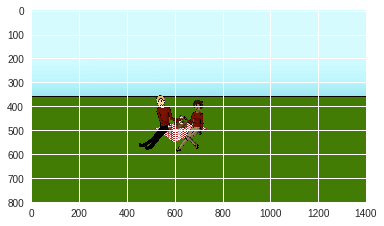

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(os.path.join('egocentric_images', '3018Q3ZVOIP09D6EHCSABBJ8FBHRAZ_2_Doll02.png'))
imgplot = plt.imshow(img)
img_feature = np.load(os.path.join(feature_folder, '3018Q3ZVOIP09D6EHCSABBJ8FBHRAZ_2_Doll02' + '.npy'))
img_feature.sum()

('a: ', 35481.504)
('c: ', 35481.504)


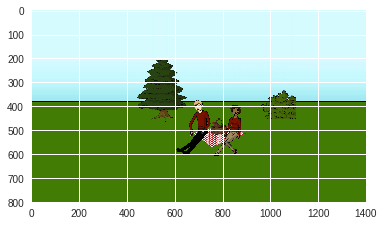

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(os.path.join('egocentric_images', '3018Q3ZVOIP09D6EHCSABBJ8FBHRAZ_1_Doll03.png'))
imgplot = plt.imshow(img)
img_feature = np.load(os.path.join(feature_folder, '3018Q3ZVOIP09D6EHCSABBJ8FBHRAZ_1_Doll03' + '.npy'))
print("a: ", img_feature.sum())

img = image.load_img(os.path.join('egocentric_images', '3018Q3ZVOIP09D6EHCSABBJ8FBHRAZ_1_Doll03.png'), target_size = (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = resnet50.preprocess_input(x)
img_feature = model.predict(x)

img_feature = img_feature.reshape((7, 7, 512, 4)).max(axis=3).flatten()
print("c: ", img_feature.sum())

('a: ', 32976.555)
('c: ', 32976.555)


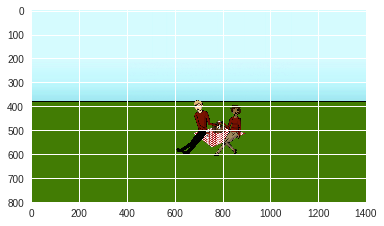

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(os.path.join('egocentric_images', '3018Q3ZVOIP09D6EHCSABBJ8FBHRAZ_2_Doll03.png'))
imgplot = plt.imshow(img)
img_feature = np.load(os.path.join(feature_folder, '3018Q3ZVOIP09D6EHCSABBJ8FBHRAZ_2_Doll03' + '.npy'))
print("a: ", img_feature.sum())

img = image.load_img(os.path.join('egocentric_images', '3018Q3ZVOIP09D6EHCSABBJ8FBHRAZ_2_Doll03.png'), target_size = (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = resnet50.preprocess_input(x)
img_feature = model.predict(x)

img_feature = img_feature.reshape((7, 7, 512, 4)).max(axis=3).flatten()
print("c: ", img_feature.sum())

35740.273

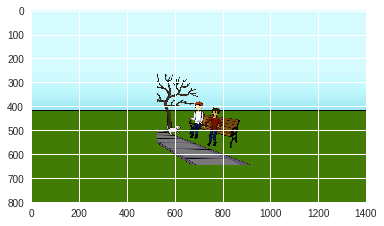

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(os.path.join('egocentric_images', '3018Q3ZVOIP09D6EHCSABBJ8GWAARI_1_Doll15.png'))
imgplot = plt.imshow(img)
img_feature = np.load(os.path.join(feature_folder, '3018Q3ZVOIP09D6EHCSABBJ8GWAARI_1_Doll15' + '.npy'))
img_feature.sum()

37170.79

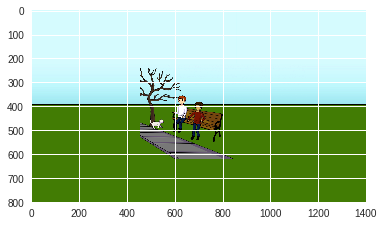

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(os.path.join('egocentric_images', '3018Q3ZVOIP09D6EHCSABBJ8GWAARI_1_Doll17.png'))
imgplot = plt.imshow(img)
img_feature = np.load(os.path.join(feature_folder, '3018Q3ZVOIP09D6EHCSABBJ8GWAARI_1_Doll17' + '.npy'))
img_feature.sum()

40272.355

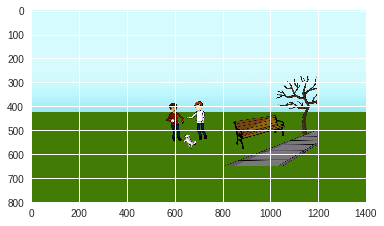

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(os.path.join('egocentric_images', '3018Q3ZVOIP09D6EHCSABBJ8GWAARI_2_Doll15.png'))
imgplot = plt.imshow(img)
img_feature = np.load(os.path.join(feature_folder, '3018Q3ZVOIP09D6EHCSABBJ8GWAARI_2_Doll15' + '.npy'))
img_feature.sum()

In [0]:
!pip install tqdm

import glob
import os
import numpy as np
from keras.applications.resnet50 import ResNet50
from keras.applications import resnet50
from keras.preprocessing import image
from keras.models import Model
import json
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
b_model = ResNet50(weights='imagenet')
model = Model(inputs=b_model.input, outputs = b_model.layers[-4].output)